# Segment with Omnipose, and classify with PRISM

## Mother cell segmentation

In [1]:
# Import dependencies
import numpy as np
from cellpose_omni import models, core, plot
import os
import zarr
from tqdm import tqdm
from natsort import natsorted
from glob import glob
from cellpose_omni import models
from cellpose_omni.models import MODEL_NAMES
import time
from PIL import Image
from IPython.display import display
import omnipose
import pickle

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? {}'.format(use_GPU))

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['figure.dpi'] = 300
# plt.style.use('dark_background')
%matplotlib inline

2025-05-29 11:10:53,202 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? True


In [2]:
import os
# os.environ["JOBLIB_TEMP_FOLDER"] = "C:/temp"
# os.makedirs("C:/temp", exist_ok=True)
os.makedirs("D:/temp", exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/temp"

In [3]:
basedir = os.getcwd()
print(basedir)

# Open the existing zarr file
# z1 = zarr.open(r"D:\PRISM\trenches_leaknuc.zarr", mode='r')
z1 = zarr.open(r'D:\PRISM\trenches_1111growth.zarr', mode='r')
# z1 = zarr.open(r'D:\PRISM\trenches_0000growth.zarr', mode='r')

print(z1.shape)
# trenches_leaknuc.zarr
# Create a new zarr file with the same shape
z2 = zarr.open(basedir + '\\masks_uninduced_all_2.zarr', mode='w', shape=z1.shape)
print(z2.shape)

d:\PRISM
(300, 53, 3, 100, 30)
(300, 53, 3, 100, 30)


In [18]:
import napari

# Assuming z1 is your Zarr dataset
viewer = napari.Viewer()

# Add the Zarr data to the viewer
viewer.add_image(z1, name='Trench Data')

# Start the napari viewer
napari.run()


In [4]:
z2.shape[1]/17

3.1176470588235294

Fix order of channels

In [5]:
print("Shape of z1:", z1.shape)
print("First trench data channels:", z1[0, 0, :, :, :])  # View sample data


Shape of z1: (300, 53, 3, 100, 30)
First trench data channels: [[[3370 3479 3558 ... 3490 3484 3522]
  [3344 3347 3478 ... 3599 3587 3471]
  [3319 3366 3437 ... 3617 3377 3396]
  ...
  [1865 1909 1933 ... 2388 2197 2066]
  [1996 1985 1957 ... 2360 2231 2057]
  [2054 1973 1907 ... 2502 2325 2058]]

 [[ 211  185  167 ...  221  217  200]
  [ 209  194  169 ...  202  206  224]
  [ 214  204  199 ...  191  184  205]
  ...
  [ 202  179  212 ...  235  209  211]
  [ 205  236  229 ...  237  217  219]
  [ 187  224  200 ...  219  218  205]]

 [[ 138  116  121 ...  118  128  117]
  [ 118  144  119 ...  140  127  135]
  [ 115  122  157 ...  123  117  123]
  ...
  [ 130  115  137 ...  157  144  136]
  [ 129  128  126 ...  153  145  141]
  [ 140  142  131 ...  157  161  146]]]


In [ ]:
# # Use this if you need to reorder to make PC channel 0
# # Define the desired order
# desired_order = ["PC", "BFP", "RFP"]

# # Create a mapping of the current order to the desired order
# # Replace this with your actual current channel order
# current_order = ['BFP', 'PC', 'RFP']
# reorder_indices = [current_order.index(channel) for channel in desired_order]
# # Open the Zarr file in read-write mode
# z1 = zarr.open('trenches_1111.zarr', mode='r+')

# # Create a temporary copy of the reordered data
# z1_reordered = np.copy(z1[:, :, reorder_indices, :, :])

# # Overwrite the original file with the reordered data
# z1[:, :, :, :, :] = z1_reordered

# print("Channels have been reordered in the Zarr file!")
# basedir = os.getcwd()
# z1 = zarr.open(basedir + '\\trenches_1111.zarr', mode='r')

(100, 1200)


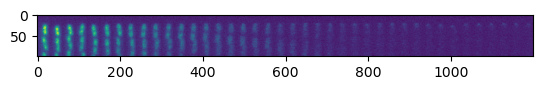

In [6]:
trench_num = 16
frame_num = 0
channel = 2
img_PIL = Image.fromarray(z1[trench_num, frame_num, channel])
# display(img_PIL)
test = [np.concatenate(z1[trench_num, frame_num:frame_num+40, channel], axis=1)]
print(test[-1].shape)
plt.imshow(test[-1])
plt.show()

In [ ]:
# Specify the path to your model
# model from Erez
#model_path = "D:\\PRISM\\models\\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD3_2024_10_19_15_40_06.232997_epoch_4999"
# first trained on Symbac
# model_path = r"D:\PRISM\Omnipose_train\SyMBacData\40x_pc_20241101\TD1\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD1_2024_11_02_21_36_47.717935_epoch_35"
# retrained from the above model
# model_path = r"D:\PRISM\Omnipose_train\SyMBacData\40x_pc_20241101\TD2\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD2_2024_11_03_14_33_40.165001_epoch_56"


# 20250106 for 60x segmentation
# model_path = r"D:\PRISM\Omnipose_train\SyMBacData\40x_pc_20250106\TD1\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD1_2025_01_06_14_10_42.449719_epoch_59"
# recycled
#model_path = r"D:\PRISM\Omnipose_train\SyMBacData\40x_pc_20250106\TD3\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD3_2025_01_06_17_42_13.699051_epoch_59"
# good, recycled again
#model_path = r"D:\PRISM\Omnipose_train\SyMBacData\40x_pc_20250106\TD4\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD4_2025_01_06_19_49_33.357324_epoch_59"

#20240528 for growth rate experiment
model_path = r"D:\PRISM\Omnipose_train\SyMBacData\60x_pc_20250528\TD1\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD1_2025_05_28_19_56_28.043044_epoch_99"


#20250510 for 100x
#model_path = r"D:\PRISM\Omnipose_train\SyMBacData\100x_pc_20250510\TD1\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD1_2025_05_10_17_42_17.178451_epoch_59"
#recycled best for 100x
# model_path = r"D:\PRISM\Omnipose_train\SyMBacData\100x_pc_20250510\TD2\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD2_2025_05_10_22_14_11.213998_epoch_149"
# Initialize the model using the specific path
model = models.CellposeModel(gpu=use_GPU, pretrained_model=model_path, omni=True, concatenation=True)


2025-05-29 11:10:57,589 [INFO] ** TORCH GPU version installed and working. **
2025-05-29 11:10:57,590 [INFO] >>>> using GPU


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\cellpose_omni\resnet_torch.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(filen

In [7]:
# model_name = 'bact_phase_omni'
# model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

In [8]:
# chans = [0,0]  #this means segment based on first channel, no second channel 
chans = [0,0]

# n = [-1] # make a list of integers to select which images you want to segment
# n = range(nimg) # or just segment them all 

# define parameters
params = {'channels':None, # always define this with the model
          'rescale': None, # upscale or downscale your images, None = no rescaling 
          'mask_threshold': -1, # erode or dilate masks with higher or lower values 
          'flow_threshold': 0., # default is .4, but only needed if there are spurious masks to clean up; slows down output
          'transparency': True, # transparency in flow output
          'omni': True, # we can turn off Omnipose mask reconstruction, not advised 
          'cluster': True, # use DBSCAN clustering
          'resample': True, # whether or not to run dynamics on rescaled grid or original grid 
          'verbose': 0, # turn on if you want to see more output 
          'tile': False, # average the outputs from flipped (augmented) images; slower, usually not needed 
          'niter': None, # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
          'augment': False, # Can optionally rotate the image and average outputs, usually not needed 
          'affinity_seg': False, # new feature, stay tuned...
         }

In [9]:
n = range(len(test))
masks, flows, styles = model.eval(test, **params)
for idx,i in enumerate(n):

    maski = masks[idx] # get masks
    bdi = flows[idx][-1] # get boundaries
    flowi = flows[idx][0] # get RGB flows 

    # set up the output figure to better match the resolution of the images 
    f = 100
    szX = maski.shape[-1]/mpl.rcParams['figure.dpi']*f
    szY = maski.shape[-2]/mpl.rcParams['figure.dpi']*f
    fig = plt.figure(figsize=(szY,szX*4))
    fig.patch.set_facecolor([0]*4)
    
    plot.show_segmentation(fig, omnipose.utils.normalize99(test[i]), 
                           maski, flowi, bdi, channels=chans, omni=True,
                           interpolation=None)

    plt.tight_layout()
    plt.show()

NameError: name 'test' is not defined

### Segmentation without Alignment

In [9]:
# # Naive: Segment the first channel (PC) and overlay it to other channels
import math


w = 50
N = math.ceil(z2.shape[1] / w)

print("Total segments:", N)
tic = time.time()

# Process each trench
for i in tqdm(range(z1.shape[0])):
    for j in tqdm(range(N)):
        imgs = z1[i, j*w:(j+1)*w, 0, :, :]  # Load images from the first channel only for segmentation
        concat_num = imgs.shape[0]
        concat = np.concatenate(imgs, axis=1)
        
        try:
            # Segment the image in the first channel
            masks, flows, styles = model.eval(concat, **params)
            outputs = np.array_split(masks, concat_num, axis=1)
            
            # Apply the resulting mask to all channels in z2
            if (j+1)*w <= z2.shape[1]:
                for ch in range(z2.shape[2]):  # Loop over all channels
                    z2[i, j*w:(j+1)*w, ch] = np.array(outputs)  # Overlay mask on each channel
            else:
                for ch in range(z2.shape[2]):  # Loop over all channels
                    z2[i, j*w:, ch] = np.array(outputs)  # Overlay mask on each channel for remaining segments
        except ValueError:
            print("Error processing trench", i, "segment", j)
            pass

net_time = time.time() - tic
print('Total segmentation time: {}s'.format(net_time))

Total segments: 2


  0%|          | 0/300 [00:00<?, ?it/s]c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\cellpose_omni\resnet_torch.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Total segmentation time: 933.602283000946s


In [38]:
z1.shape

(600, 1, 3, 260, 60)

### Segmentation and mask alignment

In [ ]:
# works with alingment
import zarr
import numpy as np
import time
from tqdm import tqdm
from copy import deepcopy
import math
import os

# Define the function to align FL images based on the mask
def align_FL_mask(FL_image, mask):
    mask = mask > 0
    optimal_image = deepcopy(FL_image)
    current_sum = (optimal_image * mask).sum()
    
    for x in range(-6, 7):
        rolled_x = np.roll(FL_image, x, axis=1)
        for y in range(-6, 7):
            rolled_y = np.roll(rolled_x, y, axis=0)
            FL_sum = np.sum(rolled_y * mask)
            if FL_sum > current_sum:
                optimal_image = rolled_y
                current_sum = FL_sum
    
    return optimal_image

# Define the segmentation and alignment function
def segment_and_align(z1, z2, z1_adjusted, model, params, w=50):
    N = math.ceil(z2.shape[1] / w)
    print("Total segments:", N)
    tic = time.time()
    
    # Process each trench
    for i in tqdm(range(z1.shape[0])):
        for j in range(N):
            # Segment the first channel (PC)
            pc_image = z1[i, j*w:(j+1)*w, 0, :, :]
            concat = np.concatenate(pc_image, axis=1)
            
            try:
                # Perform segmentation on the concatenated PC images
                masks, flows, styles = model.eval(concat, **params)
                individual_masks = np.array_split(masks, pc_image.shape[0], axis=1)
                
                # Use only the mother cell mask (topmost cell) for alignment
                mother_cell_mask = individual_masks[0]  # Assuming the first mask corresponds to the mother cell

                # Copy the original PC images directly to z1_adjusted
                z1_adjusted[i, j*w:(j+1)*w, 0, :, :] = pc_image

                # Apply the mask to all channels in z2
                if (j+1)*w <= z2.shape[1]:
                    for ch in range(z2.shape[2]):
                        z2[i, j*w:(j+1)*w, ch] = np.array(individual_masks)  # Overlay mask on each channel
                        
                        # Align each FL channel based on the mother cell mask
                        if ch > 0:  # Skip alignment for the first channel (PC)
                            for img_idx, mask in enumerate(individual_masks):
                                FL_image = z1[i, j*w + img_idx, ch, :, :]
                                aligned_FL_image = align_FL_mask(FL_image, mask)
                                z1_adjusted[i, j*w + img_idx, ch, :, :] = aligned_FL_image
                else:
                    for ch in range(z2.shape[2]):
                        z2[i, j*w:, ch] = np.array(individual_masks)  # Overlay mask on each channel for remaining segments
                        
                        # Align each FL channel based on the mother cell mask
                        if ch > 0:  # Skip alignment for the first channel (PC)
                            for img_idx, mask in enumerate(individual_masks):
                                FL_image = z1[i, j*w + img_idx, ch, :, :]
                                aligned_FL_image = align_FL_mask(FL_image, mask)
                                z1_adjusted[i, j*w + img_idx, ch, :, :] = aligned_FL_image

            except ValueError as e:
                print(f"Error processing trench {i}, segment {j}: {e}")
                pass

    net_time = time.time() - tic
    print('Total segmentation and alignment time: {}s'.format(net_time))

# Set base directory and create new writable Zarr arrays for adjusted images and masks
basedir = os.getcwd()
z1_adjusted = zarr.open(basedir + '/z1_adjusted.zarr', mode='w', shape=z1.shape, dtype=z1.dtype)
z2 = zarr.open(basedir + '/masks_uninduced_all_2.zarr', mode='w', shape=z1.shape, dtype=z1.dtype)

# Call the segmentation and alignment function
segment_and_align(z1, z2, z1_adjusted, model, params, w=50)


Total segments: 1


  1%|          | 1/180 [00:01<05:15,  1.76s/it]c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\cellpose_omni\resnet_torch.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

2025-05-28 22:32:37,349 [INFO] No cell pixels found.


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\cellpose_omni\resnet_torch.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(filen

2025-05-28 22:33:21,335 [INFO] No cell pixels found.


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\cellpose_omni\resnet_torch.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(filen

Total segmentation and alignment time: 143.99506878852844s


### visualise

In [65]:
print(z1.shape)
# print(z1_adjusted.shape)
print(z2.shape)


(251, 35, 3, 100, 30)
(251, 35, 3, 100, 30)


In [ ]:
import napari


def view_with_napari(image_zarr, mask_zarr):
    with napari.gui_qt():
        viewer = napari.Viewer()

        # Add original images
        viewer.add_image(image_zarr, name='Original Images', colormap='gray', contrast_limits=[0, 255])

        # Convert masks to integer type and add them as labels
        mask_int = mask_zarr.astype(np.int32)  # Convert float masks to integers
        viewer.add_labels(mask_int, name='Masks', opacity=0.5)

# Call the function to launch Napari
view_with_napari(z1, z2)


### (Old version) Prepare input image for PRISM

In [19]:
# just a helper function for plots

def plot_cells_by_channel(filtered_images, start_trench=0, end_trench=5):
    """
    Plots filtered images for each trench in rows and channels in columns.
    
    Parameters:
    - filtered_images: The structured list where each entry corresponds to a trench,
                       and each trench contains a list of channel images.
    - start_trench: The starting index for the trench to visualize.
    - end_trench: The ending index (exclusive) for the trench to visualize.
    """
    num_trenches = end_trench - start_trench
    num_channels = len(filtered_images[0])  # Assuming each trench has the same number of channels
    
    # Define a smaller and more compact figure size
    plt.figure(figsize=(num_channels * 1.5, num_trenches * 1.5))
    
    for row_idx, trench_idx in enumerate(range(start_trench, end_trench)):
        trench_images = filtered_images[trench_idx]
        
        for col_idx, channel_image in enumerate(trench_images):
            ax = plt.subplot(num_trenches, num_channels, row_idx * num_channels + col_idx + 1)
            ax.imshow(channel_image, cmap='gray')
            ax.axis('off')
            
            # Adding column titles for each channel and row labels for each trench
            if row_idx == 0:
                ax.set_title(f"Ch {col_idx + 1}", fontsize=8, pad=3)
            if col_idx == 0:
                ax.set_ylabel(f"Trench {trench_idx}", rotation=90, fontsize=8, labelpad=5)
    
    # Adding a main title and adjusting layout for minimal space
    plt.suptitle(f"Filtered Images from Trenches {start_trench} to {end_trench - 1}", fontsize=12, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Minimize margins
    plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Minimal spacing between subplots
    plt.show()




Skipping image: Cropped size (66, 30) exceeds target shape (64, 36).
Skipping trench 2, channel 0 due to oversized crop.
Skipping image: Cropped size (66, 30) exceeds target shape (64, 36).
Skipping trench 2, channel 1 due to oversized crop.
Skipping image: Cropped size (104, 28) exceeds target shape (64, 36).
Skipping trench 8, channel 0 due to oversized crop.
Skipping image: Cropped size (104, 28) exceeds target shape (64, 36).
Skipping trench 8, channel 1 due to oversized crop.
Skipping image: Cropped size (69, 25) exceeds target shape (64, 36).
Skipping trench 13, channel 0 due to oversized crop.
Skipping image: Cropped size (69, 25) exceeds target shape (64, 36).
Skipping trench 13, channel 1 due to oversized crop.
Skipping image: Cropped size (166, 24) exceeds target shape (64, 36).
Skipping trench 14, channel 0 due to oversized crop.
Skipping image: Cropped size (166, 24) exceeds target shape (64, 36).
Skipping trench 14, channel 1 due to oversized crop.
Skipping image: Cropped 

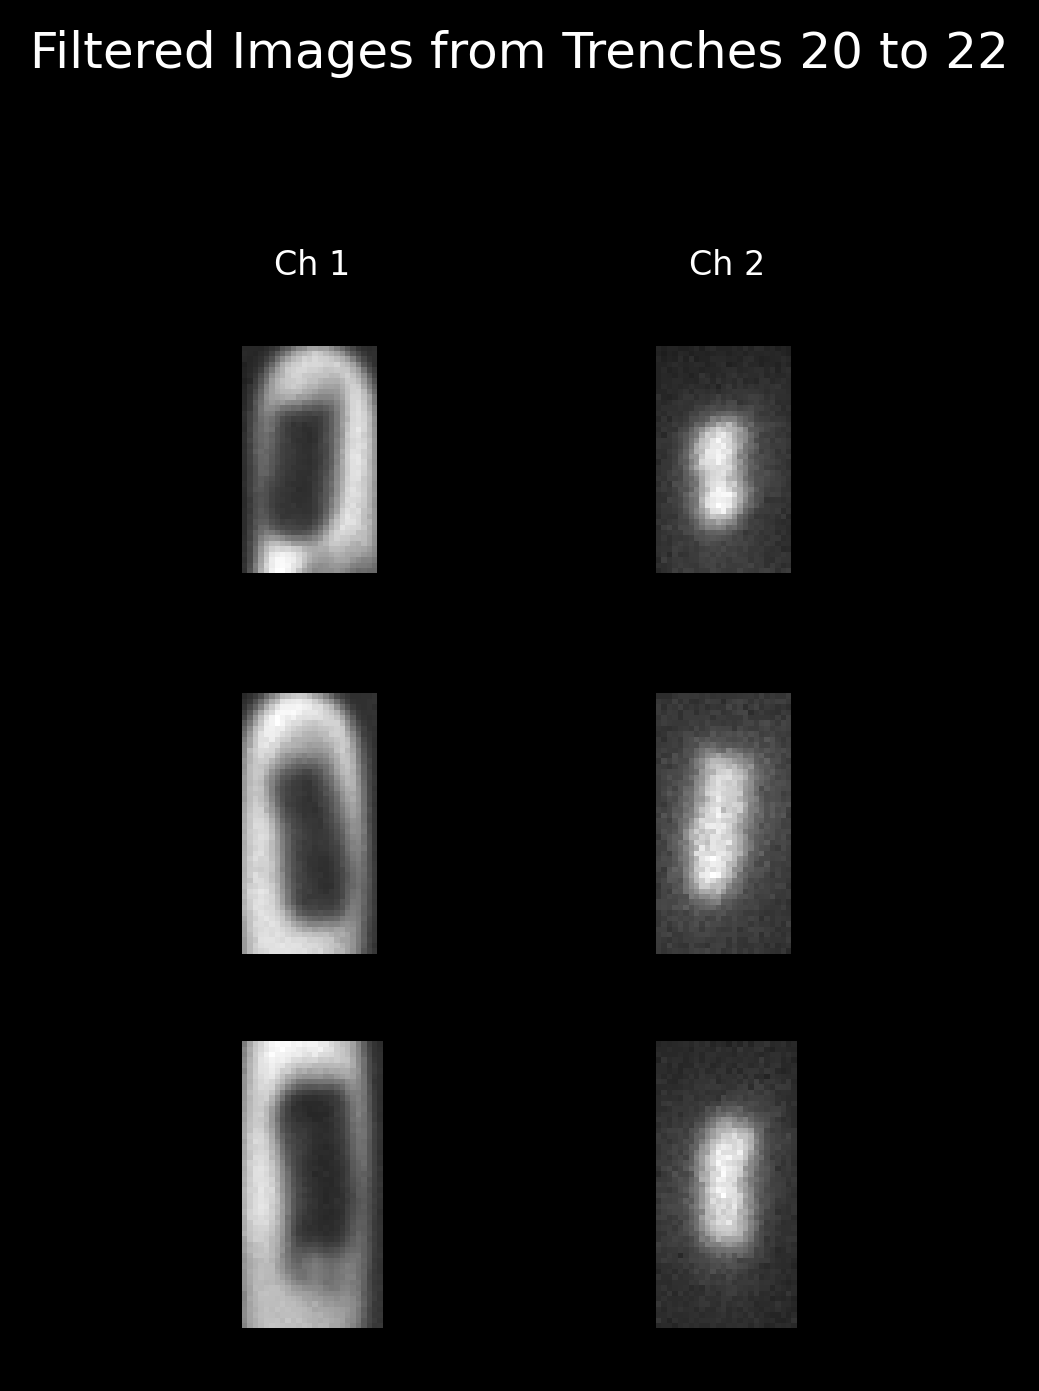

In [20]:
# This code finds the mask of the mother cell, finds the bounding box and expands it slightly by a margin
from skimage.transform import resize

# Load the Zarr arrays
# Set the base directory
basedir = os.getcwd()

# Open the adjusted images (z1_adjusted) and masks (z2) in read mode
z1_adjusted = zarr.open(os.path.join(basedir, 'z1_adjusted.zarr'), mode='r')  # Adjusted images
z2 = zarr.open(os.path.join(basedir, 'masks_uninduced_all_2.zarr'), mode='r')  # Masks

# since flourescent images tend to be bigger and slightly shifted, add a margin to the bounding box for mother cell mask.
margin = 3

def extract_mother_cell_bbox(mask, margin=2):
    """
    Given a mask, return the bounding box coordinates of the top-most cell (mother cell)
    with an additional margin around it.
    """
    non_zero_coords = np.argwhere(mask > 0)
    if len(non_zero_coords) == 0:
        return None

    # Find top-most cell based on the minimum y-coordinate
    top_cell_coords = non_zero_coords[non_zero_coords[:, 0].argmin()]
    top_cell_label = mask[top_cell_coords[0], top_cell_coords[1]]

    # Get the bounding box for the mother cell
    cell_coords = np.argwhere(mask == top_cell_label)
    min_y, min_x = cell_coords.min(axis=0)
    max_y, max_x = cell_coords.max(axis=0)

    # Expand the bounding box by the specified margin
    min_y = max(min_y - margin, 0)
    max_y = min(max_y + margin, mask.shape[0] - 1)
    min_x = max(min_x - margin, 0)
    max_x = min(max_x + margin, mask.shape[1] - 1)

    return min_y, max_y, min_x, max_x

def crop_and_pad_image(image, bbox, target_shape=(64, 36)):
    """
    Crop the image around the bounding box and pad to the target shape if it fits within the target shape.
    Skip if the cropped image is larger than the target shape.
    """
    min_y, max_y, min_x, max_x = bbox
    cropped_image = image[min_y:max_y+1, min_x:max_x+1]

    # Check if the cropped image fits within the target shape
    crop_height, crop_width = cropped_image.shape
    if crop_height > target_shape[0] or crop_width > target_shape[1]:
        print(f"Skipping image: Cropped size ({crop_height}, {crop_width}) exceeds target shape {target_shape}.")
        return None  # Skip this image

    # Initialize a padded image of the target shape with zeros (background)
    padded_image = np.zeros(target_shape, dtype=cropped_image.dtype)

    # Calculate where to place the cropped image within the padded image
    start_y = (target_shape[0] - crop_height) // 2
    start_x = (target_shape[1] - crop_width) // 2

    # Insert the cropped image into the center of the padded image
    padded_image[start_y:start_y+crop_height, start_x:start_x+crop_width] = cropped_image

    return padded_image


def apply_bounding_box_and_resize(z1, z2, target_shape=(64, 36), margin=2):
    """
    Use bounding box approach to crop around the mother cell in each channel, add margin, and pad to target shape.
    Skip images where the cropped size exceeds the target shape.
    """
    processed_images = []  # Store the cropped, padded images for each trench and channel

    for i in range(z1.shape[0]):
        trench_images = []  # Store images for each channel in the current trench

        mask = z2[i, 0, 0, :, :]  # Assume the mask is in the first channel of z2
        bbox = extract_mother_cell_bbox(mask, margin=margin)

        if bbox is None:
            print(f"No cells found in trench {i}. Skipping...")
            processed_images.append([None] * z1.shape[2])  # Add None for each channel
            continue

        for channel in range(z1.shape[2]):
            img_channel = z1[i, 0, channel, :, :]  # Select the current channel
            padded_image = crop_and_pad_image(img_channel, bbox, target_shape=target_shape)  # Crop and pad
            if padded_image is None:  # If the image was skipped
                print(f"Skipping trench {i}, channel {channel} due to oversized crop.")
                trench_images.append(None)
                continue
            trench_images.append(padded_image)  # Append each channel image to the trench list

        processed_images.append(trench_images)  # Append trench images for all channels

    return processed_images


# Run the bounding box, cropping, and padding function
processed_images_6436 = apply_bounding_box_and_resize(z1_adjusted, z2, target_shape=(64, 36), margin=margin)

# Check the structure of processed_images_6436
print(f"Number of trenches: {len(processed_images_6436)}")
print(f"Number of channels in the first trench: {len(processed_images_6436[0])}")
# print(f"Shape of the first trench, first channel image: {processed_images_6436[0][0].shape}")



# Display trenches 26 to 31 for verification
plot_cells_by_channel(processed_images_6436, start_trench=20, end_trench=23)



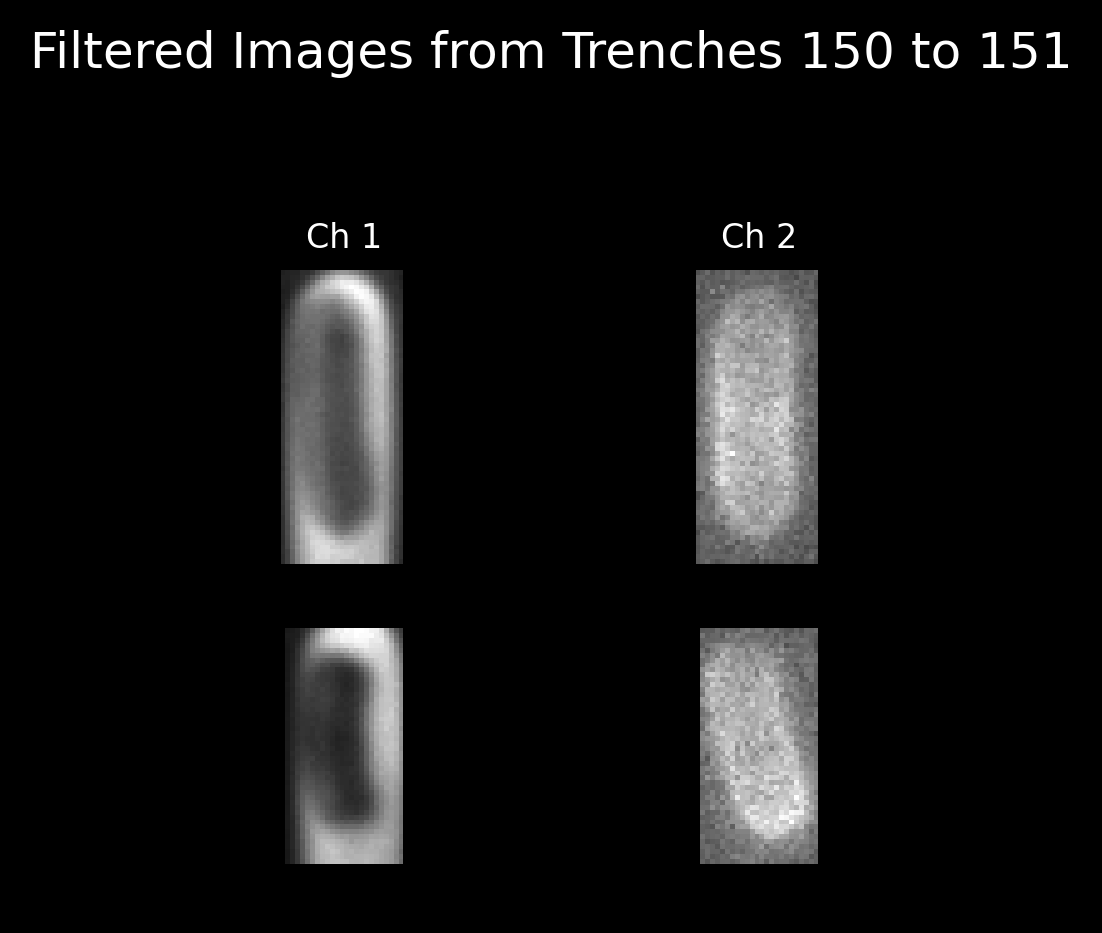

In [194]:
plot_cells_by_channel(processed_images_6436, start_trench=150, end_trench=152)

No cells found in trench 0. Skipping...
No cells found in trench 5. Skipping...
No cells found in trench 8. Skipping...
No cells found in trench 11. Skipping...
No cells found in trench 12. Skipping...
No cells found in trench 19. Skipping...
No cells found in trench 28. Skipping...
No cells found in trench 33. Skipping...
No cells found in trench 34. Skipping...
No cells found in trench 36. Skipping...
No cells found in trench 40. Skipping...
No cells found in trench 50. Skipping...
No cells found in trench 65. Skipping...
No cells found in trench 70. Skipping...
No cells found in trench 76. Skipping...
No cells found in trench 80. Skipping...
No cells found in trench 87. Skipping...
No cells found in trench 101. Skipping...
No cells found in trench 103. Skipping...
No cells found in trench 108. Skipping...
No cells found in trench 110. Skipping...
No cells found in trench 120. Skipping...
No cells found in trench 122. Skipping...
No cells found in trench 127. Skipping...
No cells fou

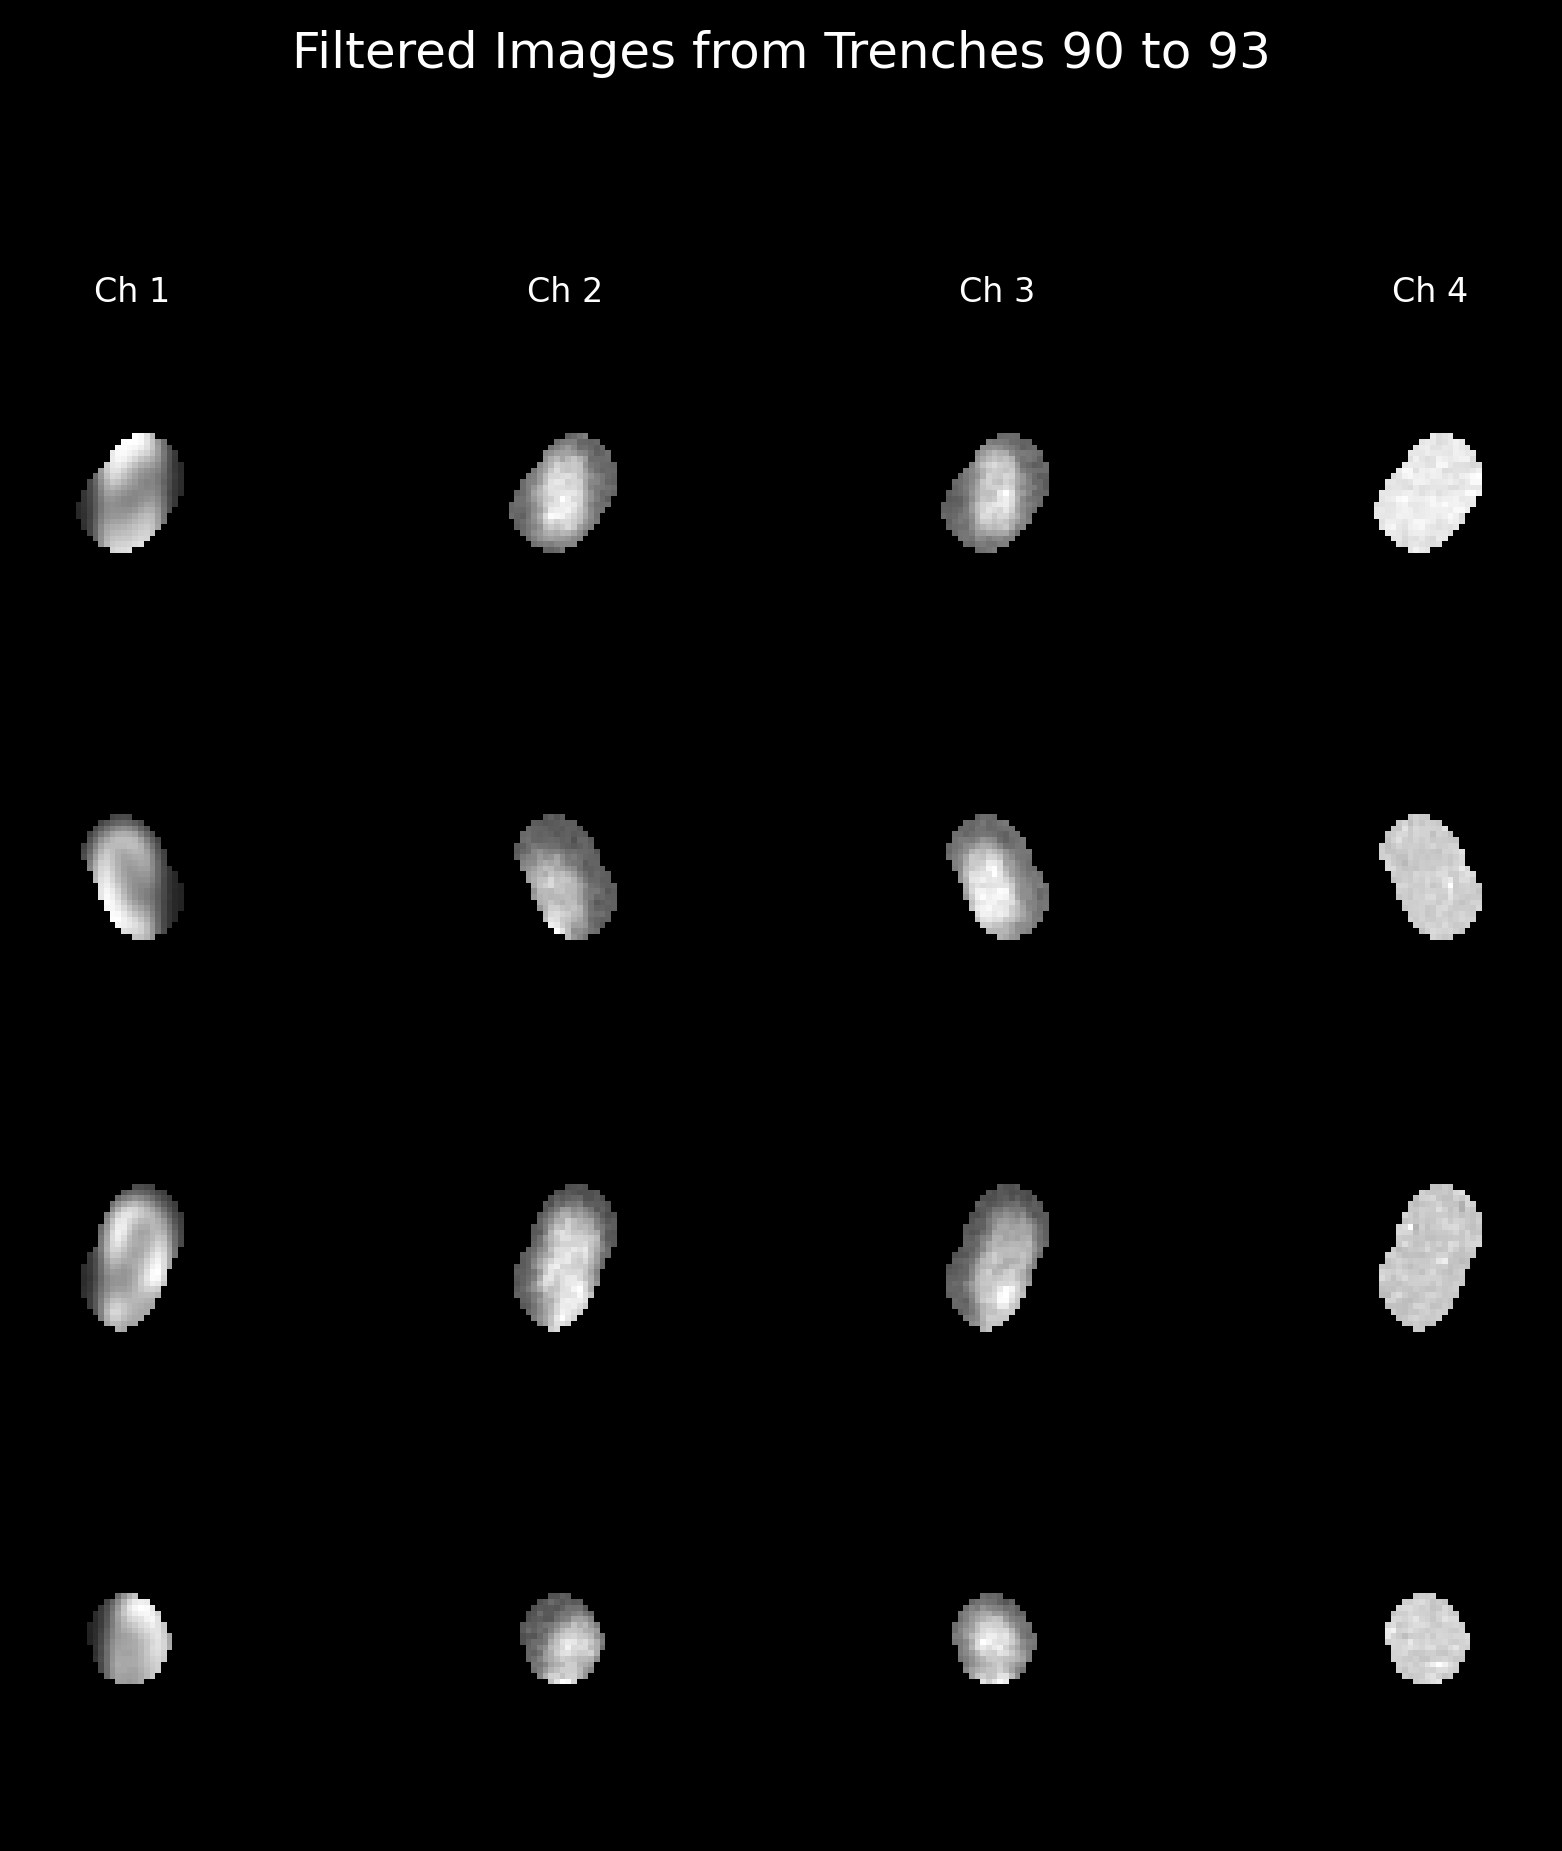

In [ ]:
from skimage.morphology import binary_dilation, disk

dilation_radius = 4

# Load the adjusted Zarr arrays
# Set the base directory
basedir = os.getcwd()

# Open the adjusted images (z1_adjusted) and masks (z2) in read mode
z1_adjusted = zarr.open(os.path.join(basedir, 'z1_adjusted.zarr'), mode='r')  # Adjusted images
z2 = zarr.open(os.path.join(basedir, 'masks_uninduced_all_2.zarr'), mode='r')  # Masks

def extract_first_cell_filter(mask, dilation_radius=3):
    """
    Given a mask, extract a binary filter where the first (top-most) cell is marked as 1,
    and all other cells are marked as 0. Expands the filter by applying dilation.
    """
    non_zero_coords = np.argwhere(mask > 0)
    if len(non_zero_coords) == 0:
        return None

    # Find top-most cell based on the minimum y-coordinate
    top_cell_coords = non_zero_coords[non_zero_coords[:, 0].argmin()]
    top_cell_label = mask[top_cell_coords[0], top_cell_coords[1]]
    first_cell_filter = (mask == top_cell_label).astype(np.int32)
    
    # Apply dilation to make the filter slightly larger
    dilated_filter = binary_dilation(first_cell_filter, disk(dilation_radius)).astype(np.int32)
    return dilated_filter

def crop_and_pad_image(image, target_shape=(64, 36)):
    """
    Crop the non-zero region of an image and pad to the target shape.
    Skip if the cropped image is larger than the target shape.
    """
    non_zero_coords = np.argwhere(image > 0)
    if len(non_zero_coords) == 0:
        return np.zeros(target_shape)  # Return an empty black image if there’s nothing to crop
    
    min_y, min_x = non_zero_coords.min(axis=0)
    max_y, max_x = non_zero_coords.max(axis=0)
    cropped_image = image[min_y:max_y+1, min_x:max_x+1]
    
    # Check if the cropped image fits within the target shape
    crop_height, crop_width = cropped_image.shape
    if crop_height > target_shape[0] or crop_width > target_shape[1]:
        print(f"Skipping image: Cropped size ({crop_height}, {crop_width}) exceeds target shape {target_shape}.")
        return None  # Skip this image
    
    # Place the cropped image in the center of a black background of target size
    padded_image = np.zeros(target_shape)
    start_y = (target_shape[0] - crop_height) // 2
    start_x = (target_shape[1] - crop_width) // 2
    padded_image[start_y:start_y+crop_height, start_x:start_x+crop_width] = cropped_image
    
    return padded_image

def apply_filter_and_pad(z1, z2, target_shape=(64, 36), dilation_radius=3):
    """
    Apply the first cell filter to each channel in the original image, crop, and pad to target shape.
    Skip images where the cropped size exceeds the target shape.
    """
    filtered_images_6436 = []  # Store the filtered, cropped, and padded images for each trench and channel

    for i in range(z1.shape[0]):
        trench_images = []  # Store images for each channel in the current trench
        
        mask = z2[i, 0, 0, :, :]  # Assume the mask is in the first channel of z2
        first_cell_filter = extract_first_cell_filter(mask, dilation_radius=dilation_radius)
        
        if first_cell_filter is None:
            print(f"No cells found in trench {i}. Skipping...")
            filtered_images_6436.append([None] * z1.shape[2])  # Add None for each channel
            continue
        
        for channel in range(z1.shape[2]):
            img_channel = z1[i, 0, channel, :, :]  # Select the current channel
            filtered_image = img_channel * first_cell_filter  # Apply the expanded first cell filter
            padded_image = crop_and_pad_image(filtered_image, target_shape=target_shape)  # Crop and pad
            
            if padded_image is None:  # If the image was skipped
                print(f"Skipping trench {i}, channel {channel} due to oversized crop.")
                trench_images.append(None)
                continue
            
            trench_images.append(padded_image)  # Append each channel image to the trench list
        
        filtered_images_6436.append(trench_images)  # Append trench images for all channels

    return filtered_images_6436

# Run the filtering, cropping, and padding function
filtered_images_6436 = apply_filter_and_pad(z1_adjusted, z2, target_shape=(64, 36), dilation_radius=dilation_radius)

# Check the structure of filtered_images_6436
print(f"Number of trenches: {len(filtered_images_6436)}")
print(f"Number of channels in the first trench: {len(filtered_images_6436[0])}")
print(f"Shape of the first trench, first channel image: {filtered_images_6436[0][0].shape if filtered_images_6436[0][0] is not None else 'Skipped'}")

# Display trenches 6 to 11 for verification
plot_cells_by_channel(filtered_images_6436, start_trench=90, end_trench=94)


# Growth Rate Calculation

we segment each cell, and use the vertical length of the mask to calculate growth rate.

### Finding for 0000

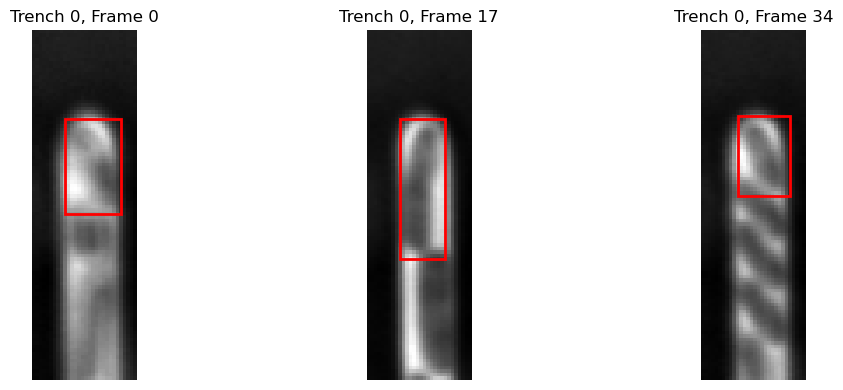

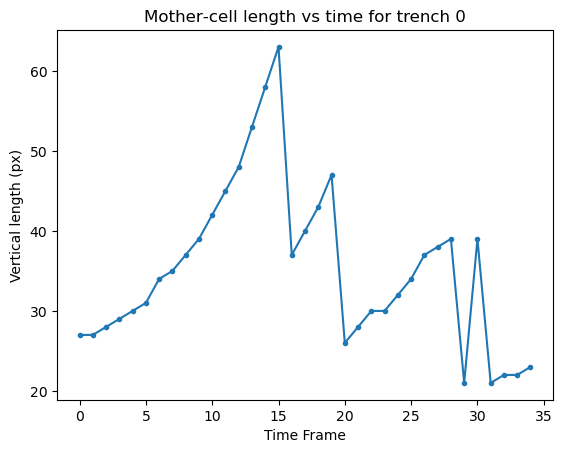

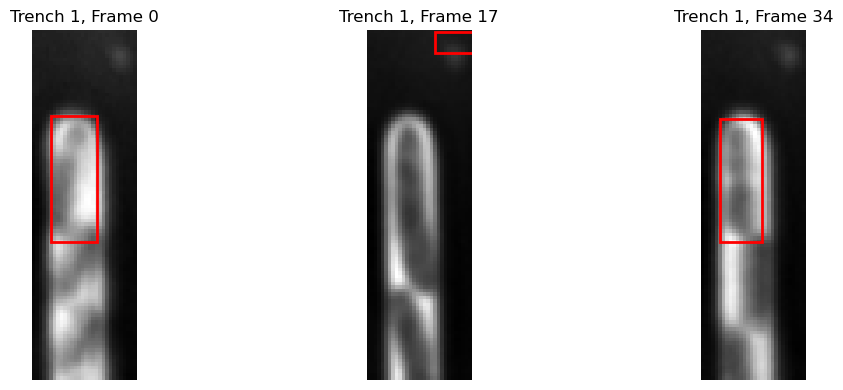

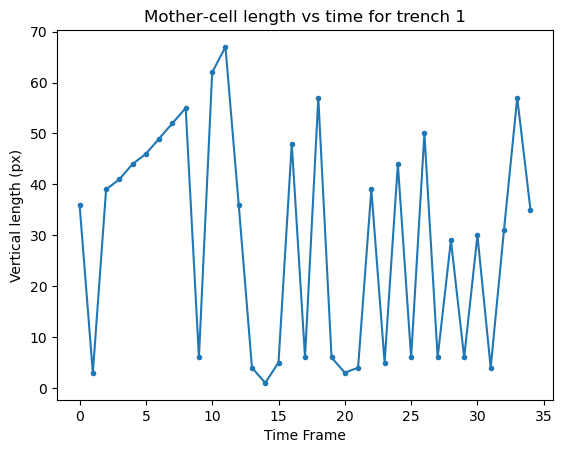

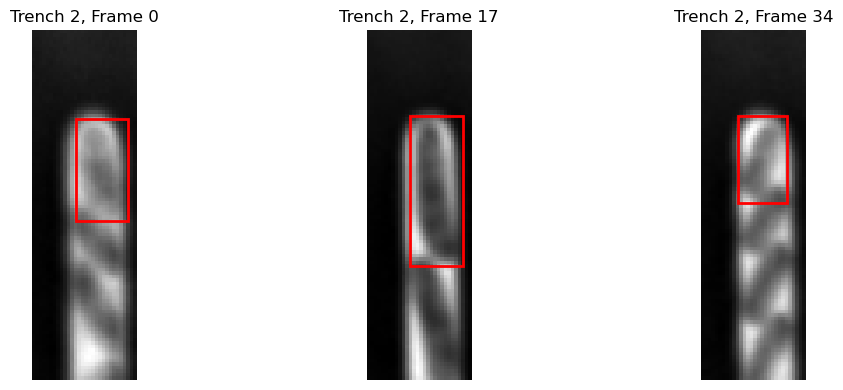

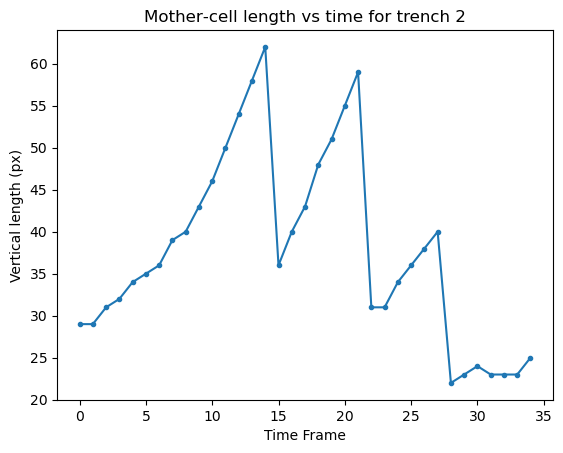

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import zarr
from skimage.measure import regionprops
from matplotlib.patches import Rectangle

# --- Load your data ---
z1 = zarr.open('D:/PRISM/trenches_0000growth.zarr', mode='r')      # phase‐contrast (C=0)
z2 = zarr.open('masks_uninduced_all_2.zarr', mode='r')            # masks (C=0 contains the mother‐cell mask)

# --- Parameters ---
trenches_to_plot = [0, 1, 2]
n_frames = z2.shape[1]  # number of timepoints

for trench in trenches_to_plot:
    # 1) Show bounding boxes on a few sample frames
    sample_frames = [0, n_frames//2, n_frames-1]
    plt.figure(figsize=(12, 4))
    for i, frame in enumerate(sample_frames):
        pc_img = z1[trench, frame, 0]     # phase‐contrast
        mask   = z2[trench, frame, 0]     # mother‐cell mask
        
        # find the bounding box
        props = regionprops(mask.astype(int))
        if props:
            minr, minc, maxr, maxc = props[0].bbox
        else:
            # fallback if no mask found
            minr = minc = maxr = maxc = 0
        
        ax = plt.subplot(1, len(sample_frames), i+1)
        ax.imshow(pc_img, cmap='gray')
        ax.add_patch(Rectangle(
            (minc, minr),
            maxc-minc, maxr-minr,
            edgecolor='red', facecolor='none', lw=2
        ))
        ax.set_title(f'Trench {trench}, Frame {frame}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # 2) Compute vertical length over all frames
    lengths = []
    for frame in range(n_frames):
        mask = z2[trench, frame, 0]
        props = regionprops(mask.astype(int))
        if props:
            minr, _, maxr, _ = props[0].bbox
            lengths.append(maxr - minr)
        else:
            lengths.append(np.nan)
    
    # 3) Plot growth curve
    plt.figure()
    plt.plot(lengths, '.-')
    plt.xlabel('Time Frame')
    plt.ylabel('Vertical length (px)')
    plt.title(f'Mother‐cell length vs time for trench {trench}')
    plt.show()


Manually select correctly segmented cases

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import zarr
from skimage.measure import regionprops
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Load Zarr data ---
z1 = zarr.open('D:/PRISM/trenches_0000growth.zarr', mode='r')  # phase‐contrast (C=0)
z2 = zarr.open('masks_uninduced_all_2.zarr', mode='r')        # masks (C=0 mother‐cell)

n_trenches = z2.shape[0]
n_frames = z2.shape[1]

# --- Precompute vertical lengths for each trench & frame ---
lengths = np.full((n_trenches, n_frames), np.nan)
for trench in range(n_trenches):
    for frame in range(n_frames):
        mask = z2[trench, frame, 0]
        props = regionprops(mask.astype(int))
        if props:
            minr, _, maxr, _ = props[0].bbox
            lengths[trench, frame] = maxr - minr

# --- Interactive widget setup ---
plots_per_page = 20
max_page = int(np.ceil(n_trenches / plots_per_page)) - 1
selected = [True] * n_trenches  # default: use all

out = widgets.Output()
page = 0

def show_page(page_idx):
    start = page_idx * plots_per_page
    end = min(start + plots_per_page, n_trenches)
    out.clear_output()
    with out:
        # Plot grid of 20 growth curves
        fig, axs = plt.subplots(5, 4, figsize=(12, 10))
        for idx, trench in enumerate(range(start, end)):
            ax = axs.flat[idx]
            ax.plot(lengths[trench], '.-')
            ax.set_title(f'Trench {trench}')
            ax.set_xticks([])
            ax.set_yticks([])
        # Hide unused axes
        for ax in axs.flat[end-start:]:
            ax.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Display checkboxes for this page
        cbs = []
        for trench in range(start, end):
            cb = widgets.Checkbox(value=selected[trench], description=f'{trench}', indent=False)
            def _handler(change, trench=trench):
                selected[trench] = change['new']
            cb.observe(_handler, names='value')
            cbs.append(cb)
        grid = widgets.GridBox(cbs, layout=widgets.Layout(grid_template_columns="repeat(4, 100px)"))
        display(grid)

# Navigation buttons
btn_prev = widgets.Button(description='Previous')
btn_next = widgets.Button(description='Next')
btn_save = widgets.Button(description='Save')

def on_prev(b):
    global page
    if page > 0:
        page -= 1
        show_page(page)

def on_next(b):
    global page
    if page < max_page:
        page += 1
        show_page(page)

def on_save(b):
    clear_output()
    chosen = [i for i, use in enumerate(selected) if use]
    print("Selected trenches for growth‐rate analysis:", chosen)

btn_prev.on_click(on_prev)
btn_next.on_click(on_next)
btn_save.on_click(on_save)

nav = widgets.HBox([btn_prev, btn_next, btn_save])
display(nav, out)
show_page(page)


In [16]:
# Assume `selected` is the boolean list from the widget,
# or load it if saved in your session. For demonstration:
# selected = [...]  # boolean list of length n_trenches

# Compute the chosen trench IDs
chosen = [i for i, use in enumerate(selected) if use]

# Save to a CSV file
outfile = 'D:/PRISM/growth_rate/growth_0000_selected_trenches.csv'
with open(outfile, 'w') as f:
    f.write('trench_id\n')
    for tid in chosen:
        f.write(f"{tid}\n")

print(f"Exported {len(chosen)} trench IDs to {outfile}")


Exported 167 trench IDs to D:/PRISM/growth_rate/growth_0000_selected_trenches.csv


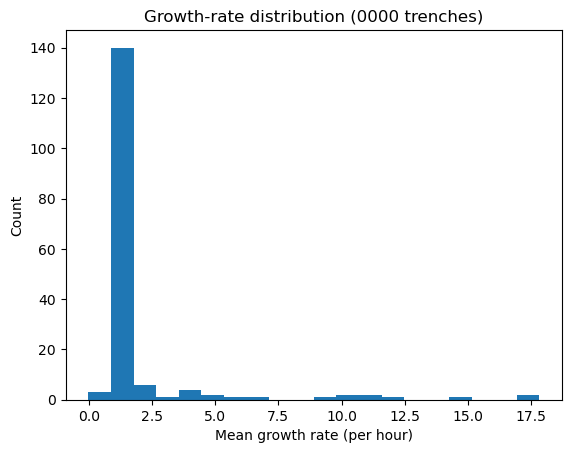

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zarr
from skimage.measure import regionprops

# --- Load data ---
z2 = zarr.open('masks_uninduced_all_2.zarr', mode='r')  
selected_df = pd.read_csv('D:/PRISM/growth_rate/growth_0000_selected_trenches.csv')
selected = selected_df['trench_id'].tolist()

# --- Parameters ---
start_frame = 2
end_frame   = 30
dt_min      = 3.0   # minutes per frame

results = []
for trench in selected:
    # 1) build length trajectory
    L = []
    for fr in range(start_frame, end_frame+1):
        mask = z2[trench, fr, 0]
        props = regionprops(mask.astype(int))
        if props:
            minr, _, maxr, _ = props[0].bbox
            L.append(maxr - minr)
        else:
            L.append(np.nan)
    L = np.array(L, float)

    # 2) split at divisions (<70% rule) and fit exponentials
    rates_min = []   # will store slopes in per‐minute units
    seg0 = 0
    for i in range(1, len(L)):
        if (~np.isnan(L[i]) and ~np.isnan(L[i-1])
            and L[i] < 0.7 * L[i-1]):
            seg1 = i-1
            t_idx = np.arange(seg0, seg1+1)
            t_min = t_idx * dt_min              # time in minutes
            segL  = L[seg0:seg1+1]
            ok    = ~np.isnan(segL)
            if ok.sum() >= 2:
                # fit log‐linear: log L = log L0 + r * t_min
                r_min = np.polyfit(t_min[ok], np.log(segL[ok]), 1)[0]
                rates_min.append(r_min)
            seg0 = i
    # last segment
    t_idx = np.arange(seg0, len(L))
    t_min = t_idx * dt_min
    segL  = L[seg0:]
    ok    = ~np.isnan(segL)
    if ok.sum() >= 2:
        r_min = np.polyfit(t_min[ok], np.log(segL[ok]), 1)[0]
        rates_min.append(r_min)

    # 3) average and convert to per‐hour if you like
    mean_r_min = np.nanmean(rates_min)
    mean_r_hr  = mean_r_min * 60.0

    results.append({
      'trench_id': trench,
      'mean_rate_per_min': mean_r_min,
      'mean_rate_per_hr':  mean_r_hr
    })

# --- save and plot ---
df = pd.DataFrame(results)
df.to_csv('D:/PRISM/growth_rate/trench_growth0000_rates_timescaled.csv', index=False)

plt.figure()
plt.hist(df['mean_rate_per_hr'].dropna(), bins=20)
plt.xlabel('Mean growth rate (per hour)')
plt.ylabel('Count')
plt.title('Growth‐rate distribution (0000 trenches)')
plt.show()


### finding for 1111

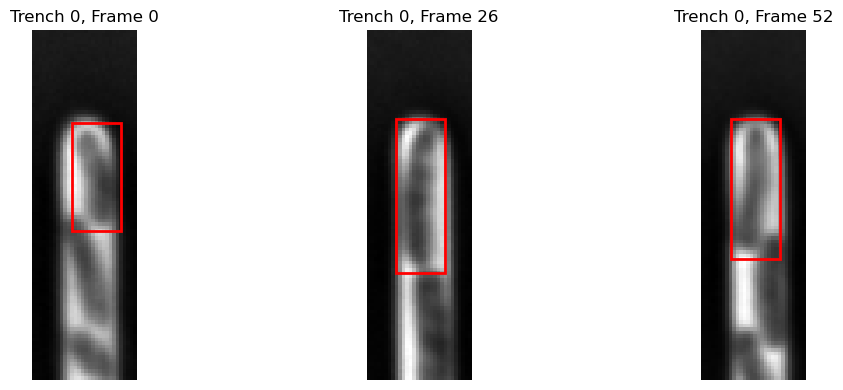

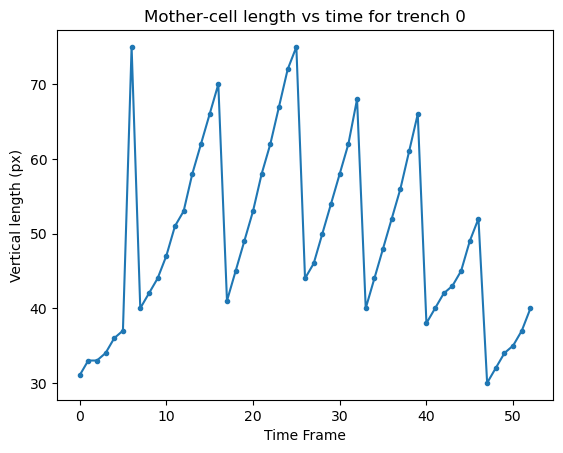

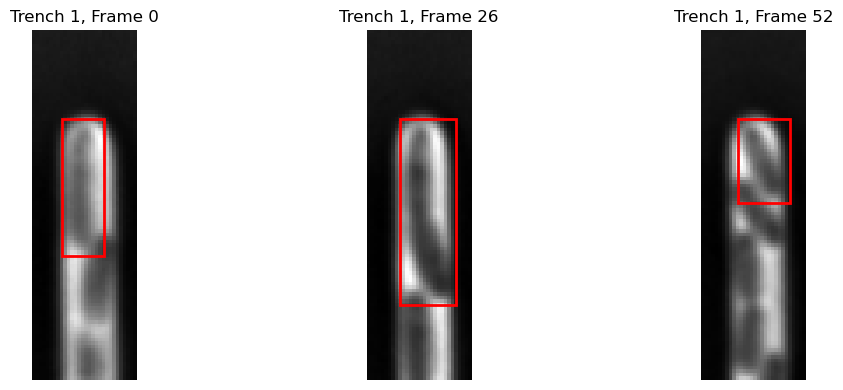

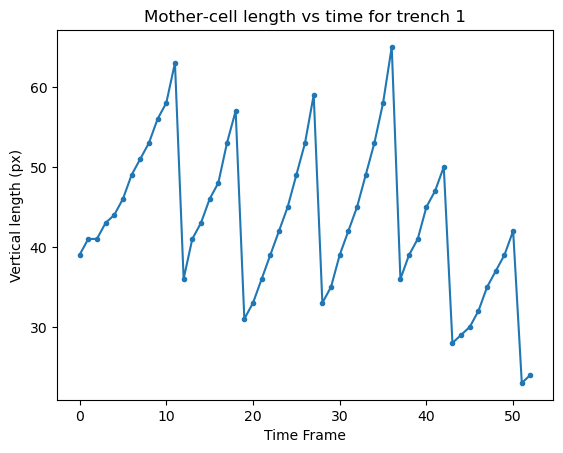

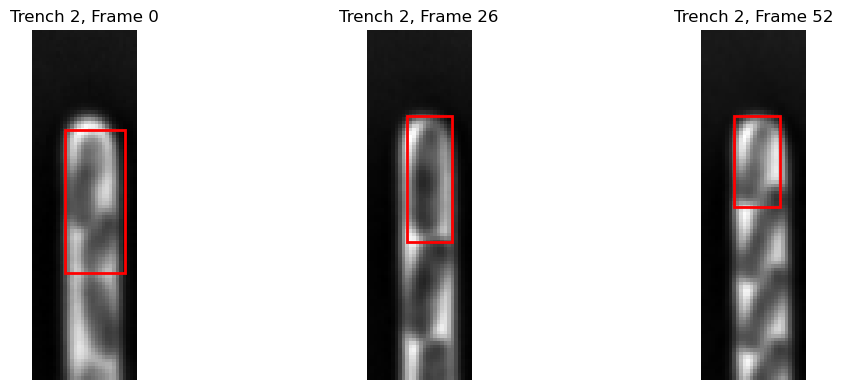

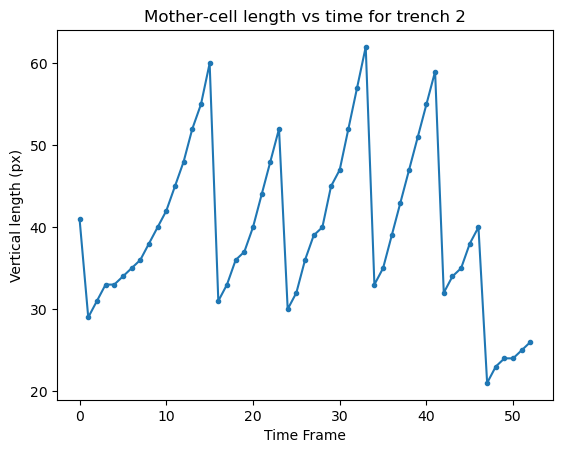

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import zarr
from skimage.measure import regionprops
from matplotlib.patches import Rectangle

# --- Load your data ---
z1 = zarr.open('D:/PRISM/trenches_1111growth.zarr', mode='r')      # phase‐contrast (C=0)
z2 = zarr.open('masks_uninduced_all_2.zarr', mode='r')            # masks (C=0 contains the mother‐cell mask)

# --- Parameters ---
trenches_to_plot = [0, 1, 2]
n_frames = z2.shape[1]  # number of timepoints

for trench in trenches_to_plot:
    # 1) Show bounding boxes on a few sample frames
    sample_frames = [0, n_frames//2, n_frames-1]
    plt.figure(figsize=(12, 4))
    for i, frame in enumerate(sample_frames):
        pc_img = z1[trench, frame, 0]     # phase‐contrast
        mask   = z2[trench, frame, 0]     # mother‐cell mask
        
        # find the bounding box
        props = regionprops(mask.astype(int))
        if props:
            minr, minc, maxr, maxc = props[0].bbox
        else:
            # fallback if no mask found
            minr = minc = maxr = maxc = 0
        
        ax = plt.subplot(1, len(sample_frames), i+1)
        ax.imshow(pc_img, cmap='gray')
        ax.add_patch(Rectangle(
            (minc, minr),
            maxc-minc, maxr-minr,
            edgecolor='red', facecolor='none', lw=2
        ))
        ax.set_title(f'Trench {trench}, Frame {frame}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # 2) Compute vertical length over all frames
    lengths = []
    for frame in range(n_frames):
        mask = z2[trench, frame, 0]
        props = regionprops(mask.astype(int))
        if props:
            minr, _, maxr, _ = props[0].bbox
            lengths.append(maxr - minr)
        else:
            lengths.append(np.nan)
    
    # 3) Plot growth curve
    plt.figure()
    plt.plot(lengths, '.-')
    plt.xlabel('Time Frame')
    plt.ylabel('Vertical length (px)')
    plt.title(f'Mother‐cell length vs time for trench {trench}')
    plt.show()


manual selection of valid tracking

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import zarr
from skimage.measure import regionprops
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Load Zarr data ---
z1 = zarr.open('D:/PRISM/trenches_1111growth.zarr', mode='r')  # phase‐contrast (C=0)
z2 = zarr.open('masks_uninduced_all_2.zarr', mode='r')        # masks (C=0 mother‐cell)

n_trenches = z2.shape[0]
n_frames = z2.shape[1]

# --- Precompute vertical lengths for each trench & frame ---
lengths = np.full((n_trenches, n_frames), np.nan)
for trench in range(n_trenches):
    for frame in range(n_frames):
        mask = z2[trench, frame, 0]
        props = regionprops(mask.astype(int))
        if props:
            minr, _, maxr, _ = props[0].bbox
            lengths[trench, frame] = maxr - minr

# --- Interactive widget setup ---
plots_per_page = 20
max_page = int(np.ceil(n_trenches / plots_per_page)) - 1
selected = [True] * n_trenches  # default: use all

out = widgets.Output()
page = 0

def show_page(page_idx):
    start = page_idx * plots_per_page
    end = min(start + plots_per_page, n_trenches)
    out.clear_output()
    with out:
        # Plot grid of 20 growth curves
        fig, axs = plt.subplots(5, 4, figsize=(12, 10))
        for idx, trench in enumerate(range(start, end)):
            ax = axs.flat[idx]
            ax.plot(lengths[trench], '.-')
            ax.set_title(f'Trench {trench}')
            ax.set_xticks([])
            ax.set_yticks([])
        # Hide unused axes
        for ax in axs.flat[end-start:]:
            ax.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Display checkboxes for this page
        cbs = []
        for trench in range(start, end):
            cb = widgets.Checkbox(value=selected[trench], description=f'{trench}', indent=False)
            def _handler(change, trench=trench):
                selected[trench] = change['new']
            cb.observe(_handler, names='value')
            cbs.append(cb)
        grid = widgets.GridBox(cbs, layout=widgets.Layout(grid_template_columns="repeat(4, 100px)"))
        display(grid)

# Navigation buttons
btn_prev = widgets.Button(description='Previous')
btn_next = widgets.Button(description='Next')
btn_save = widgets.Button(description='Save')

def on_prev(b):
    global page
    if page > 0:
        page -= 1
        show_page(page)

def on_next(b):
    global page
    if page < max_page:
        page += 1
        show_page(page)

def on_save(b):
    clear_output()
    chosen = [i for i, use in enumerate(selected) if use]
    print("Selected trenches for growth‐rate analysis:", chosen)

btn_prev.on_click(on_prev)
btn_next.on_click(on_next)
btn_save.on_click(on_save)

nav = widgets.HBox([btn_prev, btn_next, btn_save])
display(nav, out)
show_page(page)


In [12]:
# Assume `selected` is the boolean list from the widget,
# or load it if saved in your session. For demonstration:
# selected = [...]  # boolean list of length n_trenches

# Compute the chosen trench IDs
chosen = [i for i, use in enumerate(selected) if use]

# Save to a CSV file
outfile = 'D:/PRISM/growth_rate/growth_1111_selected_trenches.csv'
with open(outfile, 'w') as f:
    f.write('trench_id\n')
    for tid in chosen:
        f.write(f"{tid}\n")

print(f"Exported {len(chosen)} trench IDs to {outfile}")

Exported 192 trench IDs to D:/PRISM/growth_rate/growth_1111_selected_trenches.csv


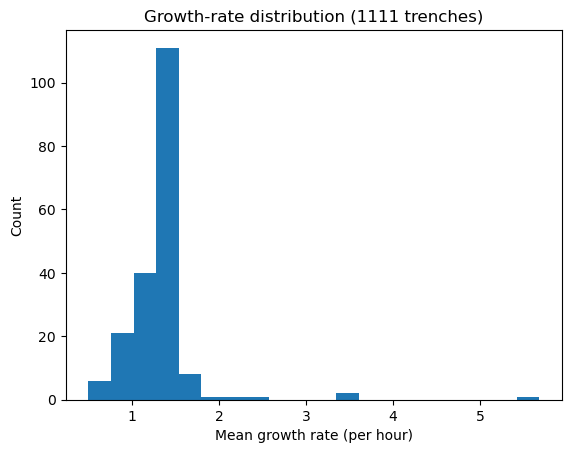

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zarr
from skimage.measure import regionprops

# --- Load data ---
z2 = zarr.open('masks_uninduced_all_2.zarr', mode='r')  
selected_df = pd.read_csv('D:/PRISM/growth_rate/growth_1111_selected_trenches.csv')
selected = selected_df['trench_id'].tolist()

# --- Parameters ---
start_frame = 5
end_frame   = 45
dt_min      = 3.0   # minutes per frame

results = []
for trench in selected:
    # 1) build length trajectory
    L = []
    for fr in range(start_frame, end_frame+1):
        mask = z2[trench, fr, 0]
        props = regionprops(mask.astype(int))
        if props:
            minr, _, maxr, _ = props[0].bbox
            L.append(maxr - minr)
        else:
            L.append(np.nan)
    L = np.array(L, float)

    # 2) split at divisions (<70% rule) and fit exponentials
    rates_min = []   # will store slopes in per‐minute units
    seg0 = 0
    for i in range(1, len(L)):
        if (~np.isnan(L[i]) and ~np.isnan(L[i-1])
            and L[i] < 0.7 * L[i-1]):
            seg1 = i-1
            t_idx = np.arange(seg0, seg1+1)
            t_min = t_idx * dt_min              # time in minutes
            segL  = L[seg0:seg1+1]
            ok    = ~np.isnan(segL)
            if ok.sum() >= 2:
                # fit log‐linear: log L = log L0 + r * t_min
                r_min = np.polyfit(t_min[ok], np.log(segL[ok]), 1)[0]
                rates_min.append(r_min)
            seg0 = i
    # last segment
    t_idx = np.arange(seg0, len(L))
    t_min = t_idx * dt_min
    segL  = L[seg0:]
    ok    = ~np.isnan(segL)
    if ok.sum() >= 2:
        r_min = np.polyfit(t_min[ok], np.log(segL[ok]), 1)[0]
        rates_min.append(r_min)

    # 3) average and convert to per‐hour if you like
    mean_r_min = np.nanmean(rates_min)
    mean_r_hr  = mean_r_min * 60.0

    results.append({
      'trench_id': trench,
      'mean_rate_per_min': mean_r_min,
      'mean_rate_per_hr':  mean_r_hr
    })

# --- save and plot ---
df = pd.DataFrame(results)
df.to_csv('D:/PRISM/growth_rate/trench_growth1111_rates_timescaled.csv', index=False)

plt.figure()
plt.hist(df['mean_rate_per_hr'].dropna(), bins=20)
plt.xlabel('Mean growth rate (per hour)')
plt.ylabel('Count')
plt.title('Growth‐rate distribution (1111 trenches)')
plt.show()


### merge and plot for both cell types

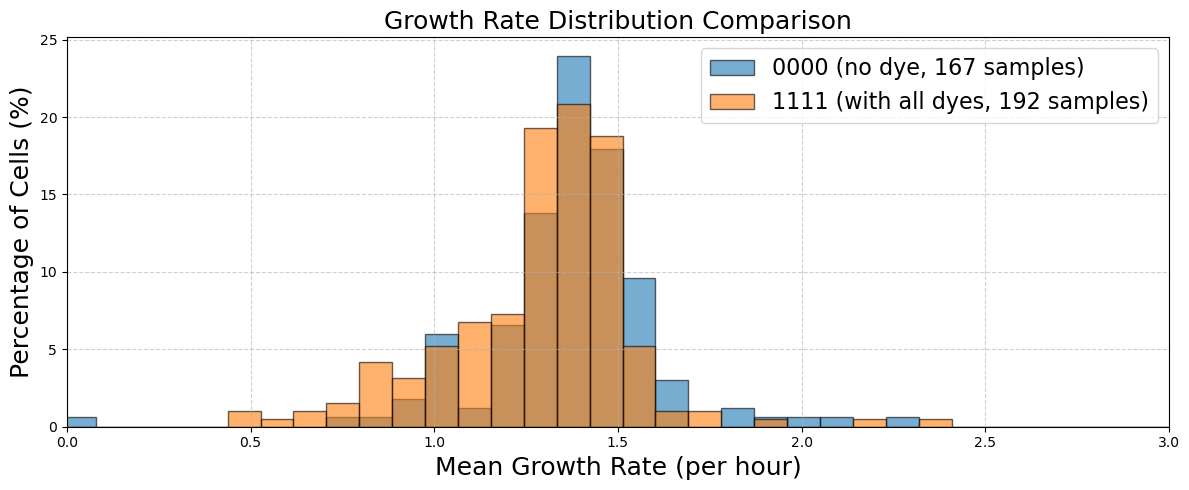

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load CSVs for both conditions ---
df0000 = pd.read_csv('D:/PRISM/growth_rate/trench_growth0000_rates_timescaled.csv')
df1111 = pd.read_csv('D:/PRISM/growth_rate/trench_growth1111_rates_timescaled.csv')

# Drop NaN values
rates0000 = df0000['mean_rate_per_hr'].dropna()
rates1111 = df1111['mean_rate_per_hr'].dropna()

# Define common bins
all_rates = pd.concat([rates0000, rates1111])
bins = np.linspace(all_rates.min(), all_rates.max(), 200)

# Plot percentage histograms
plt.figure(figsize=(12, 5))
plt.hist(rates0000, bins=bins, weights=np.ones(len(rates0000)) / len(rates0000) * 100,
         alpha=0.6, label='0000 (no dye, 167 samples)', edgecolor='black')
plt.hist(rates1111, bins=bins, weights=np.ones(len(rates1111)) / len(rates1111) * 100,
         alpha=0.6, label='1111 (with all dyes, 192 samples)', edgecolor='black')

# Labels and formatting
plt.xlabel('Mean Growth Rate (per hour)', fontsize=18)
plt.ylabel('Percentage of Cells (%)', fontsize=18)
plt.title('Growth Rate Distribution Comparison', fontsize=18)
plt.legend(fontsize=16)
plt.xlim(0,3)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

# Load both CSVs
df0000 = pd.read_csv('D:/PRISM/growth_rate/trench_growth0000_rates_timescaled.csv')
df1111 = pd.read_csv('D:/PRISM/growth_rate/trench_growth1111_rates_timescaled.csv')

# Drop NaN values in the growth rate column
valid_0000 = df0000['mean_rate_per_hr'].dropna()
valid_1111 = df1111['mean_rate_per_hr'].dropna()

# Print counts
print(f"Number of 0000 cells analyzed: {len(valid_0000)}")
print(f"Number of 1111 cells analyzed: {len(valid_1111)}")


Number of 0000 cells analyzed: 167
Number of 1111 cells analyzed: 192


In [2]:
import pandas as pd

# --- Load CSVs for both conditions ---
df0000 = pd.read_csv('D:/PRISM/growth_rate/trench_growth0000_rates_timescaled.csv')
df1111 = pd.read_csv('D:/PRISM/growth_rate/trench_growth1111_rates_timescaled.csv')

# Drop NaN values in the 'mean_rate_per_hr' column
rates0000 = df0000['mean_rate_per_hr'].dropna()
rates1111 = df1111['mean_rate_per_hr'].dropna()

# Compute the mean and standard deviation of the mean growth rates
mean_0000 = rates0000.mean()
std_0000  = rates0000.std()   # pandas default ddof=1

mean_1111 = rates1111.mean()
std_1111  = rates1111.std()

print(f"0000 (no dye):  mean = {mean_0000:.4f}  per hour,  std = {std_0000:.4f}")
print(f"1111 (with dye): mean = {mean_1111:.4f}  per hour,  std = {std_1111:.4f}")


0000 (no dye):  mean = 2.1539  per hour,  std = 2.7286
1111 (with dye): mean = 1.3340  per hour,  std = 0.4647


In [ ]:
import pandas as pd

# --- Load CSVs for both conditions ---
df0000 = pd.read_csv('D:/PRISM/growth_rate/trench_growth0000_rates_timescaled.csv')
df1111 = pd.read_csv('D:/PRISM/growth_rate/trench_growth1111_rates_timescaled.csv')

# Drop NaN values in the 'mean_rate_per_hr' column
rates0000 = df0000['mean_rate_per_hr'].dropna()
rates1111 = df1111['mean_rate_per_hr'].dropna()

# Restrict to cells with mean growth rate below 3.0 h^-1 (likely to be outliers due to segmentation errors)
filtered0000 = rates0000[rates0000 < 3.0]
filtered1111 = rates1111[rates1111 < 3.0]

# Compute the mean and standard deviation of the filtered growth rates
mean_0000 = filtered0000.mean()
std_0000  = filtered0000.std()   # pandas default ddof=1

mean_1111 = filtered1111.mean()
std_1111  = filtered1111.std()

print(f"0000 (no dye):  mean = {mean_0000:.4f}  per hour,  std = {std_0000:.4f}")
print(f"1111 (with dye): mean = {mean_1111:.4f}  per hour,  std = {std_1111:.4f}")


0000 (no dye, <3.0 h^-1):  mean = 1.3700  per hour,  std = 0.2434
1111 (with dye, <3.0 h^-1): mean = 1.2876  per hour,  std = 0.2546


plot for report

C:\Users\kastu\AppData\Local\Temp\ipykernel_139420\825476118.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t, lengths_px, '-ko', ms=4, label='Measured length', color="red")


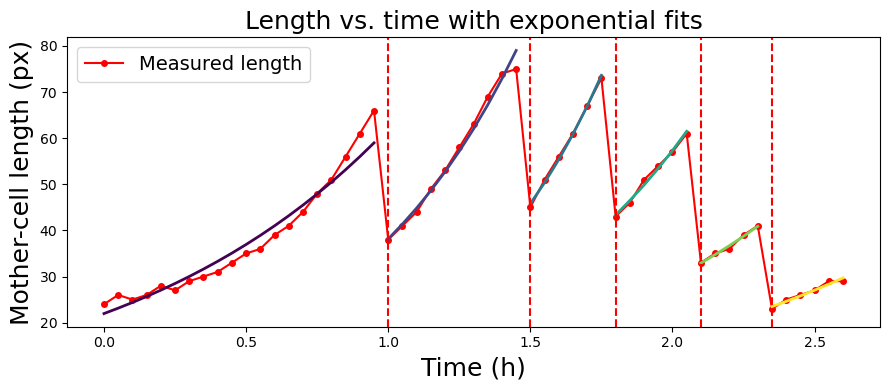

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import zarr
from skimage.measure import regionprops

# --------------------------------------------------
# 1.  LOAD DATA  (adjust paths & trench_id as needed)
# --------------------------------------------------
trench_id   = 3                      # trench to visualise
mask_store  = zarr.open('D:/PRISM/masks_uninduced_all_2.zarr', mode='r')
n_frames    = mask_store.shape[1]    # total number of timepoints

# ----------------------------------
# 2.  EXTRACT MOTHER-CELL LENGTHS
# ----------------------------------
lengths_px = []
for f in range(n_frames):
    mask = mask_store[trench_id, f, 0]            # channel-0 mask
    props = regionprops(mask.astype(int))
    if props:
        minr, _, maxr, _ = props[0].bbox
        lengths_px.append(maxr - minr)
    else:
        lengths_px.append(np.nan)
lengths_px = np.asarray(lengths_px, dtype=float)

# ----------------------------------
# 3.  DETECT DIVISION EVENTS
# ----------------------------------
div_frames = np.where(
    (lengths_px[1:] < 0.7 * lengths_px[:-1]) &
    ~np.isnan(lengths_px[1:]) & ~np.isnan(lengths_px[:-1])
)[0] + 1
seg_starts = np.insert(div_frames, 0, 0)
seg_ends   = np.append(div_frames-1, n_frames-1)

# ----------------------------------
# 4.  FIT EXPONENTIAL ON EACH SEGMENT
# ----------------------------------
t = np.arange(n_frames) * 3/60   # convert to hours (3 min/frame)
fit_curves = []
for s, e in zip(seg_starts, seg_ends):
    seg_t = t[s:e+1]
    seg_L = lengths_px[s:e+1]
    valid = ~np.isnan(seg_L)
    if valid.sum() < 2:
        continue
    μ, lnL0 = np.polyfit(seg_t[valid], np.log(seg_L[valid]), 1)
    L_hat   = np.exp(lnL0 + μ*seg_t)
    fit_curves.append((seg_t, L_hat))

# ----------------------------------
# 5.  PLOT with lines connecting dots
# ----------------------------------
plt.figure(figsize=(9,4))
# Use '-o' to connect dots with lines
plt.plot(t, lengths_px, '-ko', ms=4, label='Measured length', color="red")

# overlay fitted curves
colors = plt.cm.viridis(np.linspace(0, 1, len(fit_curves)))
for (seg_t, L_hat), col in zip(fit_curves, colors):
    plt.plot(seg_t, L_hat, color=col, lw=2)

# vertical red lines at division frames
for df in div_frames:
    plt.axvline(t[df], color='red', ls='--', lw=1.5)

plt.xlabel('Time (h)', fontsize=18)
plt.ylabel('Mother-cell length (px)', fontsize=18)
plt.title(f'Length vs. time with exponential fits', fontsize=18)
plt.tight_layout()
plt.legend(fontsize=14)
plt.show()


# Dye leakage experiment analysis

#### Nucleoid leakage test

Selection of correct segmentation

In [ ]:
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from skimage.measure import label, regionprops

# Ensure a GUI backend (e.g., TkAgg) is used for popup windows
plt.switch_backend('Qt5Agg')


# ——— Load data ———
basedir = os.getcwd()
z1 = zarr.open(os.path.join(basedir, "trenches_leaknuc.zarr"), mode="r")
z2 = zarr.open(os.path.join(basedir, "masks_uninduced_all_2.zarr"), mode="r")
channels = ["PC", "CFP", "RFP", "mVenus", "BFP"]
idx_map = {ch: i for i, ch in enumerate(channels)}

# ——— Compute normalization parameters ———
ch_min = {ch: z1[:, :, idx_map[ch], :, :].min() for ch in channels}
ch_max = {ch: z1[:, :, idx_map[ch], :, :].max() for ch in channels}

# ——— Build list of mother-cell records ———
records = []
n_trenches, n_times = z1.shape[:2]
for i in range(n_trenches):
    for t in range(n_times):
        mask_full = z2[i, t, idx_map["PC"], :, :] > 0
        if not mask_full.any(): continue
        lab = label(mask_full)
        props = regionprops(lab)
        if not props: continue
        mother_label = min(props, key=lambda p: p.centroid[0]).label
        mask = (lab == mother_label)
        # compute means
        def norm(ch): return (z1[i,t,idx_map[ch]].astype(float)-ch_min[ch])/(ch_max[ch]-ch_min[ch])
        mean_cfp, mean_yfp = norm("CFP")[mask].mean(), norm("mVenus")[mask].mean()
        cell_type = "CFP" if mean_cfp>mean_yfp else "YFP"
        records.append({"i":i,"t":t,"mask":mask,"type":cell_type})

# ——— GUI state ———
current = 0
accepted = set()

# ——— Create figure and axes ———
fig = plt.figure("Curation", figsize=(10,4))
img_axes = [fig.add_axes([0.05 + j*0.18, 0.3, 0.16, 0.6]) for j in range(5)]
ax_prev = fig.add_axes([0.05, 0.05, 0.15, 0.1])
ax_accept = fig.add_axes([0.25, 0.05, 0.15, 0.1])
ax_next = fig.add_axes([0.45, 0.05, 0.15, 0.1])
ax_finish = fig.add_axes([0.75, 0.05, 0.15, 0.1])

btn_prev = Button(ax_prev, "Previous")
btn_accept = Button(ax_accept, "Accept")
btn_next = Button(ax_next, "Next")
btn_finish = Button(ax_finish, "Finish")

def show_record(idx):
    rec = records[idx]
    mask = rec["mask"]
    fig.suptitle(f"{idx+1}/{len(records)} — trench {rec['i']}, time {rec['t']}, type {rec['type']}", fontsize=12)
    for j,ch in enumerate(channels):
        img = (z1[rec["i"], rec["t"], idx_map[ch]].astype(float)-ch_min[ch])/(ch_max[ch]-ch_min[ch])
        img_masked = np.where(mask, img, np.nan)
        ax = img_axes[j]
        ax.clear()
        ax.imshow(img_masked, vmin=0,vmax=1,cmap="gray")
        ax.set_title(ch)
        ax.axis("off")
    fig.canvas.draw_idle()

def on_prev(event):
    global current
    current = (current - 1) % len(records)
    show_record(current)

def on_accept(event):
    accepted.add(current)
    on_next(event)

def on_next(event):
    global current
    current = (current + 1) % len(records)
    show_record(current)

def on_finish(event):
    plt.close(fig)
    # Plot histograms of accepted samples
    bfp_vals = {"CFP":[], "YFP":[]}
    rfp_vals = {"CFP":[], "YFP":[]}
    for idx in accepted:
        rec = records[idx]
        mask = rec["mask"]
        norm = lambda ch: (z1[rec["i"],rec["t"],idx_map[ch]].astype(float)-ch_min[ch])/(ch_max[ch]-ch_min[ch])
        bfp_vals[rec["type"]].append(norm("BFP")[mask].mean())
        rfp_vals[rec["type"]].append(norm("RFP")[mask].mean())
    import json

    # in on_finish(), after collecting `accepted`
    accepted_recs = [records[i] for i in sorted(accepted)]
    with open("leakmem_accepted_samples.json","w") as f:
        json.dump([{"i":r["i"],"t":r["t"],"type":r["type"]} for r in accepted_recs], f)

    # BFP
    plt.figure("BFP Histogram")
    plt.hist([bfp_vals["CFP"], bfp_vals["YFP"]], bins=50, alpha=0.6, label=["CFP","YFP"])
    plt.title("BFP (accepted)"); plt.xlabel("Normalized mean"); plt.ylabel("Count"); plt.legend()
    # RFP
    plt.figure("RFP Histogram")
    plt.hist([rfp_vals["CFP"], rfp_vals["YFP"]], bins=50, alpha=0.6, label=["CFP","YFP"])
    plt.title("RFP (accepted)"); plt.xlabel("Normalized mean"); plt.ylabel("Count"); plt.legend()
    plt.show()
    

btn_prev.on_clicked(on_prev)
btn_accept.on_clicked(on_accept)
btn_next.on_clicked(on_next)
btn_finish.on_clicked(on_finish)

# Initial display
show_record(current)
plt.show()


Computed background from 111 curated images.


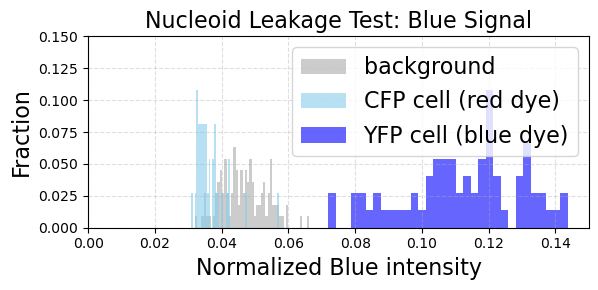

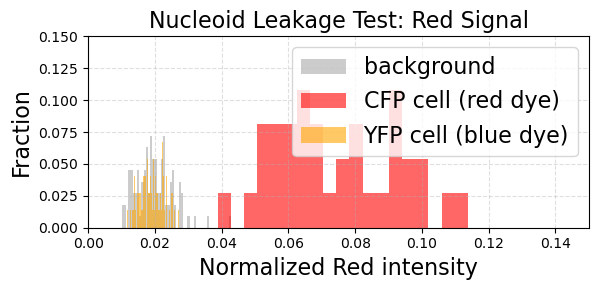

In [ ]:
# Plots Dye leakage test results
import os
import json
import zarr
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

# — User params —
FIGSIZE   = (6,3)
FONTSIZE  = 16
BINS      = 50
DATA_DIR  = os.getcwd()
ZARR_FL   = os.path.join(DATA_DIR, "trenches_leaknuc.zarr")
ZARR_MASK = os.path.join(DATA_DIR, "masks_uninduced_all_2.zarr")
ACCEPTED  = os.path.join(DATA_DIR, "accepted_samples.json")

# — Load curated list —
with open(ACCEPTED, "r") as f:
    accepted = json.load(f)

# — Open Zarr arrays —
fl   = zarr.open(ZARR_FL,   mode="r")  # (n_trench, n_time, n_ch, H, W)
mask = zarr.open(ZARR_MASK, mode="r")

# — Channel mapping & global normalization extents —
channels = ["PC","CFP","RFP","mVenus","BFP"]
idx      = {ch:i for i,ch in enumerate(channels)}
bfp_min, bfp_max = fl[:,:,idx["BFP"]].min(), fl[:,:,idx["BFP"]].max()
rfp_min, rfp_max = fl[:,:,idx["RFP"]].min(), fl[:,:,idx["RFP"]].max()

# — Collect per‐image means for cell & background —
bfp_cell = {"CFP":[], "YFP":[]}
bfp_bg   = []
rfp_cell = {"CFP":[], "YFP":[]}
rfp_bg   = []

for rec in accepted:
    i, t, typ = rec["i"], rec["t"], rec["type"]
    
    # build mother‐cell mask
    m_full = mask[i, t, idx["PC"]] > 0
    lab    = label(m_full)
    mother = min(regionprops(lab), key=lambda p:p.centroid[0]).label
    m_cell = (lab == mother)
    m_bg   = ~m_cell   # unmasked region
    
    # normalize images
    bfp_img = (fl[i,t,idx["BFP"]].astype(float) - bfp_min) / (bfp_max - bfp_min)
    rfp_img = (fl[i,t,idx["RFP"]].astype(float) - rfp_min) / (rfp_max - rfp_min)
    
    # record means
    bfp_cell[typ].append( bfp_img[m_cell].mean() )
    rfp_cell[typ].append( rfp_img[m_cell].mean() )
    bfp_bg.append( bfp_img[m_bg].mean() )
    rfp_bg.append( rfp_img[m_bg].mean() )

# — Print number of background measurements —
print(f"Computed background from {len(bfp_bg)} curated images.")

# — Prepare weights so each histogram sums to 1 —
w_cell_bfp = {
    typ: np.ones(len(bfp_cell[typ])) / len(bfp_cell[typ]) for typ in ("CFP","YFP")
}
w_bg_bfp = np.ones(len(bfp_bg)) / len(bfp_bg)

w_cell_rfp = {
    typ: np.ones(len(rfp_cell[typ])) / len(rfp_cell[typ]) for typ in ("CFP","YFP")
}
w_bg_rfp = np.ones(len(rfp_bg)) / len(rfp_bg)

# — Plot BFP: cell vs background —
plt.figure(figsize=FIGSIZE)
plt.hist(bfp_bg,           bins=BINS, weights=w_bg_bfp,        alpha=0.4, label="background", color='gray')
plt.hist(bfp_cell["CFP"], bins=BINS, weights=w_cell_bfp["CFP"], alpha=0.6, label="CFP cell (red dye)", color='skyblue')
plt.hist(bfp_cell["YFP"], bins=BINS, weights=w_cell_bfp["YFP"], alpha=0.6, label="YFP cell (blue dye)", color='blue')
plt.xlabel("Normalized Blue intensity", fontsize=FONTSIZE)
plt.ylabel("Fraction", fontsize=FONTSIZE)
plt.title("Nucleoid Leakage Test: Blue Signal", fontsize=FONTSIZE)
plt.xlim(0,0.15)
plt.ylim(0,0.15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

# — Plot RFP: cell vs background —
plt.figure(figsize=FIGSIZE)
plt.hist(rfp_bg,           bins=BINS, weights=w_bg_rfp,        alpha=0.4, label="background", color='gray')
plt.hist(rfp_cell["CFP"], bins=BINS, weights=w_cell_rfp["CFP"], alpha=0.6, label="CFP cell (red dye)", color='red')
plt.hist(rfp_cell["YFP"], bins=BINS, weights=w_cell_rfp["YFP"], alpha=0.6, label="YFP cell (blue dye)",  color='orange')
plt.xlabel("Normalized Red intensity", fontsize=FONTSIZE)
plt.ylabel("Fraction", fontsize=FONTSIZE)
plt.title("Nucleoid Leakage Test: Red Signal", fontsize=FONTSIZE)
plt.xlim(0,0.15)
plt.ylim(0,0.15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()


improve figure

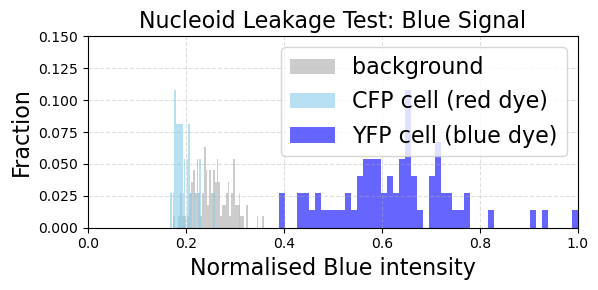

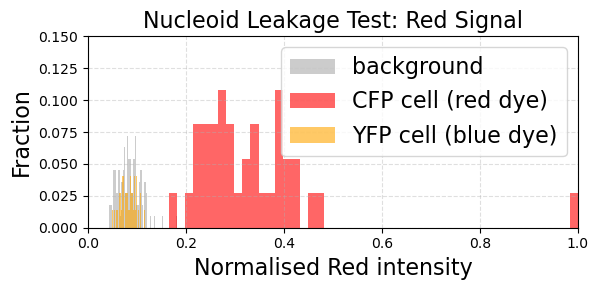

In [52]:
# — Find max‐values and normalize —
max_bfp = max(
    np.max(bfp_bg),
    np.max(bfp_cell["CFP"]),
    np.max(bfp_cell["YFP"])
)
bfp_bg_norm      = bfp_bg      / max_bfp
bfp_cell_norm = {
    "CFP": np.array(bfp_cell["CFP"]) / max_bfp,
    "YFP": np.array(bfp_cell["YFP"]) / max_bfp
}

max_rfp = max(
    np.max(rfp_bg),
    np.max(rfp_cell["CFP"]),
    np.max(rfp_cell["YFP"])
)
rfp_bg_norm      = rfp_bg      / max_rfp
rfp_cell_norm = {
    "CFP": np.array(rfp_cell["CFP"]) / max_rfp,
    "YFP": np.array(rfp_cell["YFP"]) / max_rfp
}


# — Plot BFP: cell vs background —
plt.figure(figsize=FIGSIZE)
plt.hist(bfp_bg_norm,           bins=BINS, weights=w_bg_bfp,        alpha=0.4, label="background", color='gray')
plt.hist(bfp_cell_norm["CFP"],  bins=BINS, weights=w_cell_bfp["CFP"], alpha=0.6, label="CFP cell (red dye)", color='skyblue')
plt.hist(bfp_cell_norm["YFP"],  bins=BINS, weights=w_cell_bfp["YFP"], alpha=0.6, label="YFP cell (blue dye)", color='blue')
plt.xlabel("Normalised Blue intensity", fontsize=FONTSIZE)
plt.ylabel("Fraction", fontsize=FONTSIZE)
plt.title("Nucleoid Leakage Test: Blue Signal", fontsize=FONTSIZE)
plt.xlim(0,1.0)
plt.ylim(0,0.15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

# — Plot RFP: cell vs background —
plt.figure(figsize=FIGSIZE)
plt.hist(rfp_bg_norm,           bins=BINS, weights=w_bg_rfp,        alpha=0.4, label="background", color='gray')
plt.hist(rfp_cell_norm["CFP"],  bins=BINS, weights=w_cell_rfp["CFP"], alpha=0.6, label="CFP cell (red dye)", color='red')
plt.hist(rfp_cell_norm["YFP"],  bins=BINS, weights=w_cell_rfp["YFP"], alpha=0.6, label="YFP cell (blue dye)",  color='orange')
plt.xlabel("Normalised Red intensity", fontsize=FONTSIZE)
plt.ylabel("Fraction", fontsize=FONTSIZE)
plt.title("Nucleoid Leakage Test: Red Signal", fontsize=FONTSIZE)
plt.xlim(0,1.0)
plt.ylim(0,0.15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()


#### membrane leakage test

In [68]:
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from skimage.measure import label, regionprops
import json

# Use your Qt backend for pop-ups
plt.switch_backend('Qt5Agg')

# ——— Load data ———
basedir = os.getcwd()
z1 = zarr.open(os.path.join(basedir, "leakage_mem_trenches.zarr"), mode="r")
z2 = zarr.open(os.path.join(basedir, "masks_uninduced_all_2.zarr"), mode="r")

channels = ['PC', 'CFP', 'mCherry3', 'mVenus', 'Dapi']
idx_map = {ch: i for i, ch in enumerate(channels)}

# ——— Compute normalization parameters ———
ch_min = {ch: z1[:, :, idx_map[ch], :, :].min() for ch in channels}
ch_max = {ch: z1[:, :, idx_map[ch], :, :].max() for ch in channels}

# ——— Build list of mother-cell records ———
records = []
n_trenches, n_times = z1.shape[:2]
for i in range(n_trenches):
    for t in range(n_times):
        mask_full = z2[i, t, idx_map["PC"], :, :] > 0
        if not mask_full.any():
            continue
        lab = label(mask_full)
        props = regionprops(lab)
        if not props:
            continue
        mother_label = min(props, key=lambda p: p.centroid[0]).label
        mask = (lab == mother_label)
        # classify CFP vs YFP
        def norm(ch):
            return (z1[i, t, idx_map[ch]].astype(float) - ch_min[ch]) / (ch_max[ch] - ch_min[ch])
        mean_cfp = norm("CFP")[mask].mean()
        mean_yfp = norm("mVenus")[mask].mean()
        cell_type = "CFP" if mean_cfp > mean_yfp else "YFP"
        records.append({"i": i, "t": t, "mask": mask, "type": cell_type})

# ——— GUI state ———
current = 0
accepted = set()

# ——— Create figure and axes ———
fig = plt.figure("Curation", figsize=(10, 4))
img_axes = [fig.add_axes([0.05 + j * 0.18, 0.3, 0.16, 0.6]) for j in range(len(channels))]
ax_prev   = fig.add_axes([0.05, 0.05, 0.15, 0.1])
ax_accept = fig.add_axes([0.25, 0.05, 0.15, 0.1])
ax_next   = fig.add_axes([0.45, 0.05, 0.15, 0.1])
ax_finish = fig.add_axes([0.75, 0.05, 0.15, 0.1])

btn_prev   = Button(ax_prev,   "Previous")
btn_accept = Button(ax_accept, "Accept")
btn_next   = Button(ax_next,   "Next")
btn_finish = Button(ax_finish, "Finish")

def show_record(idx):
    rec = records[idx]
    mask = rec["mask"]
    fig.suptitle(
        f"{idx+1}/{len(records)} — trench {rec['i']}, time {rec['t']}, type {rec['type']}",
        fontsize=12
    )
    for j, ch in enumerate(channels):
        img = (z1[rec["i"], rec["t"], idx_map[ch]].astype(float) - ch_min[ch]) / (ch_max[ch] - ch_min[ch])
        img_masked = np.where(mask, img, np.nan)
        ax = img_axes[j]
        ax.clear()
        ax.imshow(img_masked, vmin=0, vmax=1, cmap="gray")
        ax.set_title(ch)
        ax.axis("off")
    fig.canvas.draw_idle()

def on_prev(event):
    global current
    current = (current - 1) % len(records)
    show_record(current)

def on_accept(event):
    accepted.add(current)
    on_next(event)

def on_next(event):
    global current
    current = (current + 1) % len(records)
    show_record(current)

def on_finish(event):
    plt.close(fig)
    # Gather Dapi and mCherry3 means for accepted samples
    dapi_vals = {"CFP": [], "YFP": []}
    mch_vals  = {"CFP": [], "YFP": []}

    for idx in sorted(accepted):
        rec = records[idx]
        mask = rec["mask"]
        norm = lambda ch: (z1[rec["i"], rec["t"], idx_map[ch]].astype(float) - ch_min[ch]) \
                          / (ch_max[ch] - ch_min[ch])
        dapi_vals[rec["type"]].append(norm("Dapi")[mask].mean())
        mch_vals [rec["type"]].append(norm("mCherry3")[mask].mean())

    # Save accepted records
    accepted_recs = [records[i] for i in sorted(accepted)]
    with open("leakmem_accepted_samples.json", "w") as f:
        json.dump([{"i": r["i"], "t": r["t"], "type": r["type"]} for r in accepted_recs], f)

    # Plot Dapi histogram
    plt.figure("Dapi Histogram")
    plt.hist([dapi_vals["CFP"], dapi_vals["YFP"]],
             bins=50, alpha=0.6, label=["CFP", "YFP"])
    plt.title("Dapi (accepted)"); plt.xlabel("Normalized mean"); plt.ylabel("Fraction")
    plt.legend()

    # Plot mCherry3 histogram
    plt.figure("mCherry3 Histogram")
    plt.hist([mch_vals["CFP"], mch_vals["YFP"]],
             bins=50, alpha=0.6, label=["CFP", "YFP"])
    plt.title("mCherry3 (accepted)"); plt.xlabel("Normalized mean"); plt.ylabel("Fraction")
    plt.legend()

    plt.show()

btn_prev.on_clicked(on_prev)
btn_accept.on_clicked(on_accept)
btn_next.on_clicked(on_next)
btn_finish.on_clicked(on_finish)

# Initial display
show_record(current)
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 100

In [23]:
import os
import json
import zarr
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

# — User parameters —
FIGSIZE   = (6,4)
FONTSIZE  = 14
BINS      = 50
DATA_DIR  = os.getcwd()
ZARR_FL   = os.path.join(DATA_DIR, "leakage_mem_trenches.zarr")
ZARR_MASK = os.path.join(DATA_DIR, "masks_uninduced_all_2.zarr")
ACCEPTED  = os.path.join(DATA_DIR, "leakmem_accepted_samples.json")

# — Load curated samples —
with open(ACCEPTED, "r") as f:
    accepted = json.load(f)

# — Open Zarr arrays —
fl   = zarr.open(ZARR_FL,   mode="r")  # (n_trench, n_time, n_ch, H, W)
mask = zarr.open(ZARR_MASK, mode="r")

# — Channel mapping & normalization extents —
channels = ['PC','CFP','mCherry3','mVenus','Dapi']
idx      = {ch:i for i,ch in enumerate(channels)}

dapi_min, dapi_max     = fl[:,:,idx["Dapi"]].min(),    fl[:,:,idx["Dapi"]].max()
mch_min, mch_max       = fl[:,:,idx["mCherry3"]].min(),fl[:,:,idx["mCherry3"]].max()

# — Collect per‐image means for cell & background —
dapi_cell = {"CFP":[], "YFP":[]}
dapi_bg   = []
mch_cell  = {"CFP":[], "YFP":[]}
mch_bg    = []

def align_mask_to(img, m):
    """
    Align boolean mask `m` to image `img`:
    - If shapes match, return m
    - If m.T matches, return m.T
    - If m smaller, center-crop img to m's shape
    """
    if m.shape == img.shape:
        return img, m
    # try transpose
    if m.T.shape == img.shape:
        return img, m.T
    # else, crop img to m.shape, centering
    mh, mw = m.shape
    h, w   = img.shape
    dy = (h - mh) // 2
    dx = (w - mw) // 2
    if dy < 0 or dx < 0:
        raise ValueError(f"Mask {m.shape} larger than image {img.shape}")
    img_cropped = img[dy:dy+mh, dx:dx+mw]
    return img_cropped, m

for rec in accepted:
    i, t, typ = rec["i"], rec["t"], rec["type"]
    # full mask from PC
    m_full = mask[i,t,idx["PC"]] > 0
    lab    = label(m_full)
    mother = min(regionprops(lab), key=lambda p:p.centroid[0]).label
    m_cell = (lab == mother)
    m_bg   = ~m_cell

    # load raw images
    raw_dapi = fl[i,t,idx["Dapi"]].astype(float)
    raw_mch  = fl[i,t,idx["mCherry3"]].astype(float)

    # normalize
    dapi_img = (raw_dapi - dapi_min) / (dapi_max - dapi_min)
    mch_img  = (raw_mch  - mch_min)  / (mch_max  - mch_min)

    # align mask
    dapi_img, m_cell_aligned = align_mask_to(dapi_img, m_cell)
    mch_img,  _              = align_mask_to(mch_img,  m_cell)
    m_bg_aligned = ~m_cell_aligned

    # record means
    dapi_cell[typ].append(dapi_img[m_cell_aligned].mean())
    mch_cell [typ].append(mch_img [m_cell_aligned].mean())
    dapi_bg  .append(dapi_img[m_bg_aligned].mean())
    mch_bg   .append(mch_img [m_bg_aligned].mean())

# — Print number of background measurements —
print(f"Computed background from {len(dapi_bg)} curated images.")

# — Weights so histograms sum to 1 —
w_cell_dapi = {typ: np.ones(len(dapi_cell[typ]))/len(dapi_cell[typ]) for typ in dapi_cell}
w_bg_dapi   = np.ones(len(dapi_bg)) / len(dapi_bg)
w_cell_mch  = {typ: np.ones(len(mch_cell[typ]))/len(mch_cell[typ]) for typ in mch_cell}
w_bg_mch    = np.ones(len(mch_bg))    / len(mch_bg)

# — Plot Dapi distributions —
plt.figure(figsize=FIGSIZE)
plt.hist(dapi_cell["CFP"], bins=BINS, weights=w_cell_dapi["CFP"], alpha=0.6, label="CFP-strong")
plt.hist(dapi_cell["YFP"], bins=BINS, weights=w_cell_dapi["YFP"], alpha=0.6, label="YFP-strong")
plt.hist(dapi_bg,           bins=BINS, weights=w_bg_dapi,        alpha=0.6, label="background")
plt.xlabel("Normalized mean Dapi intensity", fontsize=FONTSIZE)
plt.ylabel("Fraction (sum=1)",            fontsize=FONTSIZE)
plt.title("Dapi Signal: Cell vs Background", fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

# — Plot mCherry3 distributions —
plt.figure(figsize=FIGSIZE)
plt.hist(mch_cell["CFP"], bins=BINS, weights=w_cell_mch["CFP"], alpha=0.6, label="CFP-strong")
plt.hist(mch_cell["YFP"], bins=BINS, weights=w_cell_mch["YFP"], alpha=0.6, label="YFP-strong")
plt.hist(mch_bg,            bins=BINS, weights=w_bg_mch,         alpha=0.6, label="background")
plt.xlabel("Normalized mean mCherry3 intensity", fontsize=FONTSIZE)
plt.ylabel("Fraction (sum=1)",                fontsize=FONTSIZE)
plt.title("mCherry3 Signal: Cell vs Background", fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()


Computed background from 114 curated images.


manual count

In [69]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the CSV file
file_path = r"D:\PRISM\leakage experiment - RedNucleoid.csv"
df = pd.read_csv(file_path)

# Display the column names to verify
df.columns

# Check for any unexpected non-numeric data or formatting issues
df_cleaned = df.copy()

# Drop any rows with NaNs just in case
df_cleaned.dropna(inplace=True)

# Replot using only matplotlib (no seaborn)
import numpy as np
plt.style.use('default')          # This gives white background
# Extract clean values
nucleoid_vals = df_cleaned['nucleoid red dye'].values
leaked_vals = df_cleaned['leaked red dye'].values

# Replot with counts on y-axis and a vertical line at intensity = 450
plt.figure(figsize=(10, 6))
plt.hist(nucleoid_vals, bins=20, alpha=0.5, label='Red Nucleoid Cell', edgecolor='black', color='red')
plt.hist(leaked_vals, bins=20, alpha=0.5, label='Blue Nucleoid Cell', edgecolor='black', color='orange')

# Vertical line to indicate background level
#plt.axvline(x=450, color='gray', linestyle='--', linewidth=2, label='Background ~ 450')

# Labels and aesthetics
plt.xlabel("Intensity Value", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Red signals in Red Nucleoid Cell vs Blue Nucleoid cell", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=True, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [70]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the CSV file
file_path = r"D:\PRISM\leakage experiment - BlueNucleoid.csv"
df = pd.read_csv(file_path)

# Display the column names to verify
df.columns

# Check for any unexpected non-numeric data or formatting issues
df_cleaned = df.copy()

# Drop any rows with NaNs just in case
df_cleaned.dropna(inplace=True)
# Replot using only matplotlib (no seaborn)
import numpy as np
plt.style.use('default')          # This gives white background
# Extract clean values
nucleoid_vals = df_cleaned['nucleoid blue dye'].values
leaked_vals = df_cleaned['leaked blue dye'].values

# Replot with counts on y-axis and a vertical line at intensity = 450
plt.figure(figsize=(10, 6))
plt.hist(nucleoid_vals, bins=20, alpha=0.5, label='Blue Nucleoid Cell', edgecolor='black', color='Blue')
plt.hist(leaked_vals, bins=20, alpha=0.5, label='Red Nucleoid Cell', edgecolor='black', color='skyblue')

# Vertical line to indicate background level
plt.axvline(x=220, color='gray', linestyle='--', linewidth=2, label='Background ~ 220')

# Labels and aesthetics
plt.xlabel("Intensity Value", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Blue signals in Blue Nucleoid Cell vs Red Nucleoid cell", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=True, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



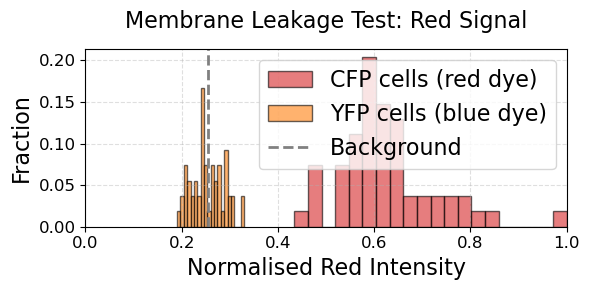

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# — Load & clean —
file_path = r"D:\PRISM\leakage experiment - RedMembrane.csv"
df = pd.read_csv(file_path).dropna()

# — Extract raw values (already in [0,1]) and background —
red_vals  = df['nucleoid red dye'].values
leak_vals = df['leaked red dye'].values
background_raw = 135  # your measured background intensity (also assumed normalized to [0,1])

# — Find the global maximum among all signals and background —
global_max = np.max([red_vals.max(), leak_vals.max(), background_raw])

# — Define scale factor as max * 5 —
scale = global_max 

# — Scale all values down by (max*5) so that the largest becomes 1/5 = 0.2 —
red_scaled  = red_vals  / scale
leak_scaled = leak_vals / scale
bg_scaled   = background_raw / scale

# — Compute weights (relative frequencies) —
w_red  = np.ones_like(red_scaled)  / len(red_scaled)
w_leak = np.ones_like(leak_scaled) / len(leak_scaled)

# — Plot —
plt.figure(figsize=(6,3))
plt.hist(red_scaled,   bins=20, weights=w_red,  alpha=0.6,
         label='CFP cells (red dye)',  edgecolor='black', color='tab:red')
plt.hist(leak_scaled,  bins=20, weights=w_leak, alpha=0.6,
         label='YFP cells (blue dye)',   edgecolor='black', color='tab:orange')

# — Vertical background line —
plt.axvline(bg_scaled, color='gray', linestyle='--', linewidth=2, label='Background')

# — Labels & style —
plt.xlabel("Normalised Red Intensity", fontsize=16)
plt.ylabel("Fraction",   fontsize=16)
plt.title("Membrane Leakage Test: Red Signal", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16, frameon=True, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)

# — Lock x-axis from 0 to 0.2 —
plt.xlim(0, 1)

plt.tight_layout()
plt.show()


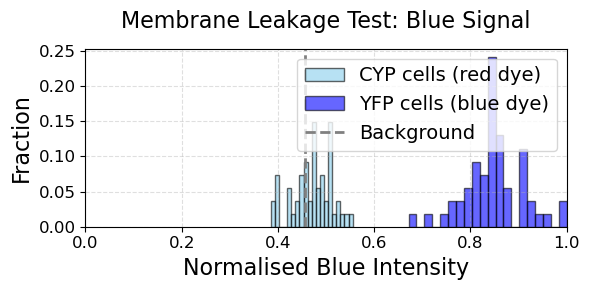

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# — Load & clean —
file_path = r"D:\PRISM\leakage experiment - Blue Membrane.csv"
df = pd.read_csv(file_path).dropna()

# — Extract raw values —
blue_vals  = df['nucleoid blue dye'].values  # cell that should have high blue
leak_vals  = df['leaked blue dye'].values    # cell that should have low blue
background = 161                              # your measured background

# — Find global max and define scale = max * 5 so max_scaled = 0.2 —
global_max = np.max([blue_vals.max(), leak_vals.max(), background])
scale = global_max

# — Scale data into [0,0.2] —
blue_scaled = blue_vals / scale
leak_scaled = leak_vals / scale
bg_scaled   = background / scale

# — Relative‐frequency weights (so bars sum to 1) —
w_blue = np.ones_like(blue_scaled) / len(blue_scaled)
w_leak = np.ones_like(leak_scaled) / len(leak_scaled)

# — Plot —
plt.figure(figsize=(6, 3))
plt.hist(blue_scaled, bins=20, weights=w_blue, alpha=0.6,
         label='CYP cells (red dye)',  edgecolor='black', color='skyblue')
plt.hist(leak_scaled, bins=20, weights=w_leak, alpha=0.6,
         label='YFP cells (blue dye)',   edgecolor='black', color='blue')

# — Vertical background line —
plt.axvline(bg_scaled, color='gray', linestyle='--', linewidth=2, label='Background')

# — Labels & style —
plt.xlabel("Normalised Blue Intensity",        fontsize=16)
plt.ylabel("Fraction",      fontsize=16)
plt.title("Membrane Leakage Test: Blue Signal", fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, frameon=True, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)

# — Lock x‐axis 0→0.2 —
plt.xlim(0, 1)

plt.tight_layout()
plt.show()


# Dye Dilution

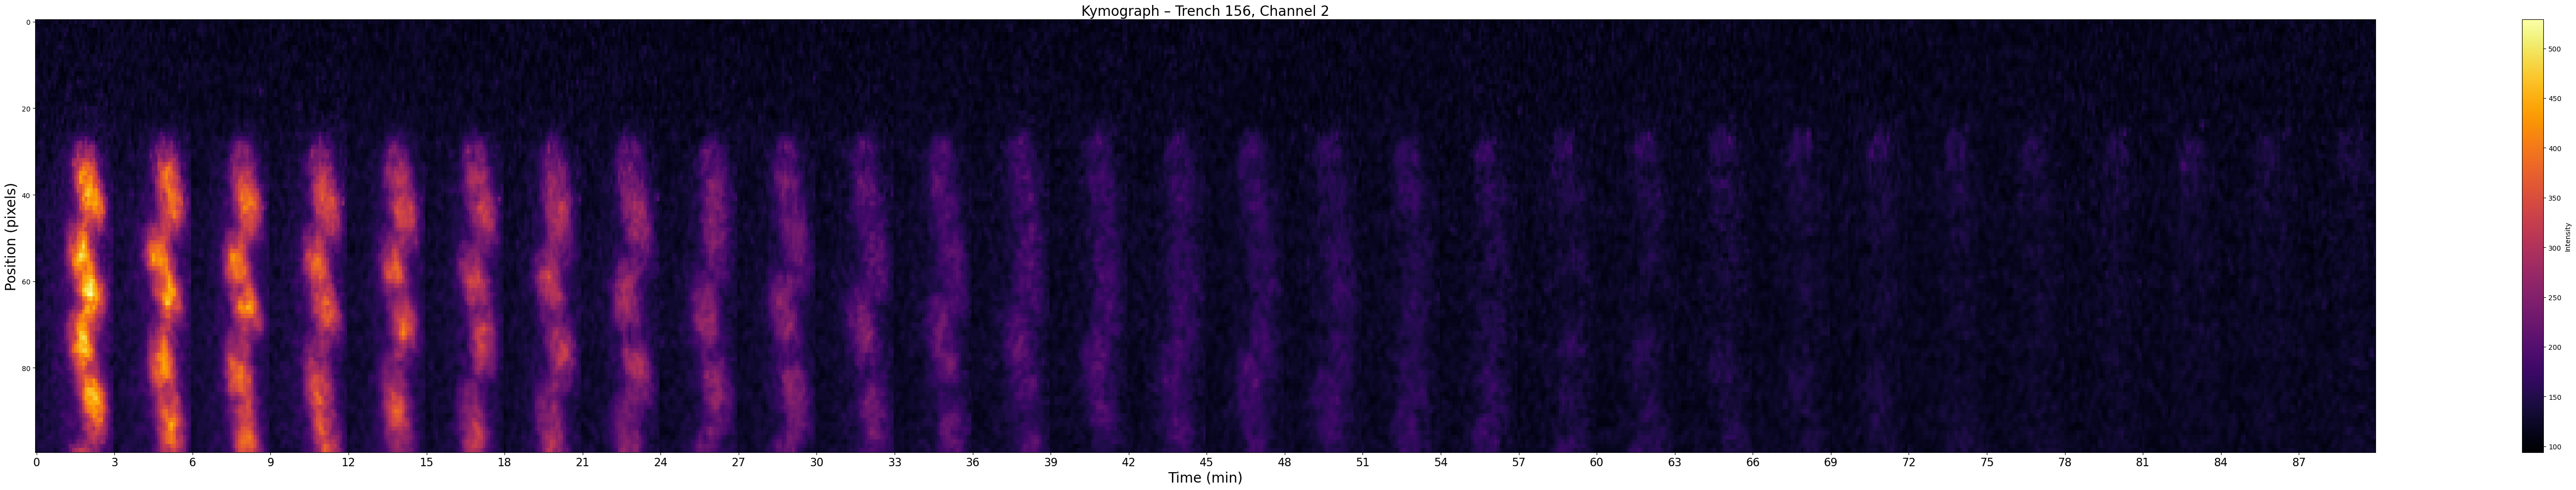

In [ ]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
plt.style.use('default')
# === Parameters ===
trench_num = 156
frame_start = 0
n_frames = 30
channel = 2  # e.g., RFP
frame_interval = 3  # in minutes

# === Load substack ===
zstack = z1[trench_num, frame_start:frame_start+n_frames, channel, :, :]  # shape: (T, H, W)

# === Stack horizontally to get a kymograph-style image ===
kymograph = np.concatenate(zstack, axis=1)  # (H, W * T)

# === Plot ===
plt.figure(figsize=(60, 10))
plt.imshow(kymograph, cmap='inferno', aspect='auto', interpolation='none')
plt.xlabel("Time (min)", fontsize=20)
plt.ylabel("Position (pixels)", fontsize=20)
xticks = np.arange(0, kymograph.shape[1], zstack.shape[2])  # one tick per frame width
xtick_labels = np.arange(frame_start, frame_start+n_frames) * frame_interval
plt.xticks(xticks, xtick_labels, fontsize=16)
plt.title(f"Kymograph – Trench {trench_num}, Channel {channel}", fontsize=20)
plt.colorbar(label='Intensity')
plt.tight_layout()
plt.show()


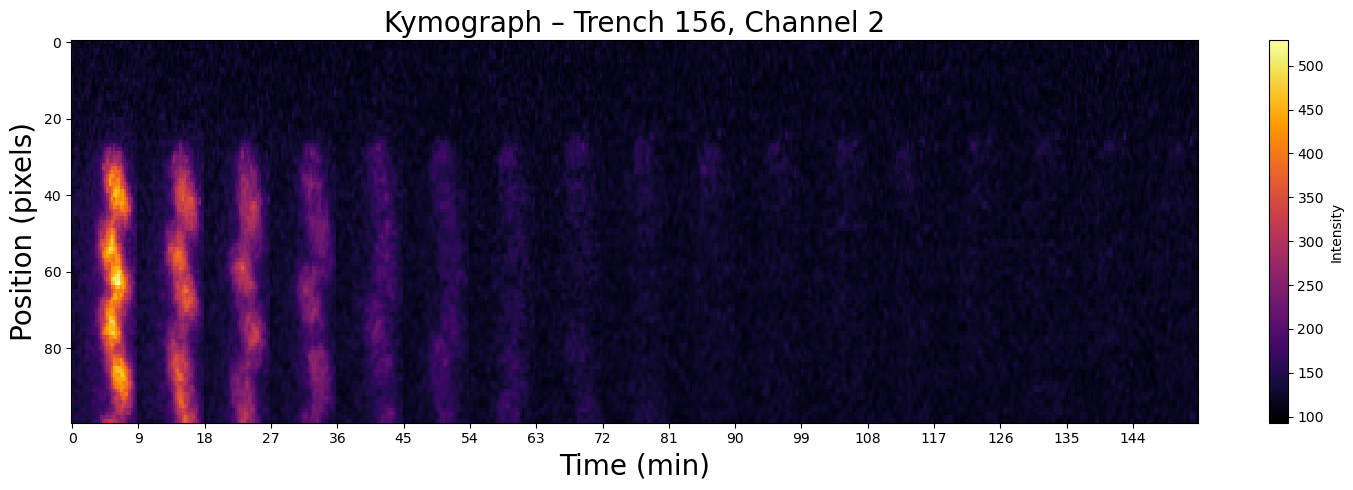

In [31]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# === Parameters ===
trench_num = 156
frame_start = 0
n_frames = 50
frame_step = 3
channel = 2  # e.g., RFP
frame_interval = 3  # 3 minutes per frame

# === Get frames: every 3rd frame ===
frame_indices = np.arange(frame_start, frame_start + n_frames, frame_step)

# === Load selected frames ===
zstack = z1[trench_num, frame_indices, channel, :, :]  # shape: (n_selected_frames, H, W)

# === Stack horizontally to make kymograph ===
kymograph = np.concatenate(zstack, axis=1)  # (H, W * n_selected_frames)

# === Plot ===
plt.figure(figsize=(15, 5))
plt.imshow(kymograph, cmap='inferno', aspect='auto', interpolation='none')
plt.xlabel("Time (min)", fontsize=20)
plt.ylabel("Position (pixels)", fontsize=20)

# X-axis ticks
xticks = np.arange(0, kymograph.shape[1], zstack.shape[2])  # tick every frame width
xtick_labels = frame_indices * frame_interval
plt.xticks(xticks, xtick_labels)

plt.title(f"Kymograph – Trench {trench_num}, Channel {channel}", fontsize=20)
plt.colorbar(label='Intensity')
plt.tight_layout()
plt.show()


# (Old version for 60x, not used for the final report) Make training data

In [463]:
import os
import numpy as np
import zarr
from skimage.transform import resize
from skimage.measure import label

# Set the base directory
basedir = os.getcwd()

# Open the adjusted images (z1_adjusted) and masks (z2) in read mode
z1_adjusted = zarr.open(os.path.join(basedir, 'z1_adjusted.zarr'), mode='r')  # Adjusted images
z2 = zarr.open(os.path.join(basedir, 'masks_uninduced_all_2.zarr'), mode='r')  # Masks

# Define the function to extract the bounding box
def extract_mother_cell_bbox(mask, margin=2):
    """
    Given a mask, return the bounding box coordinates of the top-most cell (mother cell)
    with an additional margin around it.
    """
    non_zero_coords = np.argwhere(mask > 0)
    if len(non_zero_coords) == 0:
        return None

    # Find top-most cell based on the minimum y-coordinate
    top_cell_coords = non_zero_coords[non_zero_coords[:, 0].argmin()]
    top_cell_label = mask[top_cell_coords[0], top_cell_coords[1]]

    # Get the bounding box for the mother cell
    cell_coords = np.argwhere(mask == top_cell_label)
    min_y, min_x = cell_coords.min(axis=0)
    max_y, max_x = cell_coords.max(axis=0)

    # Expand the bounding box by the specified margin
    min_y = max(min_y - margin, 0)
    max_y = min(max_y + margin, mask.shape[0] - 1)
    min_x = max(min_x - margin, 0)
    max_x = min(max_x + margin, mask.shape[1] - 1)

    return min_y, max_y, min_x, max_x

# Define the function to crop and pad images
def crop_and_pad_image(image, bbox, target_shape=(64, 36)):
    """
    Crop the image around the bounding box and pad to the target shape if it fits within the target shape.
    Move oversized images to bad images.
    """
    min_y, max_y, min_x, max_x = bbox
    cropped_image = image[min_y:max_y+1, min_x:max_x+1]

    # Check if the cropped image fits within the target shape
    crop_height, crop_width = cropped_image.shape
    if crop_height > target_shape[0] or crop_width > target_shape[1]:
        return None  # Move oversized images to bad images

    # Initialize a padded image of the target shape with zeros (background)
    padded_image = np.zeros(target_shape, dtype=cropped_image.dtype)

    # Calculate where to place the cropped image within the padded image
    start_y = (target_shape[0] - crop_height) // 2
    start_x = (target_shape[1] - crop_width) // 2

    # Insert the cropped image into the center of the padded image
    padded_image[start_y:start_y+crop_height, start_x:start_x+crop_width] = cropped_image

    return padded_image

# Main function to separate good and bad images during processing
def apply_bounding_box_and_separate(z1, z2, target_shape=(64, 36), margin=2):
    """
    Use bounding box approach to crop around the mother cell in each channel, add margin, and pad to target shape.
    Automatically separate bad images (no cells or oversized) from processed images.
    """
    processed_images = []  # Store the cropped, padded images for each trench and channel
    bad_images = []  # Store the bad images where no cells were found or oversized crops

    for i in range(z1.shape[0]):
        trench_images = []  # Store images for each channel in the current trench
        bad_trench_images = []  # Store bad images for this trench

        mask = z2[i, 0, 0, :, :]  # Assume the mask is in the first channel of z2
        bbox = extract_mother_cell_bbox(mask, margin=margin)

        if bbox is None:
            print(f"No cells found in trench {i}. Moving all channels to bad images.")
            for channel in range(z1.shape[2]):
                bad_trench_images.append(z1[i, 0, channel, :, :])
            bad_images.append(bad_trench_images)
            continue

        for channel in range(z1.shape[2]):
            img_channel = z1[i, 0, channel, :, :]  # Select the current channel
            padded_image = crop_and_pad_image(img_channel, bbox, target_shape=target_shape)  # Crop and pad
            if padded_image is None:  # If the image was oversized
                print(f"Moving oversized image in trench {i}, channel {channel} to bad images.")
                bad_trench_images.append(img_channel)
                continue
            trench_images.append(padded_image)  # Append each channel image to the trench list

        # Add good and bad images for this trench
        if trench_images:
            processed_images.append(trench_images)
        if bad_trench_images:
            bad_images.append(bad_trench_images)

    return processed_images, bad_images

# Run the bounding box, cropping, and bad image separation function
processed_images, bad_images = apply_bounding_box_and_separate(z1_adjusted, z2, target_shape=(64, 36), margin=margin)

# Print results
print(f"Number of processed trenches: {len(processed_images)}")
print(f"Number of bad trenches: {len(bad_images)}")


No cells found in trench 135. Moving all channels to bad images.
No cells found in trench 178. Moving all channels to bad images.
No cells found in trench 425. Moving all channels to bad images.
No cells found in trench 499. Moving all channels to bad images.
No cells found in trench 618. Moving all channels to bad images.
No cells found in trench 621. Moving all channels to bad images.
No cells found in trench 624. Moving all channels to bad images.
No cells found in trench 627. Moving all channels to bad images.
No cells found in trench 628. Moving all channels to bad images.
No cells found in trench 629. Moving all channels to bad images.
No cells found in trench 630. Moving all channels to bad images.
No cells found in trench 633. Moving all channels to bad images.
No cells found in trench 634. Moving all channels to bad images.
No cells found in trench 635. Moving all channels to bad images.
No cells found in trench 636. Moving all channels to bad images.
No cells found in trench 

In [164]:
import napari

# Flatten processed_images and bad_images for visualization
flattened_processed = [img for trench in processed_images for img in trench if img is not None]
flattened_bad = [img for trench in bad_images for img in trench if img is not None]

# Launch Napari viewer
viewer = napari.Viewer()

# Add processed images
viewer.add_image(np.array(flattened_processed), name="Processed Images", contrast_limits=[0, 255])

# Add bad images
viewer.add_image(np.array(flattened_bad), name="Bad Images", contrast_limits=[0, 255])

napari.run()


In [229]:



# Function to display multiple trenches across all channels
def display_trenches(trench_data, start_index, num_trenches=5):
    """
    Display multiple trenches across all channels.
    Parameters:
        trench_data (list): List of processed images for trenches.
        start_index (int): Index of the first trench to display.
        num_trenches (int): Number of trenches to display (default is 5).
    """
    end_index = min(start_index + num_trenches, len(trench_data))  # Ensure we don't exceed the list length
    
    for trench_index in range(start_index, end_index):
        num_channels = len(trench_data[trench_index])
        plt.figure(figsize=(15, 5))
        for channel in range(num_channels):
            plt.subplot(1, num_channels, channel + 1)
            plt.imshow(trench_data[trench_index][channel], cmap='gray')
            plt.title(f"Trench {trench_index} - Channel {channel}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()


# Function to move all channels of a trench to bad_images and remove it from processed_images
def move_trench_to_bad_images(trench_index):
    """
    Move all channels of a specific trench from processed_images to bad_images.
    Parameters:
        trench_index (int): Index of the trench to move.
    """
    global processed_images, bad_images
    
    # Append the specified trench to bad_images
    bad_images.append(processed_images[trench_index])
    
    # Remove the specified trench from processed_images
    del processed_images[trench_index]
    
    print(f"Moved Trench {trench_index} (all channels) to bad_images and removed it from processed_images.")



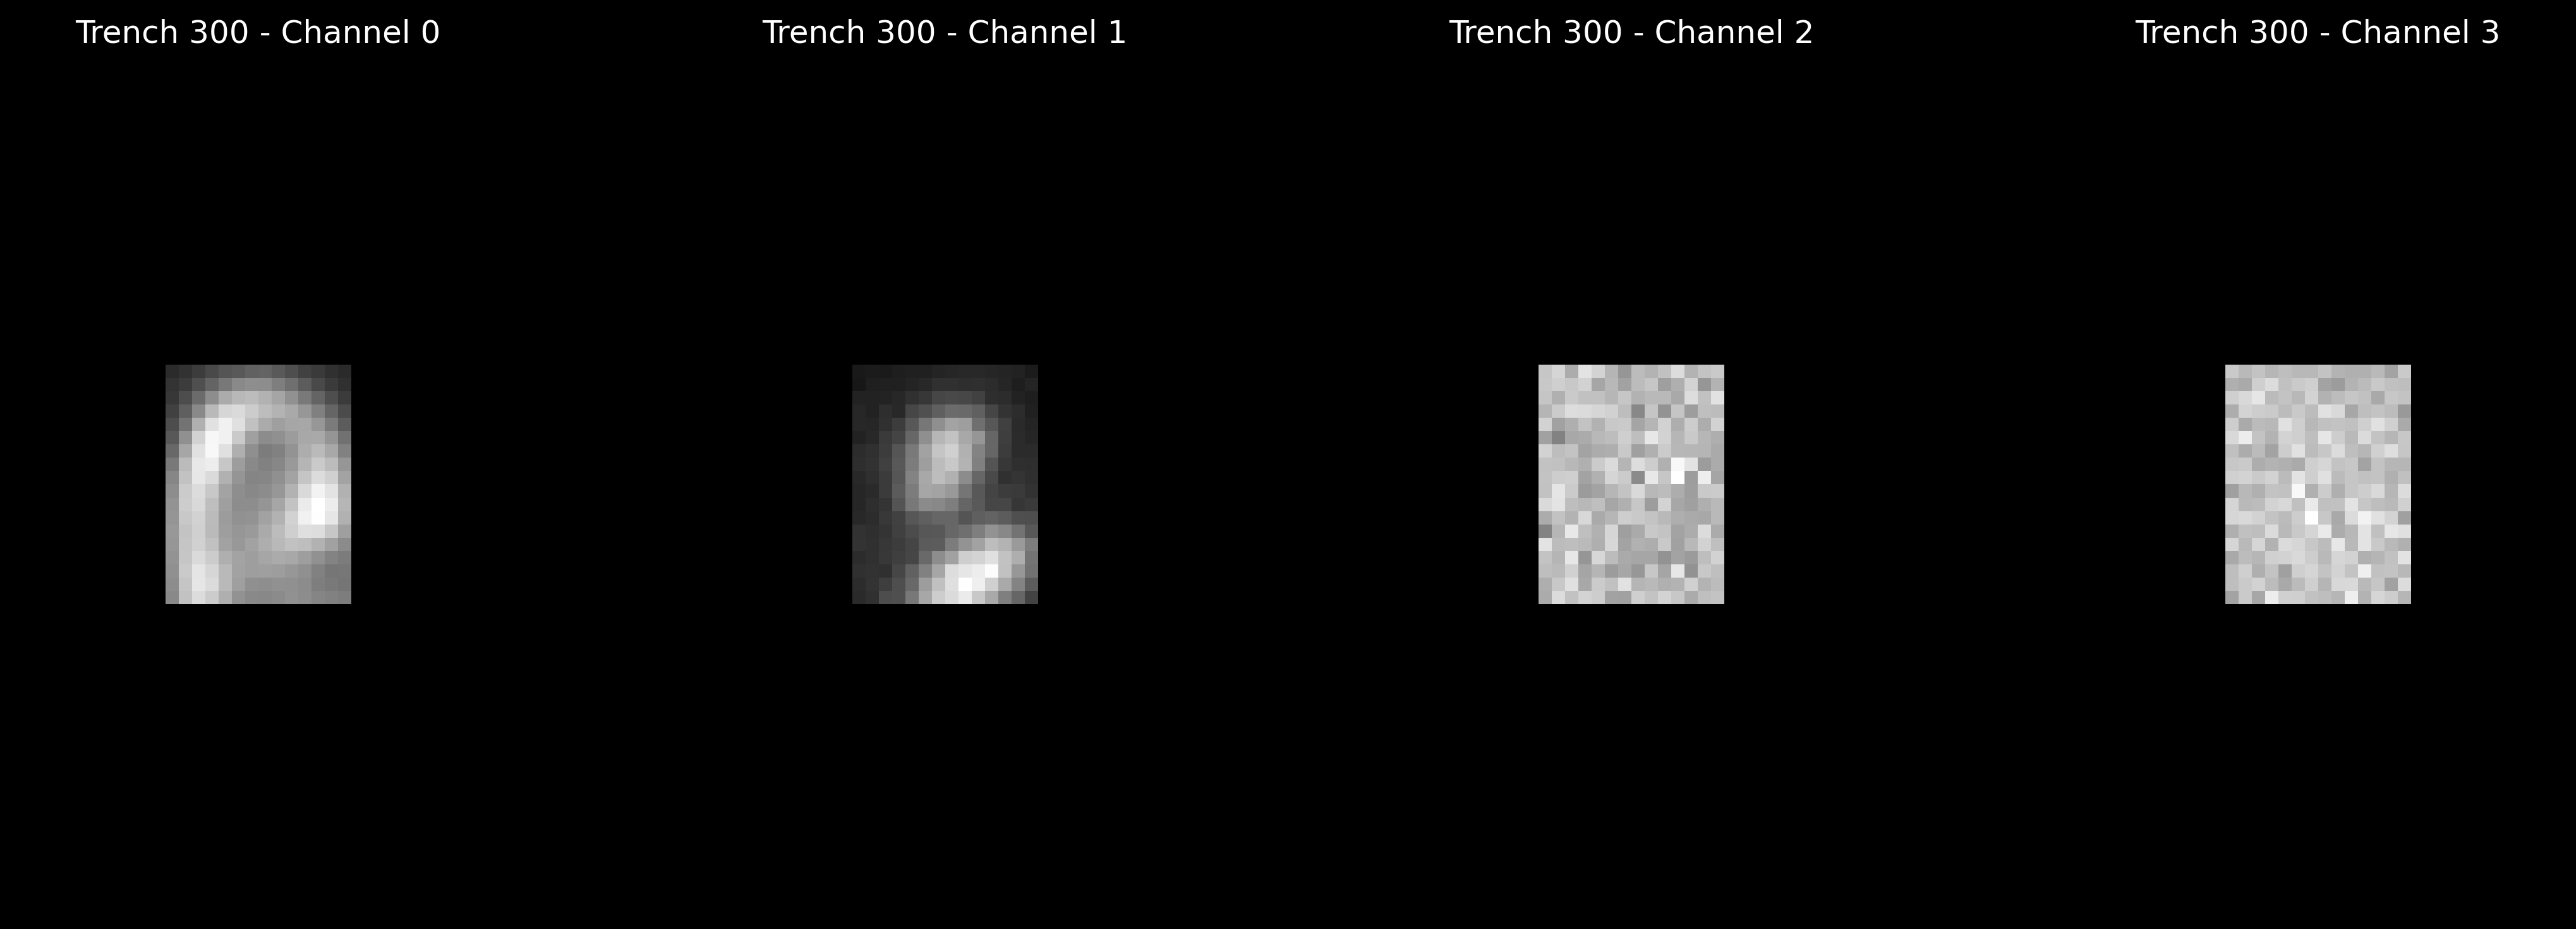

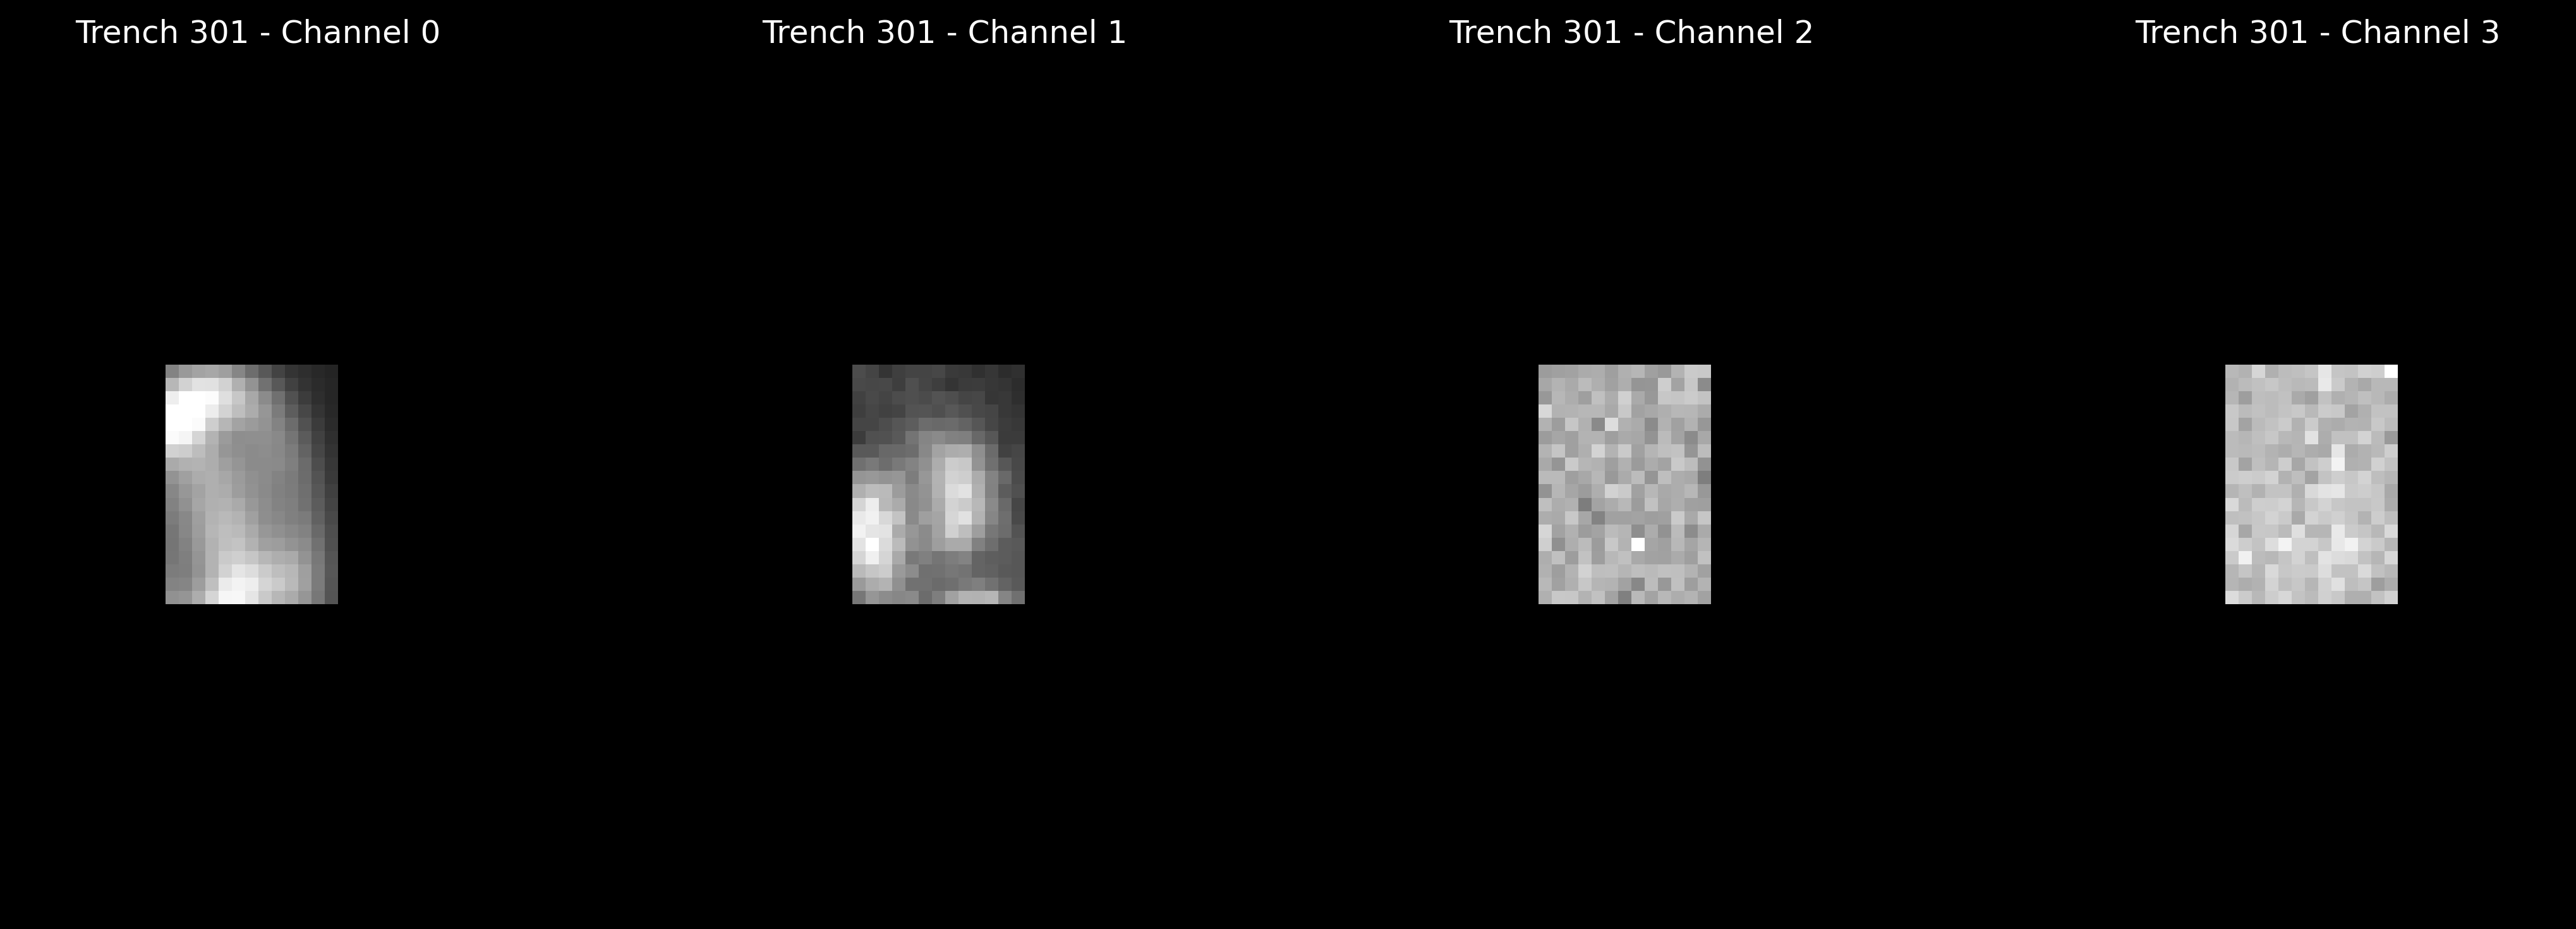

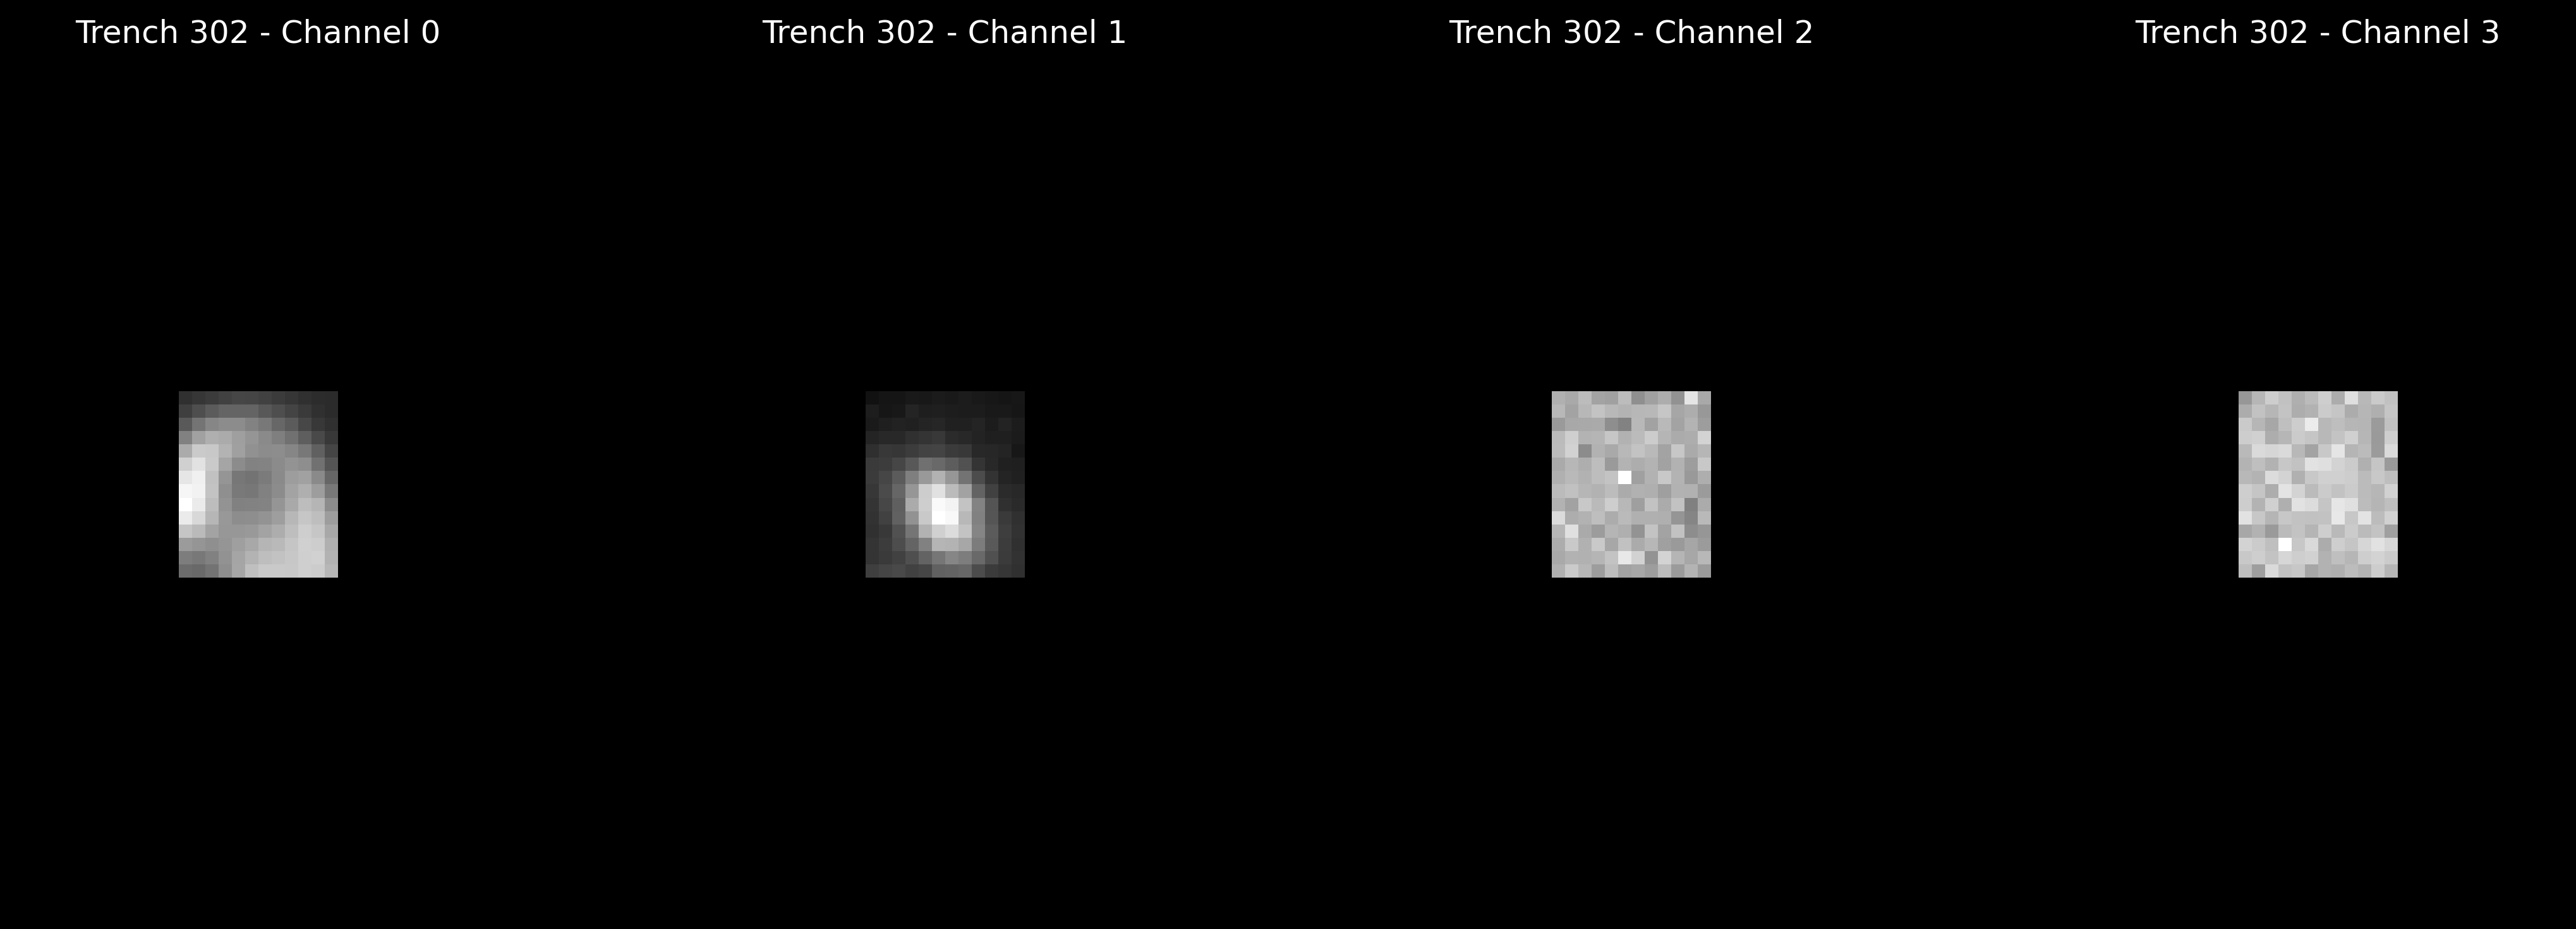

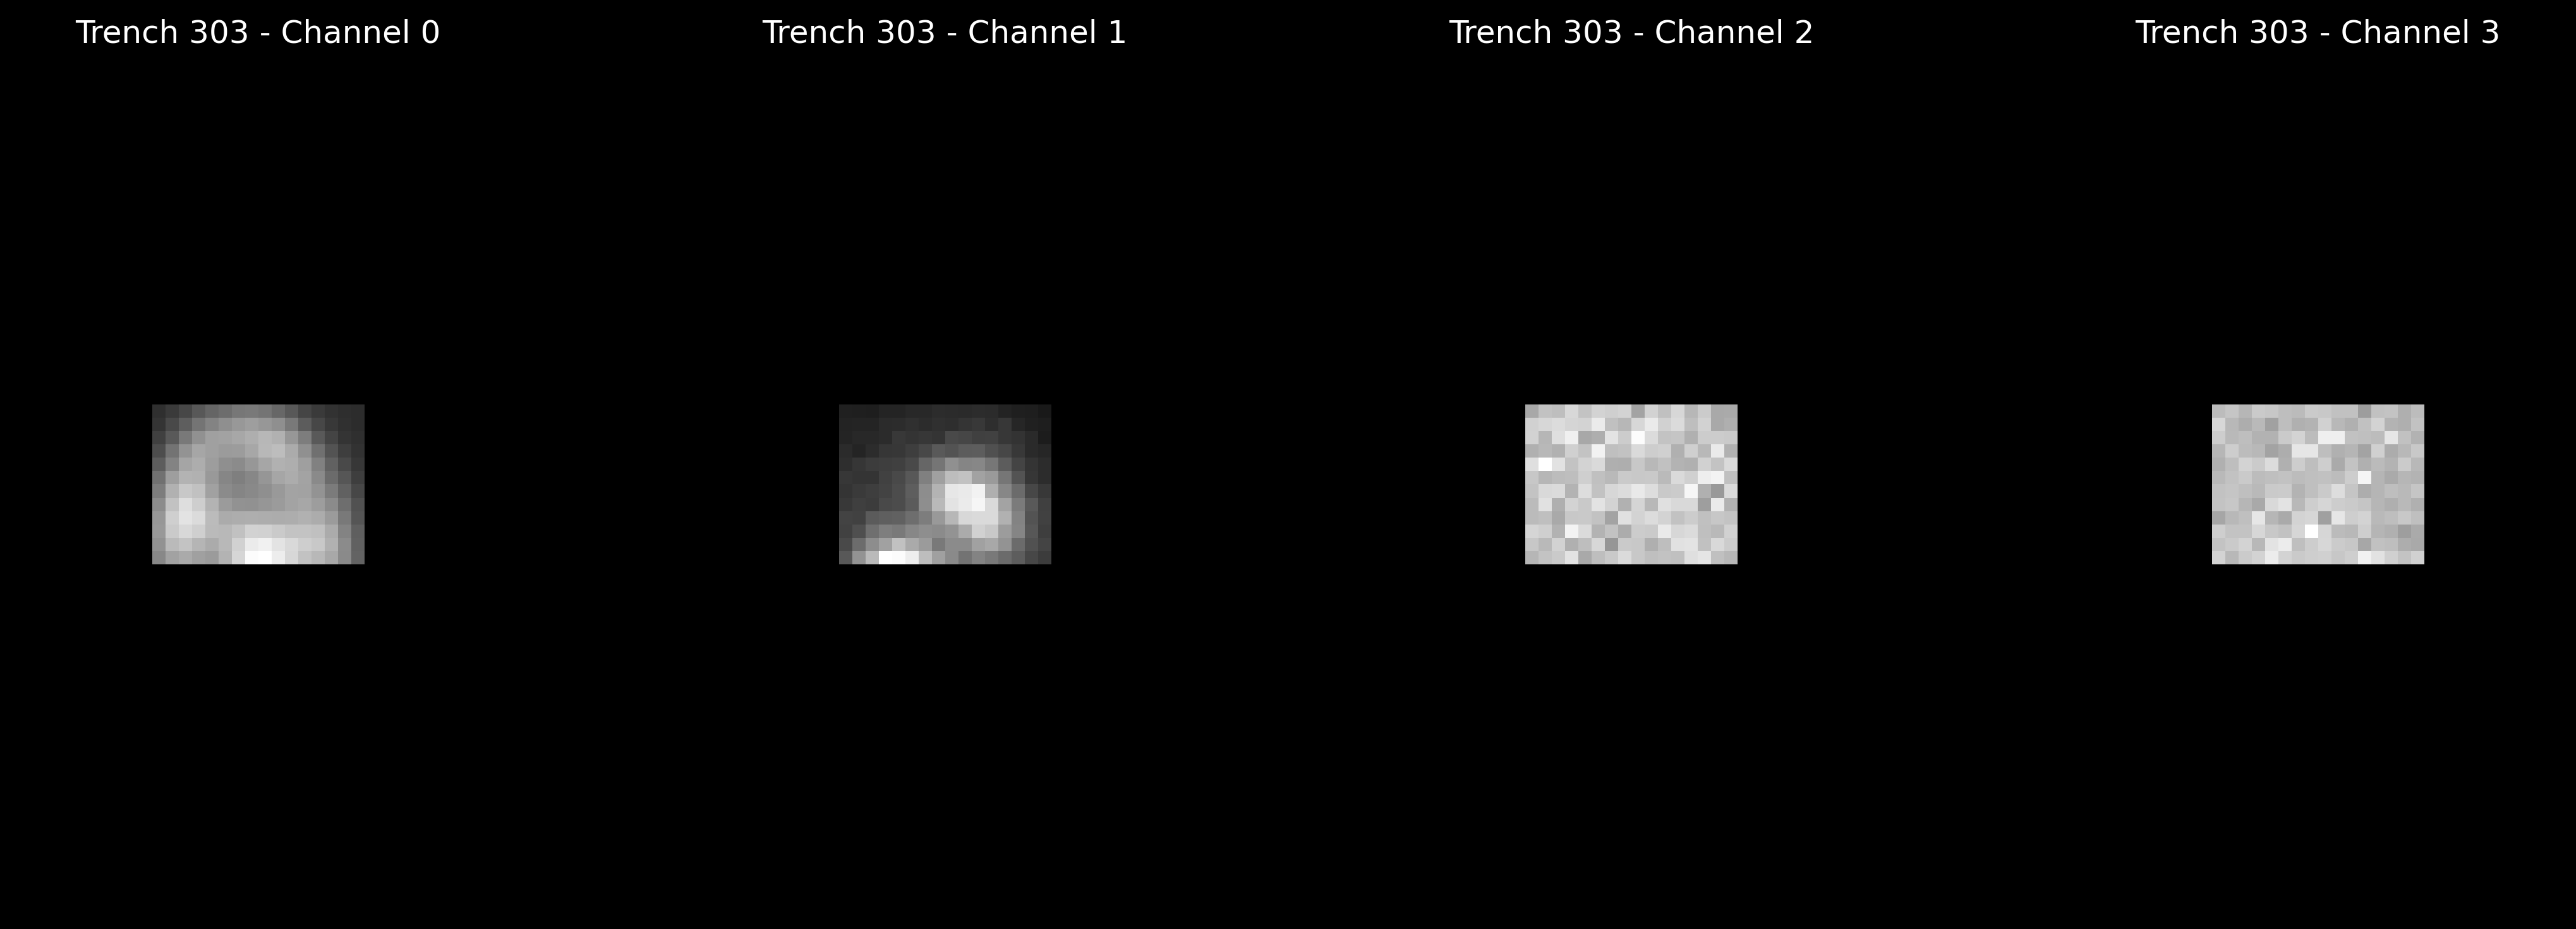

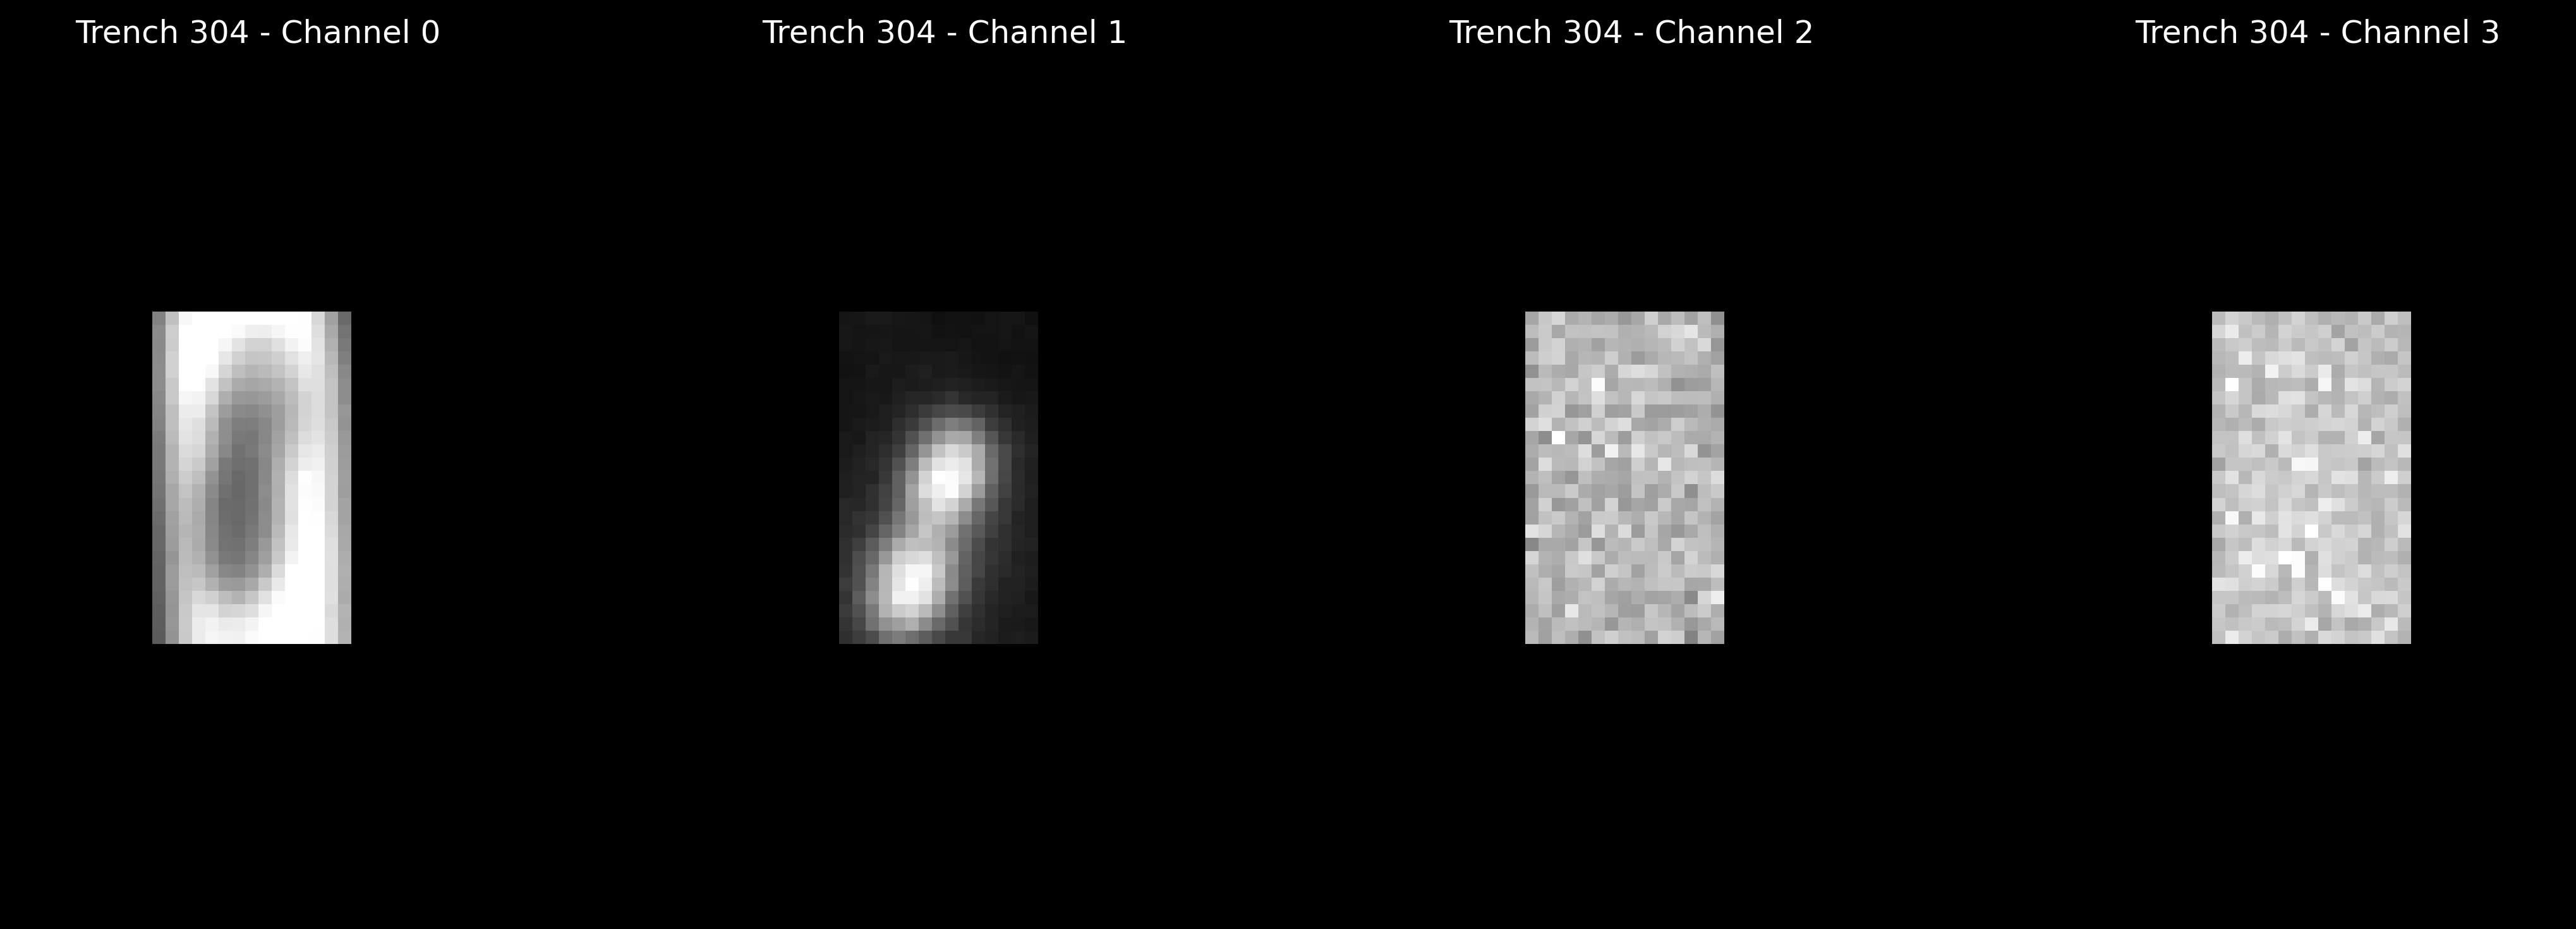

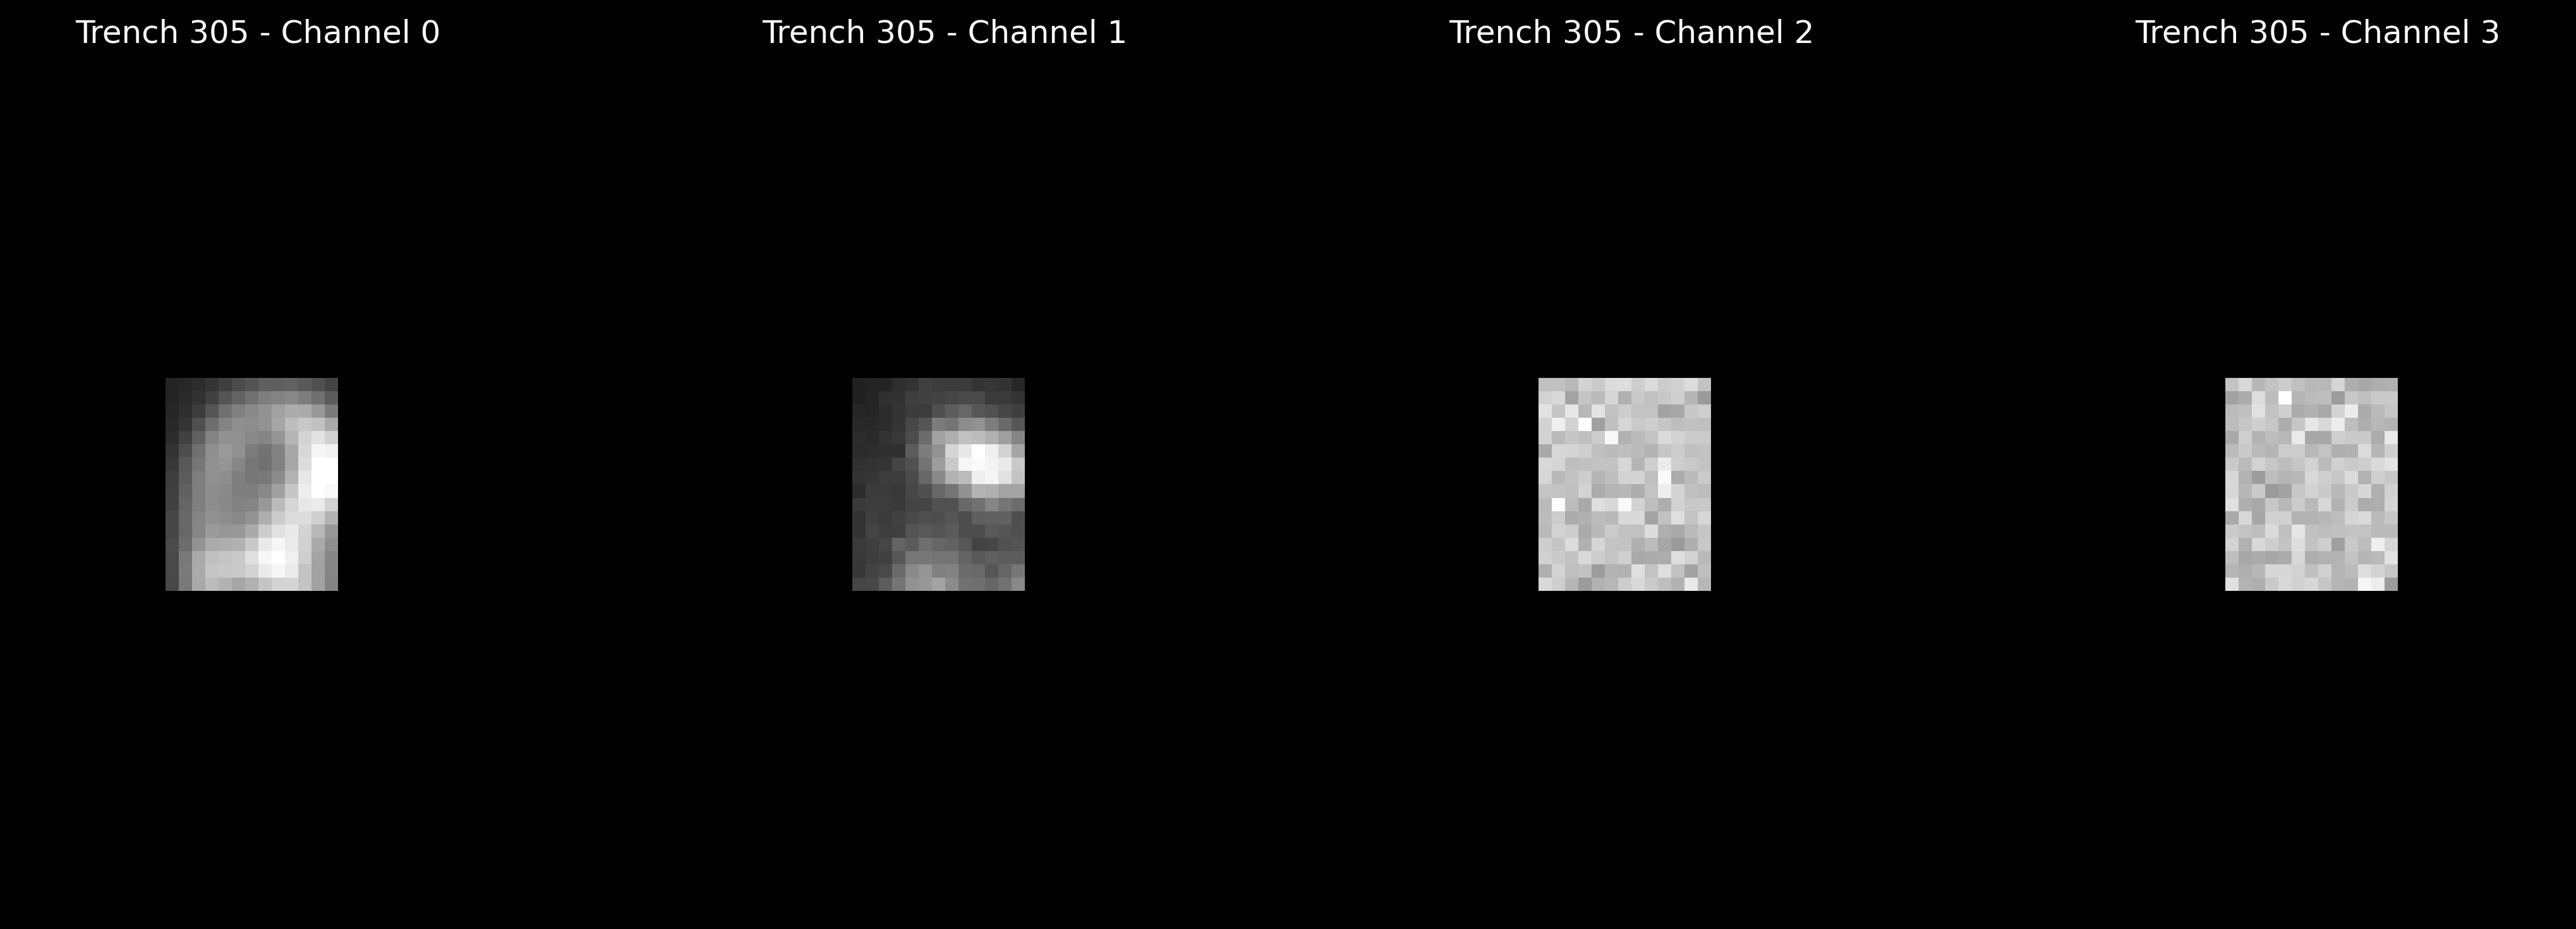

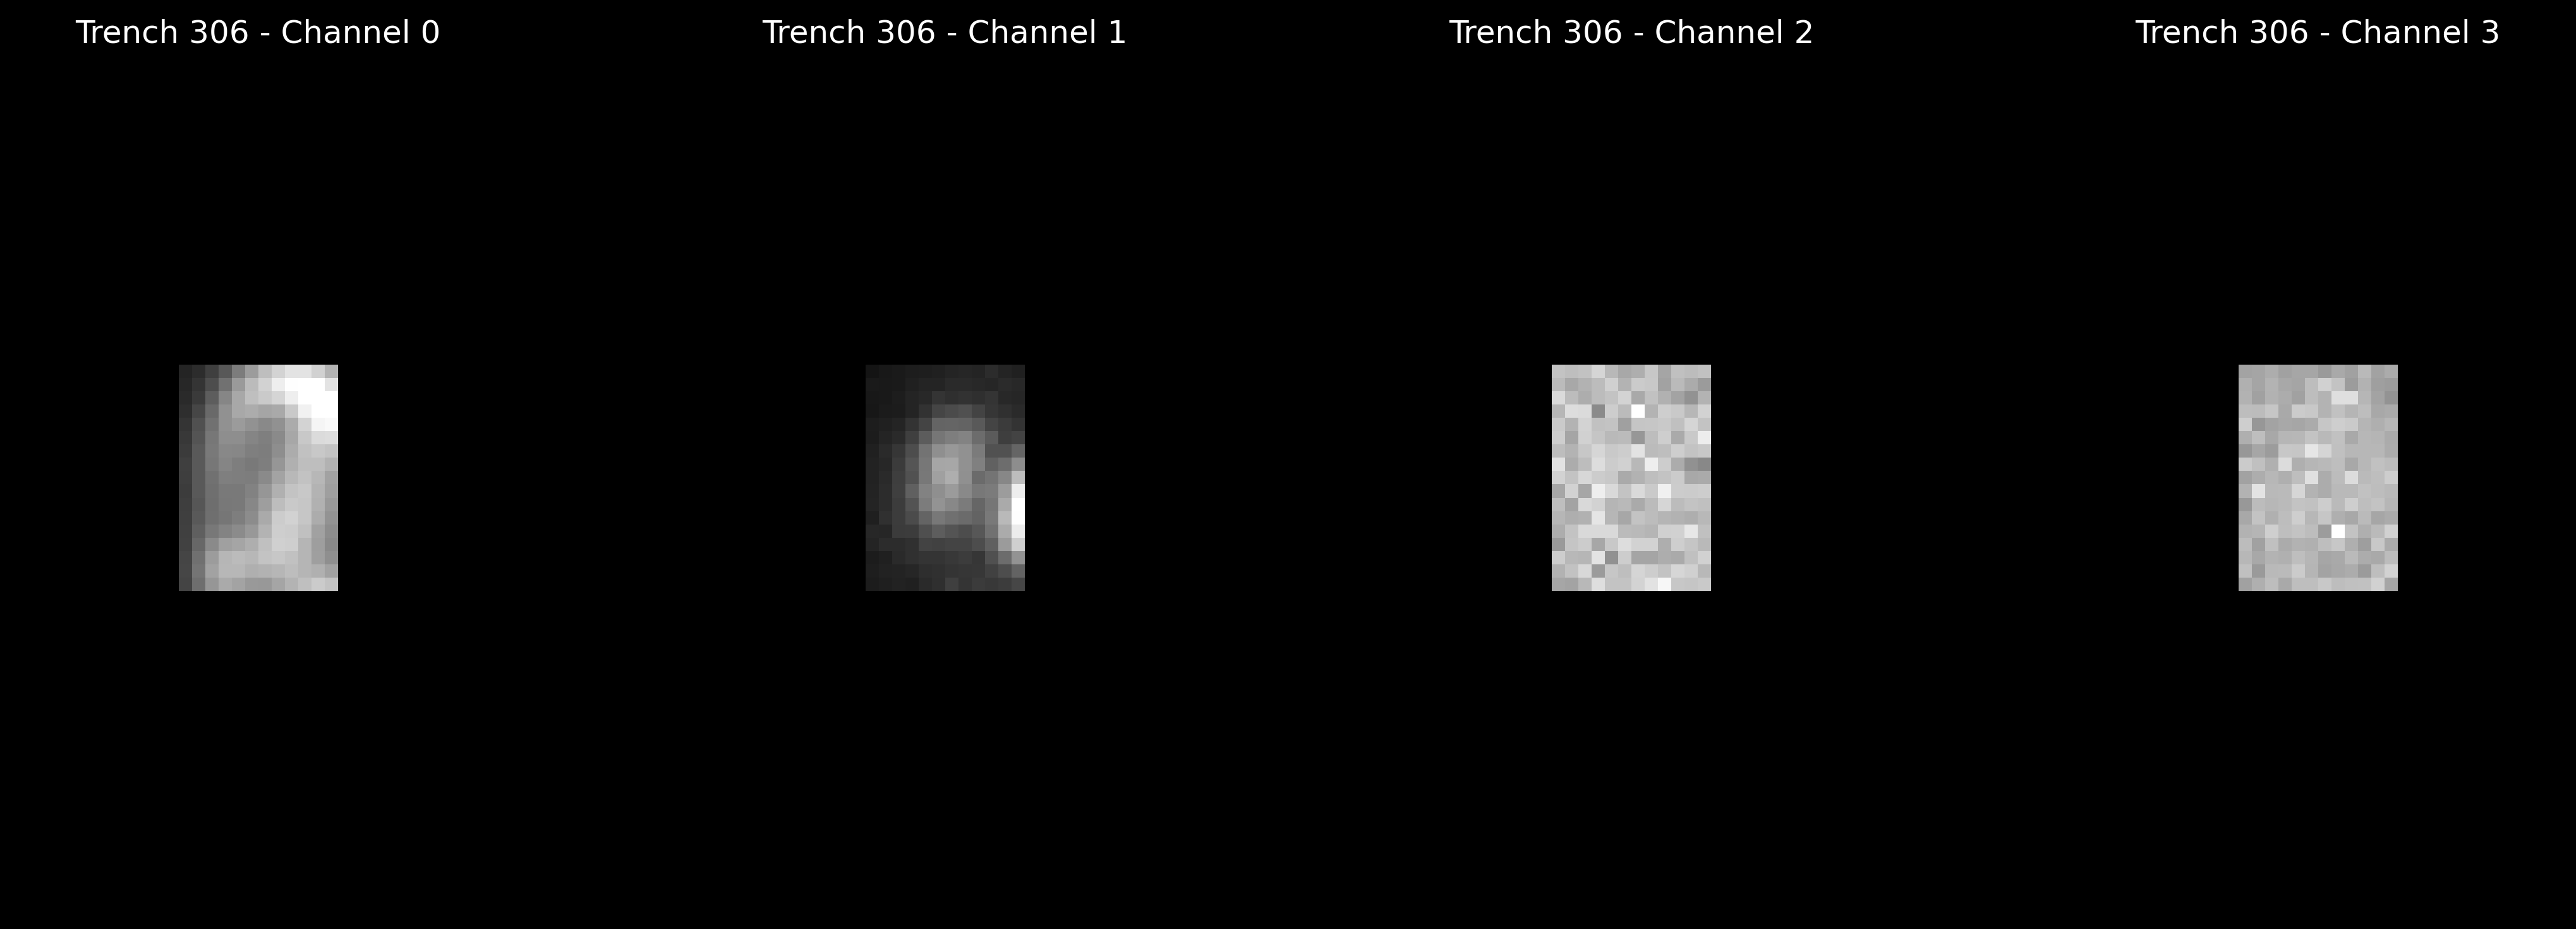

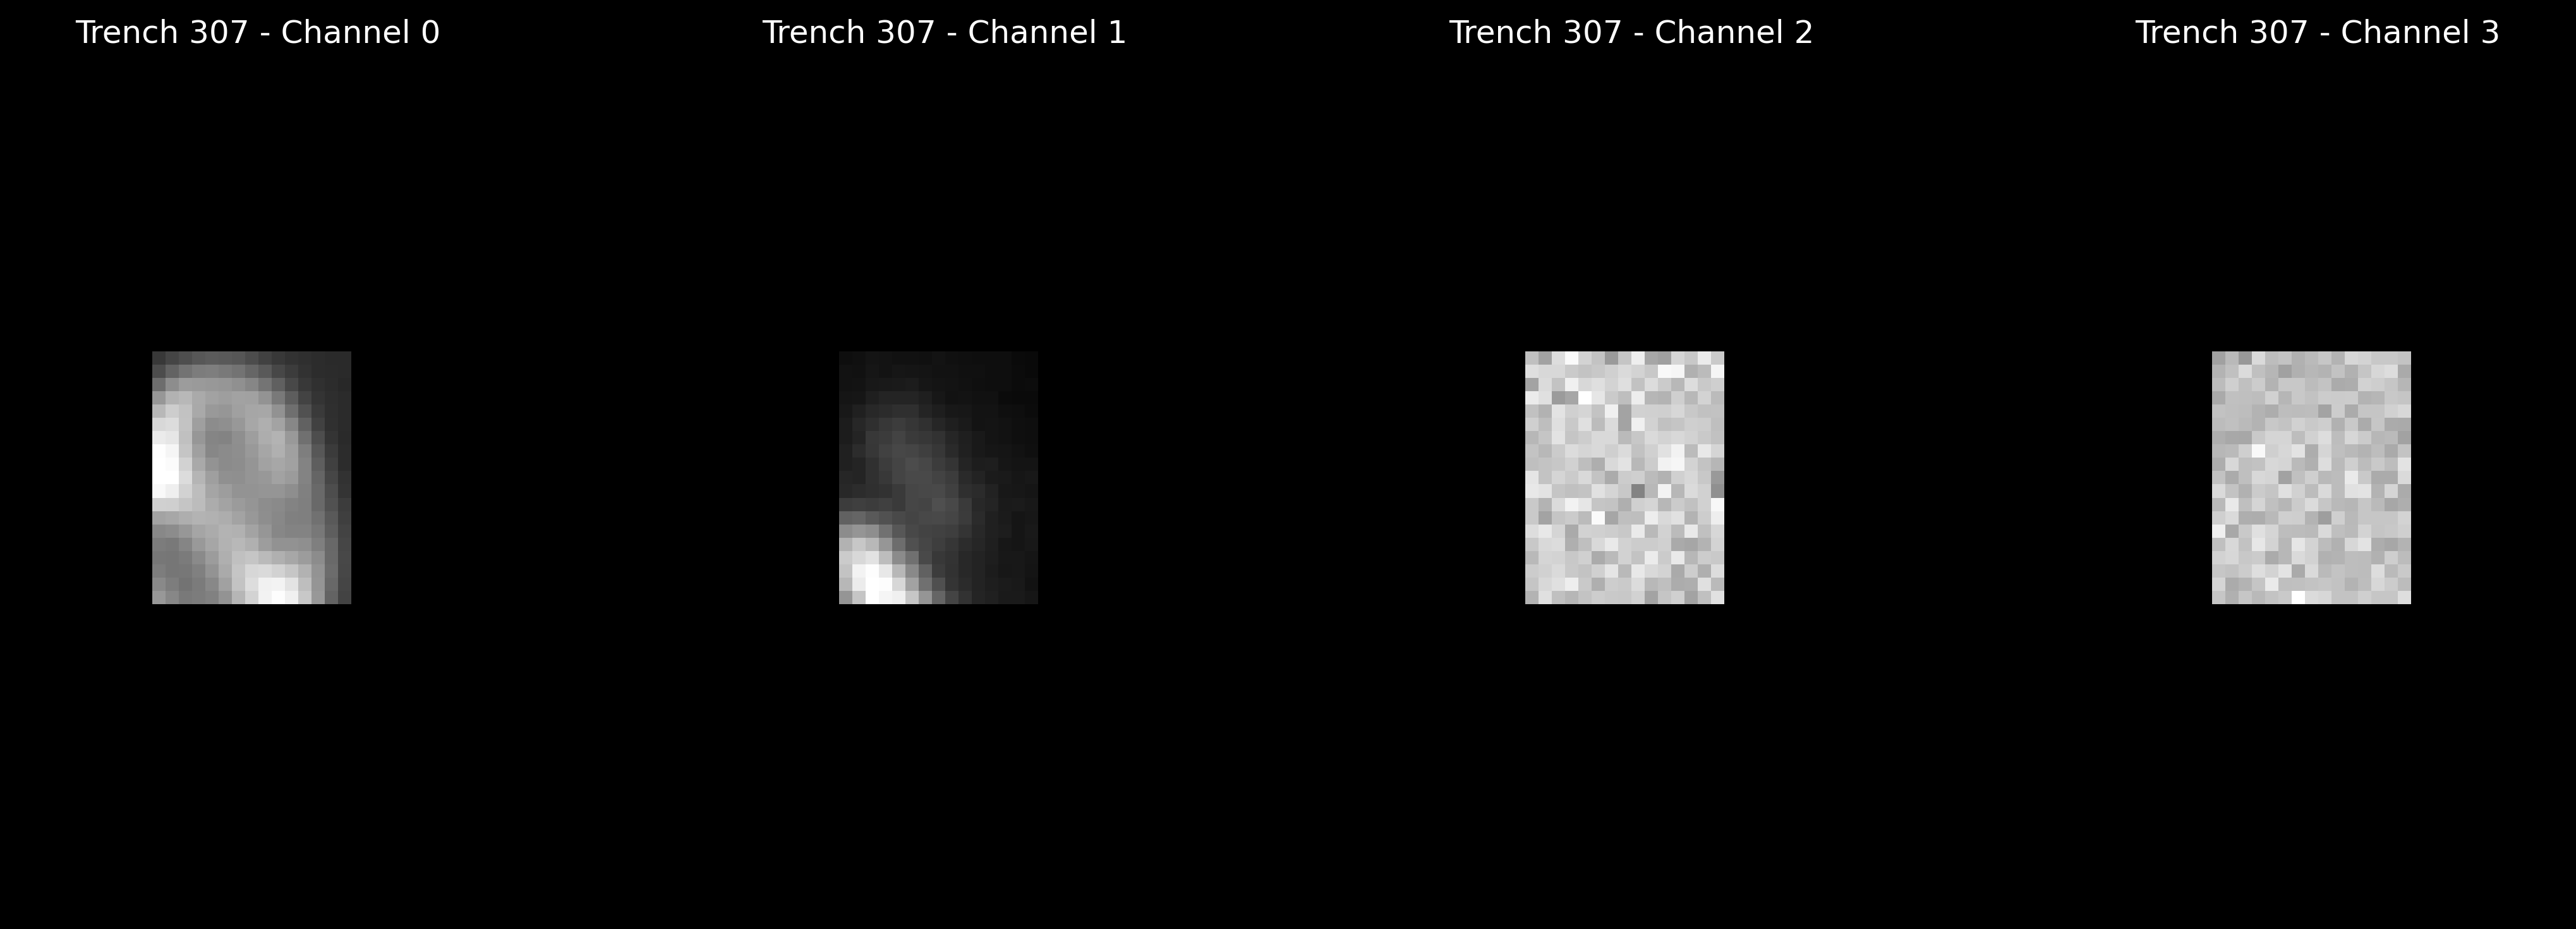

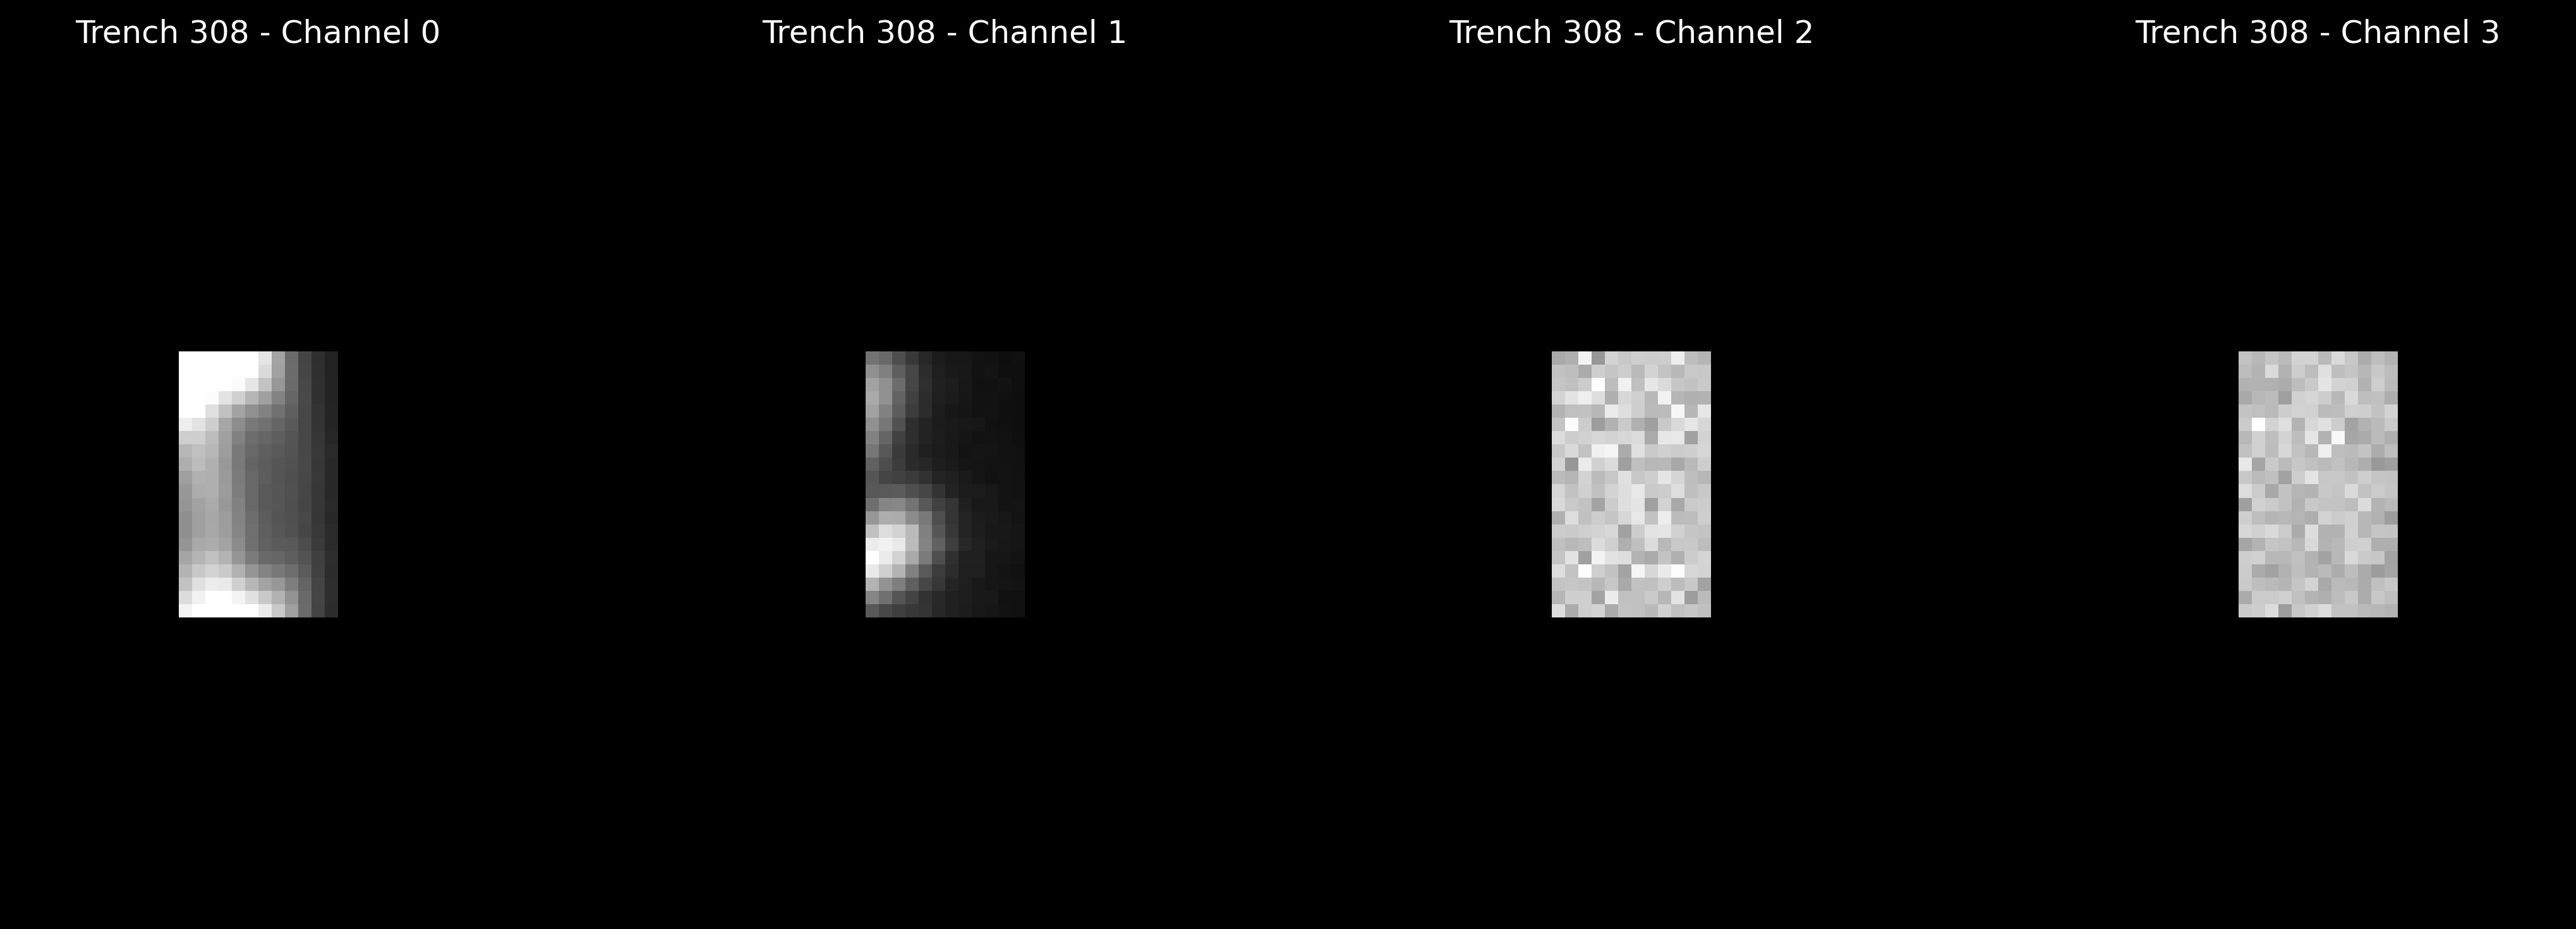

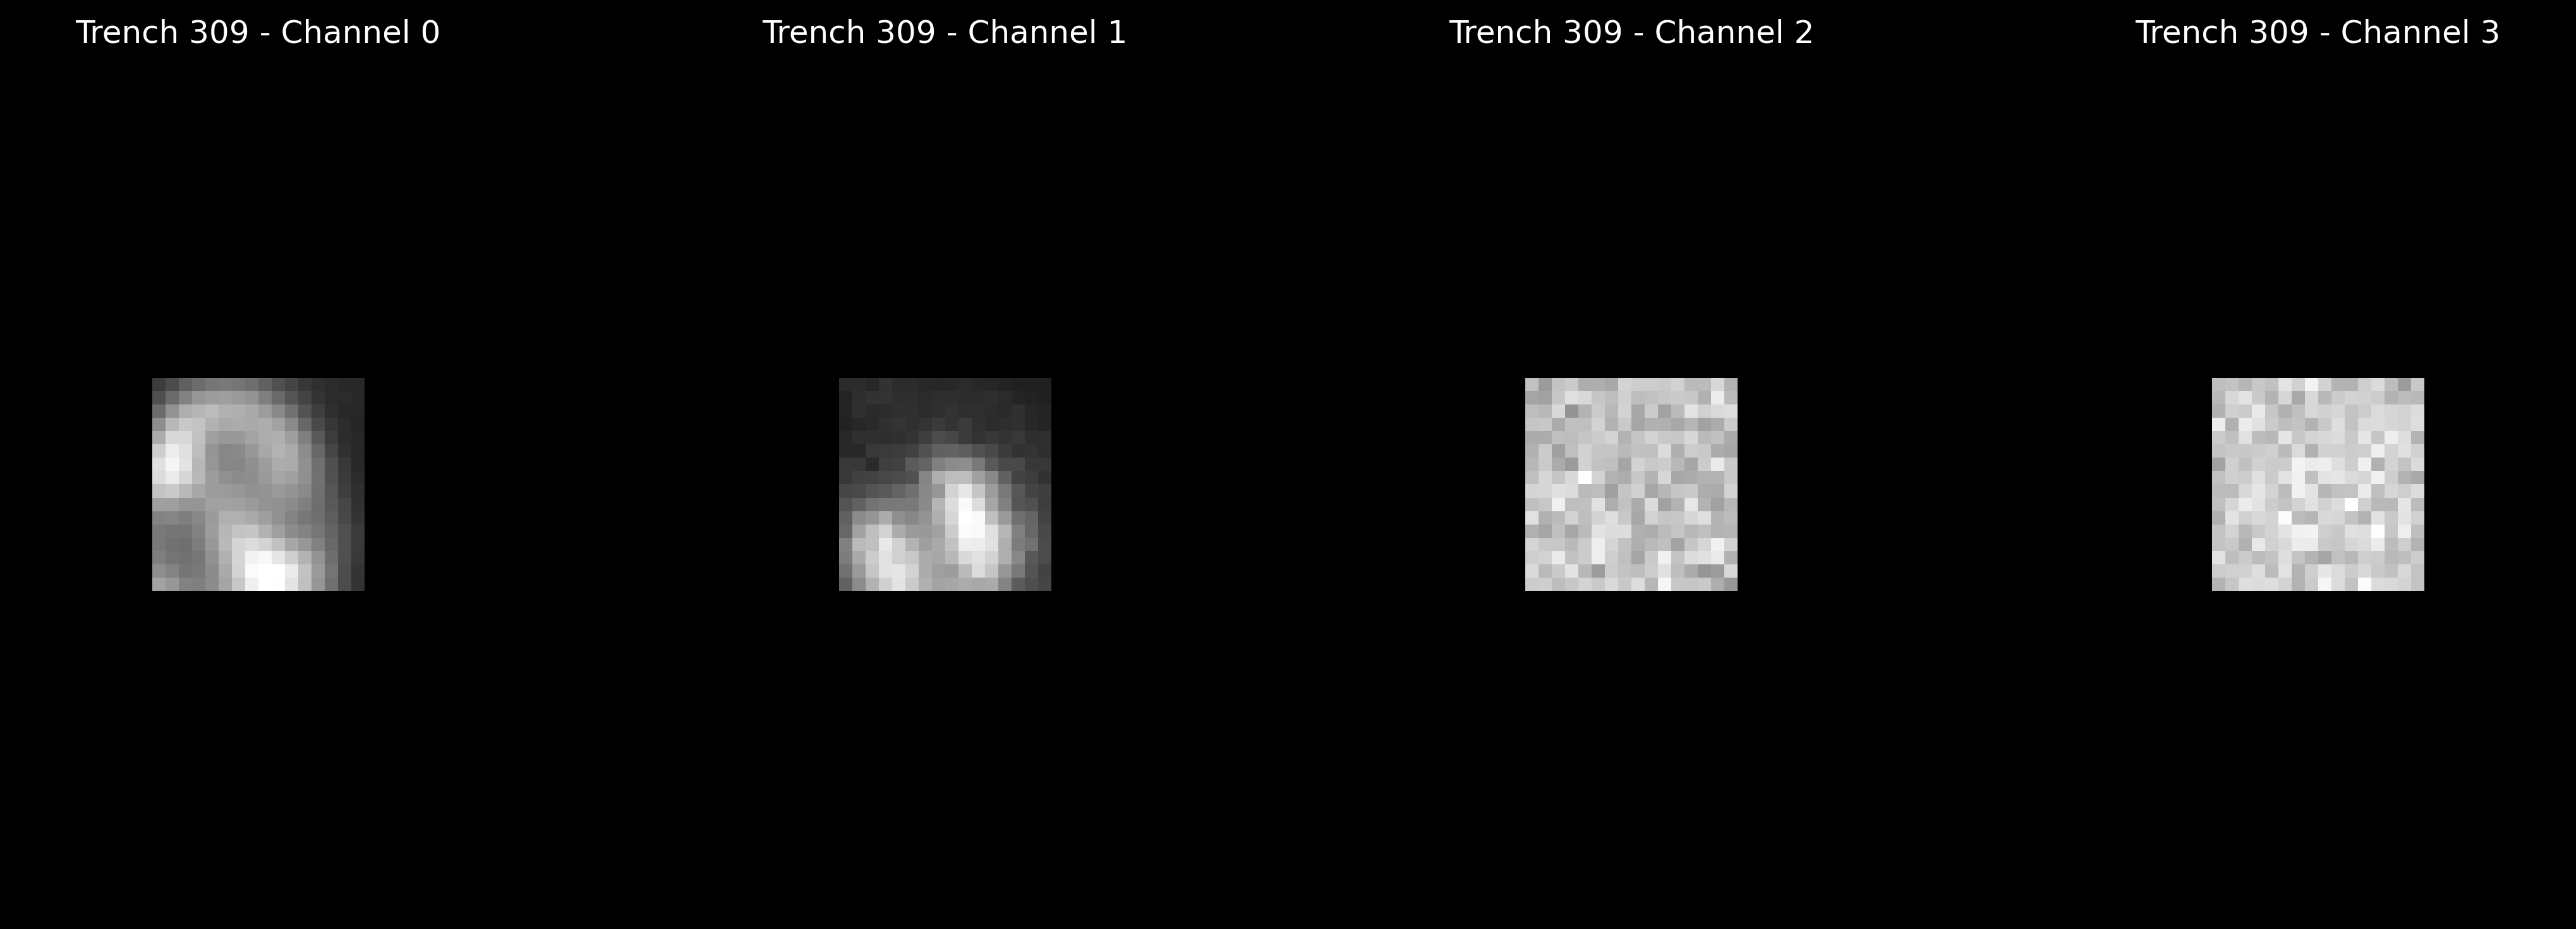

In [563]:
# Specify the trench index you want to inspect
trench_index = 300

  # Change this to the index you want to inspect 750, 800

# Display all channels of the specified trench
display_trenches(processed_images, start_index=trench_index, num_trenches=10)



In [561]:
# Specify the trench index of the "bad" image
trench_index = 700
 # Replace with the trench index of the "bad" image

# Move all channels of the specified trench to bad_images
move_trench_to_bad_images(trench_index)


Moved Trench 700 (all channels) to bad_images and removed it from processed_images.


In [87]:
# # Initialize the training data variable
# training_data = {
#     "images": [],
#     "labels": []
# }


## add images to training set

1: membrane
2: nucleoid
3: both
0: none

In [328]:
# Function to add a specific channel of a trench to the training dataset
def add_channel_to_training_data(trench_index, channel_index, label):
    """
    Add a specific channel of a trench to the training dataset with the same label.
    Parameters:
        trench_index (int): Index of the trench to add.
        channel_index (int): Index of the channel to add (e.g., 0 for PC, 1 for RFP, etc.).
        label (int): The label to assign to this channel.
    """
    global training_data
    channel_image = processed_images[trench_index][channel_index]
    if channel_image is not None:  # Ensure the image is not None
        training_data["images"].append(channel_image)
        training_data["labels"].append(label)
        print(f"Added Trench {trench_index}, Channel {channel_index} with label {label} to training_data.")
    else:
        print(f"Skipping Trench {trench_index}, Channel {channel_index}: Image is None.")


In [329]:
# # Specify the trench index, channel index, and label for the training data
# trench_index = 1  # Replace with the trench index of the image
# channel_index = 0  # Replace with the channel index (e.g., 0 for PC, 1 for RFP, etc.)
# label = 0  # Replace with the label for this channel

# # Add the specified channel of the trench to the training dataset
# add_channel_to_training_data(trench_index, channel_index, label)


In [564]:
# Specify the channel index and label for all trenches
channel_index = 1  # Replace with the channel index (e.g., 0 for PC, 1 for RFP, etc.)
label = 2  # Replace with the label for this channel

# 0: BG, 1:M, 2:N, 3:Both

# Add the specified channel for all trenches
for trench_index in range(len(processed_images)):
    add_channel_to_training_data(trench_index, channel_index, label)

print(f"Added channel {channel_index} for all trenches to training_data with label {label}.")


Added Trench 0, Channel 1 with label 2 to training_data.
Added Trench 1, Channel 1 with label 2 to training_data.
Added Trench 2, Channel 1 with label 2 to training_data.
Added Trench 3, Channel 1 with label 2 to training_data.
Added Trench 4, Channel 1 with label 2 to training_data.
Added Trench 5, Channel 1 with label 2 to training_data.
Added Trench 6, Channel 1 with label 2 to training_data.
Added Trench 7, Channel 1 with label 2 to training_data.
Added Trench 8, Channel 1 with label 2 to training_data.
Added Trench 9, Channel 1 with label 2 to training_data.
Added Trench 10, Channel 1 with label 2 to training_data.
Added Trench 11, Channel 1 with label 2 to training_data.
Added Trench 12, Channel 1 with label 2 to training_data.
Added Trench 13, Channel 1 with label 2 to training_data.
Added Trench 14, Channel 1 with label 2 to training_data.
Added Trench 15, Channel 1 with label 2 to training_data.
Added Trench 16, Channel 1 with label 2 to training_data.
Added Trench 17, Channel

Label Counts:
Label 1: 2020 (22.95%)
Label 2: 2100 (23.86%)
Label 0: 3053 (34.69%)
Label 3: 1629 (18.51%)


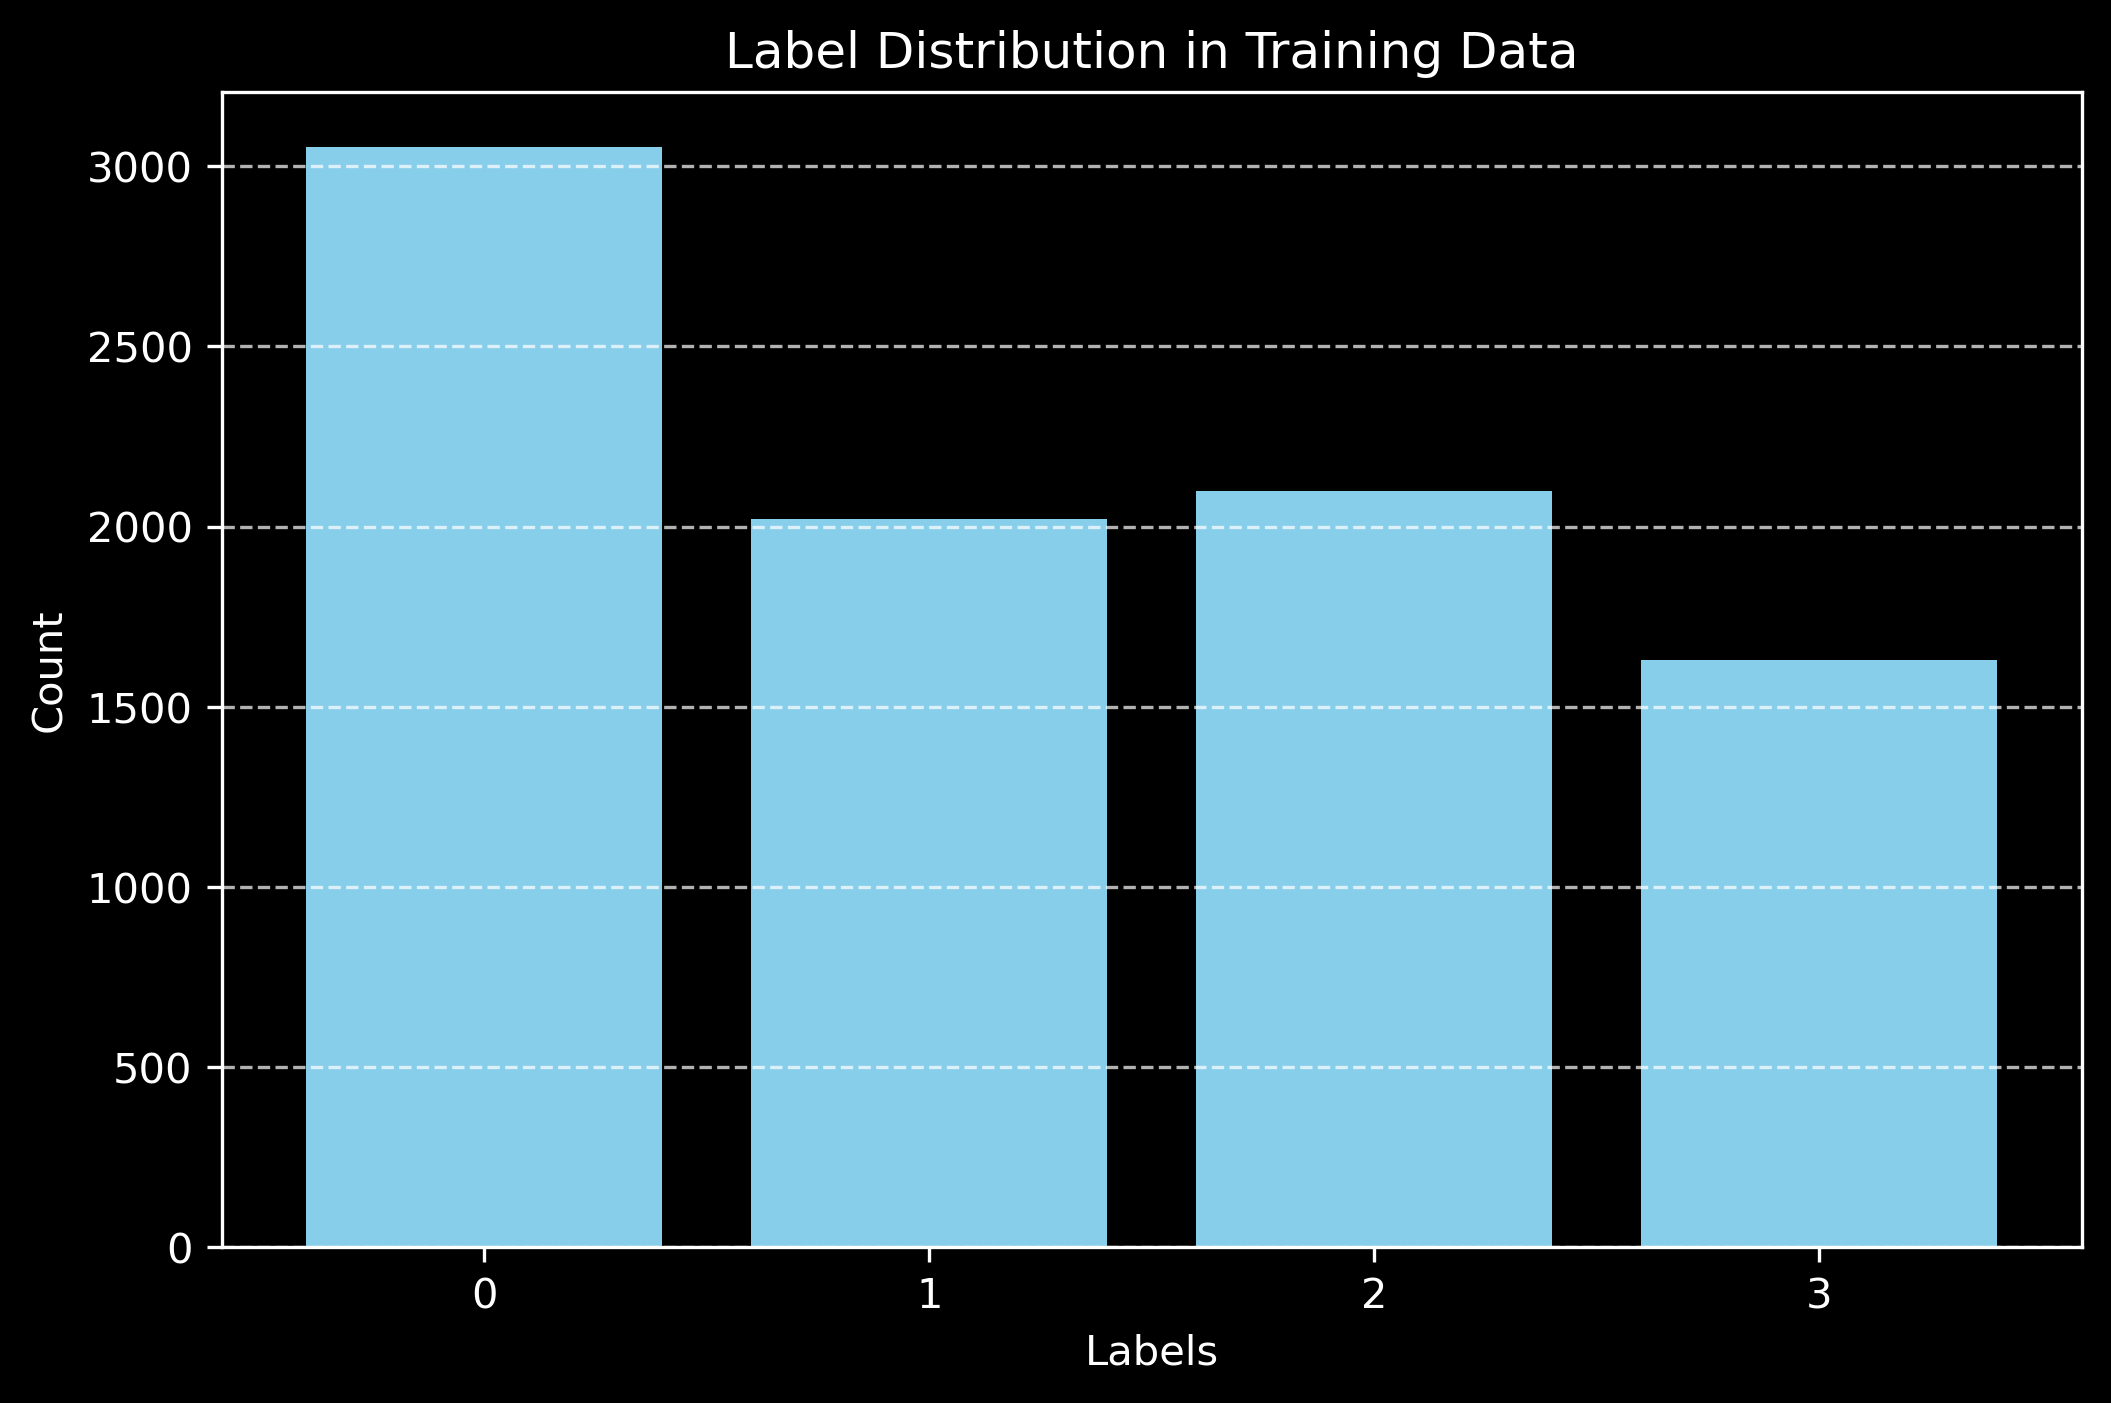

In [567]:
from collections import Counter
import matplotlib.pyplot as plt

def check_label_ratios(labels):
    """
    Check the ratio of labels in the training data.
    Parameters:
        labels (list or numpy array): List of labels corresponding to the training data.
    """
    # Count the frequency of each label
    label_counts = Counter(labels)
    
    # Calculate total number of labels
    total_labels = sum(label_counts.values())
    
    # Calculate the percentage of each label
    label_ratios = {label: count / total_labels * 100 for label, count in label_counts.items()}
    
    # Print label counts and ratios
    print("Label Counts:")
    for label, count in label_counts.items():
        print(f"Label {label}: {count} ({label_ratios[label]:.2f}%)")
    
    # Visualize the label distribution as a bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution in Training Data')
    plt.xticks(list(label_counts.keys()))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
# Assuming `training_labels` contains the labels for your training data
check_label_ratios(training_data["labels"])


In [441]:
len(training_data["images"])

9442

## add bad channels

In [ ]:
# Function to add all channels of bad images to the training dataset
def add_bad_images_to_training_data(bad_images, label=3):
    """
    Add all channels of bad images to the training dataset with the same label.
    Parameters:
        bad_images (list): List of bad images where each element is a list of channels.
        label (int): The label to assign to these bad images (default=3).
    """
    global training_data
    for trench_index, trench_channels in enumerate(bad_images):
        for channel_index, channel_image in enumerate(trench_channels):
            if channel_image is not None:  # Ensure the channel image is not None
                training_data["images"].append(channel_image)
                training_data["labels"].append(label)
                print(f"Added Bad Image Trench {trench_index}, Channel {channel_index} with label {label} to training_data.")
            else:
                print(f"Skipping Bad Image Trench {trench_index}, Channel {channel_index}: Image is None.")


In [ ]:
# Add all bad images with label 3 to the training dataset
add_bad_images_to_training_data(bad_images, label=3)

print("All bad images have been added to the training dataset with label 3.")


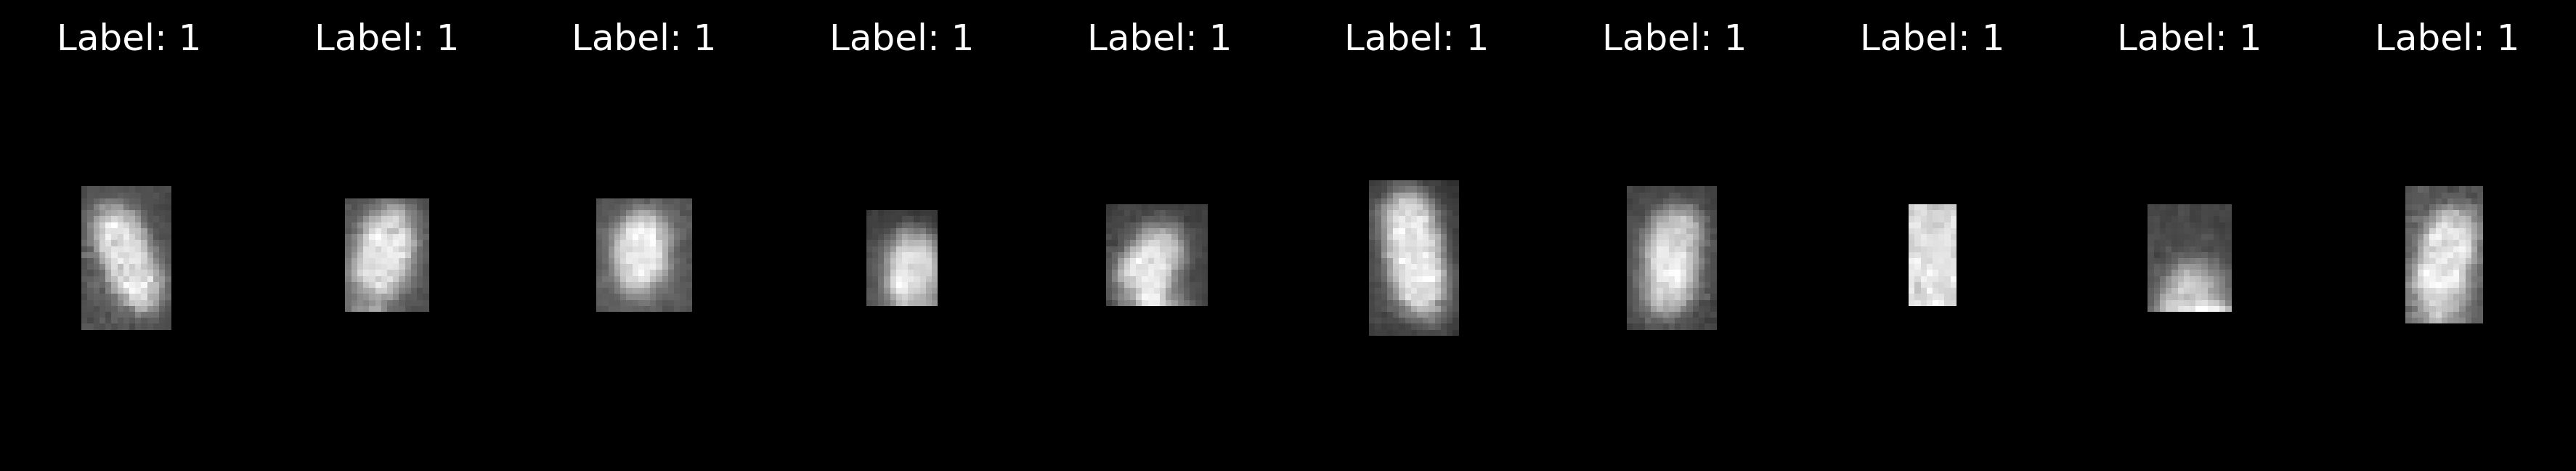

In [574]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a few images from the training dataset with more flexibility
def display_training_data(training_data, start_index=0, end_index=None, shuffle=False):
    """
    Display a range of images from the training dataset with their labels.
    Parameters:
        training_data (dict): The training dataset containing "images" and "labels".
        start_index (int): Starting index of images to display.
        end_index (int or None): Ending index of images to display (exclusive). If None, displays all from start_index.
        shuffle (bool): If True, shuffle the dataset before displaying.
    """
    # Extract images and labels
    images = training_data["images"]
    labels = training_data["labels"]
    
    # Shuffle the dataset if required
    if shuffle:
        indices = np.random.permutation(len(images))
        images = [images[i] for i in indices]
        labels = [labels[i] for i in indices]
    
    # Define the range of images to display
    if end_index is None:
        end_index = len(images)
    num_samples = min(end_index - start_index, len(images))
    
    # Display the images with their labels
    plt.figure(figsize=(15, 5))
    for i in range(start_index, start_index + num_samples):
        plt.subplot(1, num_samples, i - start_index + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# Example usage:
# Display images from index 0 to 9
display_training_data(normalised_training_data, start_index=280, end_index=290)

# Shuffle the dataset and display 5 random images
# display_training_data(training_data, num_samples=5, shuffle=True)


## remove mistakes

In [447]:
def remove_last_training_data(training_data, num_to_remove=340):
    """
    Remove the last `num_to_remove` entries from the training dataset.
    Parameters:
        training_data (dict): The training dataset containing "images" and "labels".
        num_to_remove (int): Number of entries to remove from the end.
    Returns:
        dict: Updated training dataset.
    """
    # Ensure the number to remove does not exceed the dataset size
    total_samples = len(training_data["images"])
    if num_to_remove > total_samples:
        raise ValueError("Cannot remove more entries than available in the dataset.")

    # Remove the last `num_to_remove` entries
    training_data["images"] = training_data["images"][:-num_to_remove]
    training_data["labels"] = training_data["labels"][:-num_to_remove]

    return training_data


# Example usage:
print(f"Before removal: {len(training_data['images'])} samples")
training_data = remove_last_training_data(training_data, num_to_remove=340)
print(f"After removal: {len(training_data['images'])} samples")


Before removal: 9442 samples
After removal: 9102 samples


## balance dataset

In [566]:
def remove_specific_label(training_data, label_to_remove, num_to_remove):
    """
    Remove a specific number of entries with a particular label from the training dataset.
    Parameters:
        training_data (dict): The training dataset containing "images" and "labels".
        label_to_remove (int): The label to be removed from the dataset.
        num_to_remove (int): The number of entries with this label to remove.
    Returns:
        dict: Updated training dataset.
    """
    # Create a new dataset for filtered images and labels
    new_images = []
    new_labels = []

    # Counter to track how many entries of the specific label are removed
    removed_count = 0

    # Iterate through the dataset
    for image, label in zip(training_data["images"], training_data["labels"]):
        if label == label_to_remove and removed_count < num_to_remove:
            removed_count += 1
            continue  # Skip adding this entry to the new dataset
        new_images.append(image)
        new_labels.append(label)

    # Update the training dataset
    training_data["images"] = new_images
    training_data["labels"] = new_labels

    print(f"Removed {removed_count} entries with label {label_to_remove}.")
    return training_data


# Example usage:
label_to_remove = 0  # Label you want to remove
num_to_remove = 1000  # Number of entries to remove for this label

print(f"Before removal: {len(training_data['images'])} samples")
training_data = remove_specific_label(training_data, label_to_remove, num_to_remove)
print(f"After removal: {len(training_data['images'])} samples")


Before removal: 9802 samples
Removed 1000 entries with label 0.
After removal: 8802 samples


## normalise and shuffle

In [568]:
def normalize_image(image):
    normalized = (image-np.min(image))/(np.max(image)-np.min(image))
    return normalized

In [595]:
def normalize_training_data(training_data):
    """
    Normalize all images in the training dataset.
    Parameters:
        training_data (dict): The training dataset containing "images" and "labels".
    Returns:
        dict: Updated training dataset with normalized images.
    """
    normalized_images = []

    # Normalize each image
    for image in training_data["images"]:
        normalized_image = normalize_image(image)
        normalized_images.append(normalized_image)

    # Update the training dataset with normalized images
    training_data["images"] = normalized_images
    print("All images in the training dataset have been normalized.")

    return training_data


# Example usage:
print("Before normalization:")
print(f"Min value: {np.min(training_data['images'][0])}, Max value: {np.max(training_data['images'][0])}")

normalised_training_data = normalize_training_data(training_data)

print("After normalization:")
print(f"Min value: {np.min(normalised_training_data['images'][0])}, Max value: {np.max(normalised_training_data['images'][0])}")


Before normalization:
Min value: 0.0, Max value: 1.0
All images in the training dataset have been normalized.
After normalization:
Min value: 0.0, Max value: 1.0


In [597]:
print(len(normalised_training_data["images"]))

8802


In [598]:
import pickle

# Save the normalised training data
output_path = r"D:\PRISM\PRISM_model\train_with_real_images\normalised_training_data.pkl"
with open(output_path, 'wb') as f:
    pickle.dump(normalised_training_data, f)

print(f"Normalized training data has been saved at: {output_path}")

# Open and load the saved data to verify
with open(output_path, 'rb') as f:
    loaded_data = pickle.load(f)

# Check the structure of the loaded data
loaded_data_keys = loaded_data.keys()
print(f"Loaded data keys: {loaded_data_keys}")
print(f"Number of images: {len(loaded_data['images'])}")
print(f"Number of labels: {len(loaded_data['labels'])}")


Normalized training data has been saved at: D:\PRISM\PRISM_model\train_with_real_images\normalised_training_data.pkl
Loaded data keys: dict_keys(['images', 'labels'])
Number of images: 8802
Number of labels: 8802


In [591]:
import random

# Assuming `normalised_training_data` is a dictionary with "images" and "labels"
def shuffle_training_data(training_data):
    """
    Shuffle the training data while keeping images and labels aligned.
    Parameters:
        training_data (dict): The training data dictionary containing "images" and "labels".
    Returns:
        shuffled_data (dict): The shuffled training data.
    """
    combined = list(zip(training_data["images"], training_data["labels"]))  # Combine images and labels
    random.shuffle(combined)  # Shuffle the combined list
    shuffled_images, shuffled_labels = zip(*combined)  # Unzip into images and labels
    return {"images": list(shuffled_images), "labels": list(shuffled_labels)}

# Shuffle the normalized training data
shuffled_normalised_training_data = shuffle_training_data(normalised_training_data)

# Verify shuffle
print("Original first label:", normalised_training_data["labels"][:5])
print("Shuffled first label:", shuffled_normalised_training_data["labels"][:5])


Original first label: [1, 1, 1, 1, 1]
Shuffled first label: [2, 0, 3, 3, 1]


## save training images

In [573]:
import pickle

# Define the path where you want to save the file
output_path = r"D:\PRISM\PRISM_model\train_with_real_images\shuffled_training_data.pkl"

# Save the shuffled training data as a .pkl file
with open(output_path, 'wb') as f:
    pickle.dump(shuffled_normalised_training_data, f)

print(f"Shuffled training data saved successfully to {output_path}")


Shuffled training data saved successfully to D:\PRISM\PRISM_model\train_with_real_images\shuffled_training_data.pkl


## data augumentation to double dataset

In [609]:
import numpy as np

def flip_images_and_double_data(normalised_training_data):
    """
    Flip images in the normalized training data to double the number of images.
    Parameters:
        normalised_training_data (dict): The training dataset containing "images" and "labels".
    Returns:
        dict: Updated dataset with doubled number of images, where half are flipped versions.
    """
    # Extract images and labels
    images = np.array(normalised_training_data["images"])
    labels = np.array(normalised_training_data["labels"])

    # Flip images horizontally (axis=1 for width)
    flipped_images = np.flip(images, axis=2)

    # Concatenate the original and flipped images
    doubled_images = np.concatenate((images, flipped_images), axis=0)
    doubled_labels = np.concatenate((labels, labels), axis=0)

    # Create the doubled dataset
    double_normalised_training_data = {
        "images": doubled_images,
        "labels": doubled_labels
    }

    return double_normalised_training_data


# Example usage:
double_normalised_training_data = flip_images_and_double_data(shuffled_normalised_training_data)

print(f"Original number of images: {len(normalised_training_data['images'])}")
print(f"Doubled number of images: {len(double_normalised_training_data['images'])}")



Original number of images: 8802
Doubled number of images: 17604


In [610]:


# Define the path where you want to save the file
output_path = r"D:\PRISM\PRISM_model\train_with_real_images\double\shuffled_training_data.pkl"

# Save the shuffled training data as a .pkl file
with open(output_path, 'wb') as f:
    pickle.dump(double_normalised_training_data, f)

print(f"Shuffled training data saved successfully to {output_path}")

Shuffled training data saved successfully to D:\PRISM\PRISM_model\train_with_real_images\double\shuffled_training_data.pkl


## make 8:2 split for train:test

In [593]:
from collections import defaultdict
import random
import numpy as np
import pickle

def split_training_test(training_data, train_ratio=0.8):
    """
    Split the training data into training and test datasets with an 8:2 ratio for each class.
    Parameters:
        training_data (dict): The training dataset containing "images" and "labels".
        train_ratio (float): The ratio of samples to use for training (default is 0.8).
    Returns:
        dict, dict: Training and test datasets.
    """
    # Group images and labels by their class
    class_data = defaultdict(list)
    for image, label in zip(training_data["images"], training_data["labels"]):
        class_data[label].append(image)

    # Debug: Print class distribution before splitting
    print("Class distribution before splitting:")
    for label, images in class_data.items():
        print(f"Class {label}: {len(images)} samples")

    # Initialize training and test datasets
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    # Split each class into training and test datasets
    for label, images in class_data.items():
        random.shuffle(images)  # Shuffle images within the class
        split_index = int(len(images) * train_ratio)  # Determine split index

        train_images.extend(images[:split_index])
        train_labels.extend([label] * split_index)

        test_images.extend(images[split_index:])
        test_labels.extend([label] * (len(images) - split_index))

    # Debug: Print class distribution after splitting
    print("Class distribution after splitting:")
    unique_train_labels, train_label_counts = np.unique(train_labels, return_counts=True)
    for label, count in zip(unique_train_labels, train_label_counts):
        print(f"Class {label} in training set: {count} samples")
    unique_test_labels, test_label_counts = np.unique(test_labels, return_counts=True)
    for label, count in zip(unique_test_labels, test_label_counts):
        print(f"Class {label} in test set: {count} samples")

    # Create training and test datasets
    train_data = {"images": train_images, "labels": train_labels}
    test_data = {"images": test_images, "labels": test_labels}

    return train_data, test_data


def shuffle_training_data(training_data):
    """
    Shuffle the training data (images and labels).
    Parameters:
        training_data (dict): The training dataset containing "images" and "labels".
    Returns:
        dict: Shuffled training dataset.
    """
    # Combine images and labels for shuffling
    combined = list(zip(training_data["images"], training_data["labels"]))
    random.shuffle(combined)

    # Unpack the shuffled data
    shuffled_images, shuffled_labels = zip(*combined)
    return {"images": list(shuffled_images), "labels": list(shuffled_labels)}


# Example usage:
# Split the normalized training data
train_data, test_data = split_training_test(normalised_training_data)

# Shuffle the training and test data
shuffled_train_data = shuffle_training_data(train_data)
shuffled_test_data = shuffle_training_data(test_data)

# Debug: Check if labels match the number of images
print(f"Training set: {len(shuffled_train_data['images'])} images, {len(shuffled_train_data['labels'])} labels")
print(f"Test set: {len(shuffled_test_data['images'])} images, {len(shuffled_test_data['labels'])} labels")

# Save the datasets
train_path = r"D:\PRISM\PRISM_model\train_with_real_images\split\shuffled_train_data.pkl"
test_path = r"D:\PRISM\PRISM_model\train_with_real_images\split\shuffled_test_data.pkl"

with open(train_path, 'wb') as f:
    pickle.dump(shuffled_train_data, f)
with open(test_path, 'wb') as f:
    pickle.dump(shuffled_test_data, f)

print("Training and test datasets have been saved.")


Class distribution before splitting:
Class 1: 2020 samples
Class 2: 2100 samples
Class 0: 3053 samples
Class 3: 1629 samples
Class distribution after splitting:
Class 0 in training set: 2442 samples
Class 1 in training set: 1616 samples
Class 2 in training set: 1680 samples
Class 3 in training set: 1303 samples
Class 0 in test set: 611 samples
Class 1 in test set: 404 samples
Class 2 in test set: 420 samples
Class 3 in test set: 326 samples
Training set: 7041 images, 7041 labels
Test set: 1761 images, 1761 labels
Training and test datasets have been saved.


In [594]:
with open(train_path, 'rb') as f:
    train_data = pickle.load(f)
with open(test_path, 'rb') as f:
    test_data = pickle.load(f)

print(f"Train images: {len(train_data['images'])}, Train labels: {len(train_data['labels'])}")
print(f"Test images: {len(test_data['images'])}, Test labels: {len(test_data['labels'])}")



Train images: 7041, Train labels: 7041
Test images: 1761, Test labels: 1761


# (Old version) Try Classifying with PRISM

In [21]:
import tensorflow as tf
import numpy as np
print(tf.__version__)  # Should be 2.4.1
print(np.__version__)  # Should be 1.19.5

2.18.0
1.26.4


In [22]:
import os
import numpy as np
import pandas as pd
from tifffile import imread, imwrite
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import pickle
# import statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from utils import normalize_image
# from pylab import gray
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from tifffile import imread, imsave

In [24]:
# # Load trained NN model
# # Opens and loads a saved neural network model in JSON format and loads its weights from an .hdf5 file.
# json_file = open(r'D:\PRISM\PRISM_model\ch_trained_models\65.00\cat_model\cat_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = keras.models.model_from_json(loaded_model_json)
# model.load_weights(r"D:\PRISM\PRISM_model\ch_trained_models\65.00\cat_model\cat_model-21-epoch-validacc-0.99.hdf5")
# print("Loaded model from PC")

# model.compile(
#     optimizer = 'adam',
#     loss = 'categorical_crossentropy',
#     metrics = ['accuracy']
# )

In [25]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras import Model

# Define a substitute class for 'Functional' if needed
class Functional(Model):
    pass

# Load trained NN model
json_file = open(r'D:\PRISM\PRISM_model\ch_trained_models\65.00\cat_model\cat_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

# Use custom_objects to specify Functional
model_PRISM = model_from_json(loaded_model_json, custom_objects={'Functional': Functional})

# Load weights
model_PRISM.load_weights(r"D:\PRISM\PRISM_model\ch_trained_models\65.00\cat_model\cat_model-21-epoch-validacc-0.99.hdf5")
# model_PRISM.load_weights(r"D:\PRISM\PRISM_model\train_with_real_images\saved_model\saved-plain-model-38-0.82.keras")

print("Loaded model from PC")

# Compile the model
model_PRISM.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Loaded model from PC


In [26]:
# # If you want to load saved image
# # Load filtered_images_6436 from a specified path and filename
# def load_filtered_images(directory=".", filename="filtered_images_6436.pkl"):
#     filepath = os.path.join(directory, filename)
    
#     if not os.path.exists(filepath):
#         print(f"File {filepath} does not exist.")
#         return None
    
#     with open(filepath, 'rb') as f:
#         data = pickle.load(f)
#     print(f"Data loaded from {filepath}")
#     return data

# # Usage example:
# filtered_images_6436 = load_filtered_images(directory="D:/PRISM/cell_data", filename="HADA_images.pkl")

In [27]:
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm  # Import tqdm for the progress bar
from collections import defaultdict

# Min-max normalization (same as your normalize_image function)
def normalize_image(image):
    normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized

# Preprocessing function (no resizing, just normalisation and reshaping to 4D)
def preprocess_image(image):
    # Apply per-image min-max normalization
    image_normalized = normalize_image(image)

    # Expand dimensions to match model input shape (1, height, width, 1)
    image_expanded = np.expand_dims(image_normalized, axis=[0, -1])

    return image_expanded

# Function to classify the mother cell image
def classify_mother_cell_image(model, image):
    # Make a prediction
    prediction = model.predict(image)
    
    # Get the predicted class index (the class with the highest probability)
    predicted_class = np.argmax(prediction, axis=-1)[0]
    
    # Optionally, print probabilities for each class (if you have class labels)
    print(f"Class probabilities: {prediction}")
    
    return predicted_class

# Dictionary to store the count and IDs for each class
class_counts = defaultdict(int)
class_ids = defaultdict(list)

# Classify each mother cell image in filtered_images_6436 with a progress bar
for i, trench_images in tqdm(enumerate(processed_images_6436), total=len(processed_images_6436), desc="Classifying images"):
    if trench_images[0] is None:
        print(f"Skipping trench {i} as no mother cell mask was found.")
        continue
    
    # Select channel to use for classification
    image = trench_images[1]  # image should already be the correct size (no resizing)

    # Preprocess the image (normalize and add batch/channel dimensions)
    preprocessed_image = preprocess_image(image)

    # Classify the image using the loaded model
    predicted_class = classify_mother_cell_image(model_PRISM, preprocessed_image)

    # Update statistics
    class_counts[predicted_class] += 1
    class_ids[predicted_class].append(i)  # Store trench ID

    # Output the predicted class for each trench
    print(f"Predicted class for trench {i}: {predicted_class}")

# Print the final statistics
print("\nClassification Statistics:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} images")


Classifying images:   0%|          | 0/452 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Classifying images:   0%|          | 1/452 [00:00<02:38,  2.85it/s]

Class probabilities: [[4.1544257e-04 4.9172021e-03 9.9335611e-01 1.3112907e-03]]
Predicted class for trench 0: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[2.7397886e-07 1.1665810e-07 9.9999940e-01 2.5750529e-07]]
Predicted class for trench 1: 2
Skipping trench 2 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:   1%|          | 4/452 [00:00<00:42, 10.54it/s]

Class probabilities: [[6.3141604e-05 6.9171649e-05 9.9950516e-01 3.6248995e-04]]
Predicted class for trench 3: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.72429514 0.2651684  0.00273951 0.00779701]]
Predicted class for trench 4: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:   1%|▏         | 6/452 [00:00<00:33, 13.27it/s]

Class probabilities: [[2.4414696e-06 1.0636471e-06 9.9999356e-01 2.9781236e-06]]
Predicted class for trench 5: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.177958e-05 8.005394e-05 9.997013e-01 1.268290e-04]]
Predicted class for trench 6: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:   2%|▏         | 8/452 [00:00<00:29, 15.17it/s]

Class probabilities: [[1.3307675e-05 7.7715122e-06 9.9996316e-01 1.5762525e-05]]
Predicted class for trench 7: 2
Skipping trench 8 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.1425700e-06 6.4453984e-06 9.9997199e-01 1.2398277e-05]]
Predicted class for trench 9: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:   2%|▏         | 11/452 [00:00<00:22, 19.43it/s]

Class probabilities: [[9.9764961e-01 2.2000701e-03 4.8812224e-05 1.0152696e-04]]
Predicted class for trench 10: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.00548964 0.88149214 0.08806604 0.0249521 ]]
Predicted class for trench 11: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:   3%|▎         | 14/452 [00:01<00:39, 11.15it/s]

Class probabilities: [[1.9824531e-05 1.2541998e-05 9.9993885e-01 2.8782089e-05]]
Predicted class for trench 12: 2
Skipping trench 13 as no mother cell mask was found.
Skipping trench 14 as no mother cell mask was found.
Skipping trench 15 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class probabilities: [[6.6678645e-06 2.8835605e-06 9.9998295e-01 7.5125272e-06]]
Predicted class for trench 16: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9930668e-01 5.9790857e-04 2.7968024e-05 6.7434092e-05]]
Predicted class for trench 17: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:   4%|▍         | 19/452 [00:01<00:26, 16.53it/s]

Class probabilities: [[1.2942262e-06 4.6109085e-07 9.9999654e-01 1.6563476e-06]]
Predicted class for trench 18: 2
Skipping trench 19 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Class probabilities: [[1.9155214e-05 1.3256134e-05 9.9994695e-01 2.0562446e-05]]
Predicted class for trench 20: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:   5%|▍         | 22/452 [00:01<00:22, 18.82it/s]

Class probabilities: [[3.5153703e-06 1.8620914e-06 9.9999058e-01 4.0586920e-06]]
Predicted class for trench 21: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.6401101e-06 1.5917161e-06 9.9998832e-01 5.4351744e-06]]
Predicted class for trench 22: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9660659e-01 2.4688288e-03 2.1241338e-04 7.1222393e-04]]
Predicted class for trench 23: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:   6%|▌         | 25/452 [00:01<00:22, 18.96it/s]

Class probabilities: [[4.1726325e-05 3.0388872e-05 9.9987972e-01 4.8106464e-05]]
Predicted class for trench 24: 2
Skipping trench 25 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9996626e-01 1.9939163e-05 2.9963028e-06 1.0849898e-05]]
Predicted class for trench 26: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[2.1298561e-05 1.1525115e-05 9.9994385e-01 2.3317258e-05]]
Predicted class for trench 27: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:   6%|▋         | 29/452 [00:01<00:19, 21.29it/s]

Class probabilities: [[0.00181282 0.994472   0.00115515 0.00255999]]
Predicted class for trench 28: 1
Skipping trench 29 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9979192e-01 1.1117112e-04 2.2931637e-05 7.4034106e-05]]
Predicted class for trench 30: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:   7%|▋         | 32/452 [00:01<00:18, 23.14it/s]

Class probabilities: [[9.9895859e-01 5.2437157e-04 1.0769153e-04 4.0938976e-04]]
Predicted class for trench 31: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class probabilities: [[0.50204873 0.47377577 0.0030646  0.02111087]]
Predicted class for trench 32: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[7.0996833e-07 2.6135788e-07 9.9999821e-01 7.8742352e-07]]
Predicted class for trench 33: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:   8%|▊         | 35/452 [00:02<00:19, 21.93it/s]

Class probabilities: [[2.4860399e-05 1.6319840e-05 9.9992704e-01 3.1754724e-05]]
Predicted class for trench 34: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class probabilities: [[2.7711150e-05 2.3280894e-05 9.9990606e-01 4.3011732e-05]]
Predicted class for trench 35: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9099475e-01 8.4821470e-03 1.6287480e-04 3.6025175e-04]]
Predicted class for trench 36: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:   8%|▊         | 38/452 [00:02<00:20, 20.38it/s]

Class probabilities: [[9.9793041e-01 1.6210686e-03 1.1551843e-04 3.3300021e-04]]
Predicted class for trench 37: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.8992552e-06 7.2963087e-07 9.9999487e-01 2.4594087e-06]]
Predicted class for trench 38: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9948019e-01 3.6549024e-04 3.8080540e-05 1.1624952e-04]]
Predicted class for trench 39: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:   9%|▉         | 41/452 [00:02<00:20, 19.89it/s]

Class probabilities: [[0.02545403 0.8290123  0.09734953 0.04818408]]
Predicted class for trench 40: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.49121833 0.49786776 0.00359759 0.00731624]]
Predicted class for trench 41: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9723250e-01 5.4228638e-04 1.4402547e-03 7.8494975e-04]]
Predicted class for trench 42: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  10%|▉         | 44/452 [00:02<00:21, 19.35it/s]

Class probabilities: [[4.3015192e-05 2.4788860e-05 9.9987769e-01 5.4484419e-05]]
Predicted class for trench 43: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class probabilities: [[4.5210049e-06 2.2360630e-06 9.9998844e-01 4.8360680e-06]]
Predicted class for trench 44: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  10%|█         | 47/452 [00:02<00:18, 21.45it/s]

Class probabilities: [[1.4196466e-04 6.5287284e-04 9.9903691e-01 1.6833276e-04]]
Predicted class for trench 45: 2
Skipping trench 46 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class probabilities: [[1.2290174e-05 6.5838785e-06 9.9996638e-01 1.4735232e-05]]
Predicted class for trench 47: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00440675 0.9888608  0.00356725 0.0031652 ]]
Predicted class for trench 48: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  11%|█         | 50/452 [00:02<00:19, 21.01it/s]

Class probabilities: [[8.2252436e-06 5.2489868e-06 9.9997604e-01 1.0523459e-05]]
Predicted class for trench 49: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.05810679e-04 1.19973796e-04 9.99661565e-01 1.12648413e-04]]
Predicted class for trench 50: 2
Skipping trench 51 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  12%|█▏        | 53/452 [00:02<00:18, 22.16it/s]

Class probabilities: [[0.3777078  0.6160033  0.00211864 0.00417038]]
Predicted class for trench 52: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.1632193e-05 8.5410193e-06 9.9996781e-01 1.2011445e-05]]
Predicted class for trench 53: 2
Skipping trench 54 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  12%|█▏        | 56/452 [00:03<00:17, 22.74it/s]

Class probabilities: [[9.9809808e-01 1.6980679e-03 5.9040565e-05 1.4482821e-04]]
Predicted class for trench 55: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.2257488e-01 7.4482374e-02 8.6271687e-04 2.0800766e-03]]
Predicted class for trench 56: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class probabilities: [[7.1107957e-07 2.6531572e-07 9.9999821e-01 8.6227004e-07]]
Predicted class for trench 57: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  13%|█▎        | 59/452 [00:03<00:18, 21.56it/s]

Class probabilities: [[9.9384755e-01 5.5416771e-03 1.7539214e-04 4.3548751e-04]]
Predicted class for trench 58: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.00276347 0.97407657 0.00260225 0.02055772]]
Predicted class for trench 59: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[0.00262676 0.98556626 0.00147414 0.01033274]]
Predicted class for trench 60: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  14%|█▎        | 62/452 [00:03<00:20, 19.01it/s]

Class probabilities: [[2.3431785e-04 2.1611429e-03 9.9677926e-01 8.2530314e-04]]
Predicted class for trench 61: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.1068103e-06 5.2166223e-07 9.9999726e-01 1.1663788e-06]]
Predicted class for trench 62: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  14%|█▍        | 64/452 [00:03<00:20, 18.95it/s]

Class probabilities: [[4.6519212e-06 2.7076360e-06 9.9998713e-01 5.4852467e-06]]
Predicted class for trench 63: 2
Skipping trench 64 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[2.8869856e-05 3.5569807e-05 9.9990892e-01 2.6638319e-05]]
Predicted class for trench 65: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  15%|█▍        | 67/452 [00:03<00:18, 21.23it/s]

Class probabilities: [[0.01048728 0.6363186  0.17900108 0.17419307]]
Predicted class for trench 66: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[3.5138996e-06 1.8438991e-06 9.9999082e-01 3.9017254e-06]]
Predicted class for trench 67: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9989462e-01 7.0888862e-05 8.3599180e-06 2.6151005e-05]]
Predicted class for trench 68: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  15%|█▌        | 70/452 [00:03<00:18, 20.45it/s]

Class probabilities: [[1.0058956e-05 5.2110627e-06 9.9997270e-01 1.2091991e-05]]
Predicted class for trench 69: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[1.9069190e-05 9.8720056e-06 9.9994349e-01 2.7616707e-05]]
Predicted class for trench 70: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[2.1358857e-05 1.2209434e-05 9.9993849e-01 2.7947914e-05]]
Predicted class for trench 71: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  16%|█▌        | 73/452 [00:03<00:20, 18.84it/s]

Class probabilities: [[9.9932289e-01 5.7343522e-04 2.8484283e-05 7.5212316e-05]]
Predicted class for trench 72: 0
Skipping trench 73 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.7274455e-06 6.2194084e-07 9.9999583e-01 1.9278089e-06]]
Predicted class for trench 74: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  17%|█▋        | 76/452 [00:04<00:18, 20.81it/s]

Class probabilities: [[2.7424915e-06 1.4200639e-06 9.9999297e-01 2.8534296e-06]]
Predicted class for trench 75: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9917126e-01 5.9816916e-04 5.8220641e-05 1.7236294e-04]]
Predicted class for trench 76: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[4.3474323e-05 2.9541470e-05 9.9987280e-01 5.4081556e-05]]
Predicted class for trench 77: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  17%|█▋        | 79/452 [00:04<00:18, 20.10it/s]

Class probabilities: [[1.1184885e-04 1.0331451e-04 9.9964702e-01 1.3777206e-04]]
Predicted class for trench 78: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.6766154e-04 3.2625048e-04 9.9930990e-01 1.9627731e-04]]
Predicted class for trench 79: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9955696e-01 2.1458253e-04 5.3000571e-05 1.7545380e-04]]
Predicted class for trench 80: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  18%|█▊        | 82/452 [00:04<00:18, 19.64it/s]

Class probabilities: [[3.1621903e-04 2.8316174e-03 9.9651635e-01 3.3579752e-04]]
Predicted class for trench 81: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[7.0962565e-06 4.0081577e-06 9.9998140e-01 7.3816350e-06]]
Predicted class for trench 82: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[4.006217e-06 2.374597e-06 9.999893e-01 4.250778e-06]]
Predicted class for trench 83: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  19%|█▉        | 85/452 [00:04<00:19, 18.97it/s]

Class probabilities: [[9.9700195e-01 1.5866124e-03 2.0989662e-04 1.2015540e-03]]
Predicted class for trench 84: 0
Skipping trench 85 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class probabilities: [[0.00278311 0.9730715  0.00397812 0.02016723]]
Predicted class for trench 86: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  19%|█▉        | 88/452 [00:04<00:18, 19.39it/s]

Class probabilities: [[2.4197454e-04 2.9257900e-04 9.9923182e-01 2.3364305e-04]]
Predicted class for trench 87: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[7.2560688e-05 5.7656496e-05 9.9978799e-01 8.1840510e-05]]
Predicted class for trench 88: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying images:  20%|█▉        | 90/452 [00:04<00:19, 18.13it/s]

Class probabilities: [[9.9969244e-01 1.5642049e-04 3.5164994e-05 1.1597397e-04]]
Predicted class for trench 89: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Classifying images:  20%|██        | 92/452 [00:04<00:20, 17.32it/s]

Class probabilities: [[1.9494978e-06 7.5360521e-07 9.9999523e-01 2.1324640e-06]]
Predicted class for trench 90: 2
Skipping trench 91 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[3.1650013e-06 1.1450486e-06 9.9999213e-01 3.5505238e-06]]
Predicted class for trench 92: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying images:  21%|██        | 94/452 [00:05<00:22, 15.95it/s]

Class probabilities: [[0.9246984  0.01843662 0.04816576 0.00869927]]
Predicted class for trench 93: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[3.7999155e-06 1.9125662e-06 9.9999034e-01 3.8869421e-06]]
Predicted class for trench 94: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying images:  21%|██        | 96/452 [00:05<00:22, 15.74it/s]

Class probabilities: [[2.4160472e-06 7.8137805e-07 9.9999380e-01 3.0150231e-06]]
Predicted class for trench 95: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.0564568e-05 5.1243451e-06 9.9997246e-01 1.1814627e-05]]
Predicted class for trench 96: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  22%|██▏       | 98/452 [00:05<00:22, 16.02it/s]

Class probabilities: [[4.8995160e-05 3.6092326e-05 9.9985790e-01 5.6947796e-05]]
Predicted class for trench 97: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Class probabilities: [[2.1586945e-06 6.2887727e-07 9.9999464e-01 2.5768404e-06]]
Predicted class for trench 98: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying images:  22%|██▏       | 100/452 [00:05<00:22, 15.33it/s]

Class probabilities: [[5.7782256e-04 1.2865779e-03 9.9671799e-01 1.4175943e-03]]
Predicted class for trench 99: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class probabilities: [[1.0475075e-06 4.8513016e-07 9.9999738e-01 1.0534823e-06]]
Predicted class for trench 100: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying images:  23%|██▎       | 102/452 [00:05<00:22, 15.51it/s]

Class probabilities: [[1.2128025e-05 8.0091741e-06 9.9996710e-01 1.2700162e-05]]
Predicted class for trench 101: 2
Skipping trench 102 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[0.0011929  0.01709169 0.96657616 0.01513929]]
Predicted class for trench 103: 2
Skipping trench 104 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  23%|██▎       | 106/452 [00:05<00:16, 20.52it/s]

Class probabilities: [[8.619458e-06 4.381588e-06 9.999783e-01 8.744797e-06]]
Predicted class for trench 105: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[0.00346929 0.11301868 0.8717858  0.01172619]]
Predicted class for trench 106: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[6.7231595e-06 3.5863316e-06 9.9998271e-01 6.9649136e-06]]
Predicted class for trench 107: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  24%|██▍       | 109/452 [00:05<00:17, 19.43it/s]

Class probabilities: [[1.7422341e-05 1.3200151e-05 9.9995017e-01 1.9227386e-05]]
Predicted class for trench 108: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.9961493e-07 6.9319370e-08 9.9999952e-01 2.2341897e-07]]
Predicted class for trench 109: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  25%|██▍       | 111/452 [00:06<00:17, 19.30it/s]

Class probabilities: [[4.3786467e-06 1.9115198e-06 9.9998868e-01 5.0028812e-06]]
Predicted class for trench 110: 2
Skipping trench 111 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class probabilities: [[2.1132058e-05 1.4190045e-05 9.9993861e-01 2.6092117e-05]]
Predicted class for trench 112: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying images:  25%|██▌       | 114/452 [00:06<00:17, 19.61it/s]

Class probabilities: [[0.04914426 0.93010646 0.00356217 0.01718706]]
Predicted class for trench 113: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[4.5336865e-06 2.0314881e-06 9.9998760e-01 5.7806628e-06]]
Predicted class for trench 114: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  26%|██▌       | 116/452 [00:06<00:18, 18.16it/s]

Class probabilities: [[9.9959832e-01 2.3800746e-04 3.8723108e-05 1.2491998e-04]]
Predicted class for trench 115: 0
Skipping trench 116 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class probabilities: [[1.7600885e-06 7.2111169e-07 9.9999559e-01 1.9172182e-06]]
Predicted class for trench 117: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying images:  26%|██▋       | 119/452 [00:06<00:17, 19.35it/s]

Class probabilities: [[3.9209885e-07 1.2213739e-07 9.9999917e-01 3.9622168e-07]]
Predicted class for trench 118: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.64253443 0.07690114 0.21561109 0.0649534 ]]
Predicted class for trench 119: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  27%|██▋       | 121/452 [00:06<00:17, 18.99it/s]

Class probabilities: [[8.8543078e-05 7.6444725e-05 9.9974281e-01 9.2184542e-05]]
Predicted class for trench 120: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[3.5491942e-06 2.1183041e-06 9.9999046e-01 3.8545986e-06]]
Predicted class for trench 121: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  27%|██▋       | 123/452 [00:06<00:17, 18.36it/s]

Class probabilities: [[1.0373367e-06 3.8576832e-07 9.9999750e-01 1.0029352e-06]]
Predicted class for trench 122: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[1.2634881e-05 9.2628852e-06 9.9996257e-01 1.5584701e-05]]
Predicted class for trench 123: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  28%|██▊       | 125/452 [00:06<00:18, 17.92it/s]

Class probabilities: [[8.4314542e-04 2.3785129e-03 9.9604815e-01 7.3020341e-04]]
Predicted class for trench 124: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9219912e-01 7.1425759e-03 1.8714309e-04 4.7122824e-04]]
Predicted class for trench 125: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  28%|██▊       | 127/452 [00:06<00:18, 17.85it/s]

Class probabilities: [[3.0434677e-07 8.7915502e-08 9.9999928e-01 2.8779957e-07]]
Predicted class for trench 126: 2
Skipping trench 127 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9867332e-01 7.9502311e-04 1.2227752e-04 4.0944639e-04]]
Predicted class for trench 128: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  29%|██▉       | 130/452 [00:07<00:15, 20.46it/s]

Class probabilities: [[2.28352510e-05 1.12447815e-04 9.99836087e-01 2.85208789e-05]]
Predicted class for trench 129: 2
Skipping trench 130 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.1820213e-06 1.9761858e-06 9.9998879e-01 5.0880330e-06]]
Predicted class for trench 131: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying images:  29%|██▉       | 133/452 [00:07<00:17, 18.69it/s]

Class probabilities: [[3.1873958e-06 1.3977923e-06 9.9999142e-01 3.9076485e-06]]
Predicted class for trench 132: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class probabilities: [[9.8666513e-01 1.2583806e-02 2.4317449e-04 5.0793012e-04]]
Predicted class for trench 133: 0
Skipping trench 134 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  30%|███       | 136/452 [00:07<00:16, 19.03it/s]

Class probabilities: [[1.29928785e-05 6.80404582e-06 9.99962807e-01 1.73538901e-05]]
Predicted class for trench 135: 2
Skipping trench 136 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[1.1149422e-05 6.2205659e-06 9.9996972e-01 1.2840958e-05]]
Predicted class for trench 137: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  31%|███       | 139/452 [00:07<00:14, 20.93it/s]

Class probabilities: [[6.9170324e-05 6.5732238e-05 9.9978822e-01 7.6942641e-05]]
Predicted class for trench 138: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9918789e-01 6.8957068e-04 3.3797714e-05 8.8715919e-05]]
Predicted class for trench 139: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.43737725e-05 1.62117303e-05 9.99952435e-01 1.69539289e-05]]
Predicted class for trench 140: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  31%|███▏      | 142/452 [00:07<00:15, 19.81it/s]

Class probabilities: [[1.6555328e-05 1.2069727e-05 9.9995410e-01 1.7201213e-05]]
Predicted class for trench 141: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[1.0483756e-05 8.1202770e-06 9.9997079e-01 1.0609510e-05]]
Predicted class for trench 142: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[1.1942207e-05 7.7605291e-06 9.9996507e-01 1.5290449e-05]]
Predicted class for trench 143: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  32%|███▏      | 145/452 [00:07<00:15, 19.69it/s]

Class probabilities: [[1.6531195e-04 1.3229104e-04 9.9952757e-01 1.7487767e-04]]
Predicted class for trench 144: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.5162335e-05 3.3872213e-05 9.9987018e-01 5.0716098e-05]]
Predicted class for trench 145: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9031150e-01 9.1139274e-03 1.8033838e-04 3.9416138e-04]]
Predicted class for trench 146: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  33%|███▎      | 148/452 [00:07<00:15, 19.72it/s]

Class probabilities: [[8.9443051e-07 2.9211895e-07 9.9999774e-01 9.8082694e-07]]
Predicted class for trench 147: 2
Skipping trench 148 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[2.1519023e-05 1.6694634e-05 9.9993634e-01 2.5412639e-05]]
Predicted class for trench 149: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  33%|███▎      | 151/452 [00:08<00:13, 21.75it/s]

Class probabilities: [[0.00220359 0.9864826  0.00594906 0.00536468]]
Predicted class for trench 150: 1
Skipping trench 151 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Class probabilities: [[0.00564593 0.24706681 0.72889274 0.01839457]]
Predicted class for trench 152: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  34%|███▍      | 154/452 [00:08<00:13, 21.84it/s]

Class probabilities: [[0.04094307 0.95194715 0.00316315 0.0039466 ]]
Predicted class for trench 153: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[3.9891980e-05 2.9717181e-05 9.9988556e-01 4.4747550e-05]]
Predicted class for trench 154: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.8312504e-04 5.8777933e-04 9.9903488e-01 1.9414577e-04]]
Predicted class for trench 155: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  35%|███▍      | 157/452 [00:08<00:14, 20.74it/s]

Class probabilities: [[1.3397904e-05 8.0923974e-06 9.9996281e-01 1.5714011e-05]]
Predicted class for trench 156: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[2.8183684e-05 1.9510002e-05 9.9992108e-01 3.1283311e-05]]
Predicted class for trench 157: 2
Skipping trench 158 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  35%|███▌      | 160/452 [00:08<00:13, 22.45it/s]

Class probabilities: [[9.9978405e-01 1.0847450e-04 2.5424330e-05 8.2071776e-05]]
Predicted class for trench 159: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[8.2216016e-04 1.0943564e-02 9.8613656e-01 2.0977282e-03]]
Predicted class for trench 160: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9828064e-01 1.4660823e-03 7.0174530e-05 1.8303008e-04]]
Predicted class for trench 161: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  36%|███▌      | 163/452 [00:08<00:13, 21.37it/s]

Class probabilities: [[1.0256978e-05 7.0527922e-06 9.9997258e-01 1.0146447e-05]]
Predicted class for trench 162: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.01606545e-07 3.06992192e-08 9.99999762e-01 9.14499623e-08]]
Predicted class for trench 163: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.79904836 0.02033664 0.1604387  0.02017629]]
Predicted class for trench 164: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  37%|███▋      | 166/452 [00:08<00:14, 19.92it/s]

Class probabilities: [[6.2720364e-06 2.1228843e-06 9.9998164e-01 9.8655682e-06]]
Predicted class for trench 165: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[6.7212277e-06 3.6442905e-06 9.9998236e-01 7.3499541e-06]]
Predicted class for trench 166: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9953544e-01 3.8689424e-04 2.2244363e-05 5.5375476e-05]]
Predicted class for trench 167: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  37%|███▋      | 169/452 [00:08<00:15, 18.02it/s]

Class probabilities: [[4.9051107e-07 2.0036987e-07 9.9999869e-01 5.7711503e-07]]
Predicted class for trench 168: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.00236351 0.993701   0.00240565 0.00152994]]
Predicted class for trench 169: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  38%|███▊      | 171/452 [00:09<00:15, 17.80it/s]

Class probabilities: [[9.0251116e-05 7.3346899e-05 9.9972075e-01 1.1565915e-04]]
Predicted class for trench 170: 2
Skipping trench 171 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[4.7451349e-06 2.2929282e-06 9.9998736e-01 5.5515684e-06]]
Predicted class for trench 172: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  38%|███▊      | 174/452 [00:09<00:13, 19.90it/s]

Class probabilities: [[1.6779642e-06 5.7390582e-07 9.9999571e-01 2.0427883e-06]]
Predicted class for trench 173: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9894148e-01 8.9262094e-04 4.4963683e-05 1.2094618e-04]]
Predicted class for trench 174: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  39%|███▉      | 177/452 [00:09<00:12, 21.93it/s]

Class probabilities: [[1.7547661e-06 8.7264442e-07 9.9999499e-01 2.3029213e-06]]
Predicted class for trench 175: 2
Skipping trench 176 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9935979e-01 3.1072376e-04 7.4414129e-05 2.5507523e-04]]
Predicted class for trench 177: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.8157405e-05 1.0275179e-04 9.9965954e-01 1.3949662e-04]]
Predicted class for trench 178: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  40%|███▉      | 180/452 [00:09<00:13, 20.78it/s]

Class probabilities: [[9.9837458e-01 8.5159397e-04 1.5103453e-04 6.2280934e-04]]
Predicted class for trench 179: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.9919611e-01 4.5137113e-04 7.8780125e-05 2.7374929e-04]]
Predicted class for trench 180: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  40%|████      | 183/452 [00:09<00:11, 22.50it/s]

Class probabilities: [[9.9683267e-01 2.3922385e-03 1.9316751e-04 5.8186799e-04]]
Predicted class for trench 181: 0
Skipping trench 182 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Class probabilities: [[0.02416773 0.00292028 0.9705256  0.0023863 ]]
Predicted class for trench 183: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[2.1911151e-06 7.9855641e-07 9.9999464e-01 2.4077572e-06]]
Predicted class for trench 184: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  41%|████      | 186/452 [00:09<00:13, 20.28it/s]

Class probabilities: [[4.5019769e-06 1.6259489e-06 9.9998784e-01 6.0019579e-06]]
Predicted class for trench 185: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00884344 0.98397404 0.00411949 0.00306302]]
Predicted class for trench 186: 1
Skipping trench 187 as no mother cell mask was found.
Skipping trench 188 as no mother cell mask was found.
Skipping trench 189 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  42%|████▏     | 191/452 [00:09<00:09, 26.47it/s]

Class probabilities: [[2.3679572e-06 1.1104850e-06 9.9999392e-01 2.6021733e-06]]
Predicted class for trench 190: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class probabilities: [[0.00153742 0.00518395 0.99133825 0.0019405 ]]
Predicted class for trench 191: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[6.2615254e-07 2.7736976e-07 9.9999845e-01 6.5119121e-07]]
Predicted class for trench 192: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  43%|████▎     | 194/452 [00:10<00:10, 23.93it/s]

Class probabilities: [[9.9900788e-01 8.0706988e-04 5.0049639e-05 1.3505337e-04]]
Predicted class for trench 193: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9979228e-01 1.2558946e-04 1.9883726e-05 6.2282386e-05]]
Predicted class for trench 194: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class probabilities: [[9.9987161e-01 6.5997905e-05 1.4000988e-05 4.8428617e-05]]
Predicted class for trench 195: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  44%|████▎     | 197/452 [00:10<00:11, 21.89it/s]

Class probabilities: [[2.8826944e-06 1.2600299e-06 9.9999249e-01 3.4094173e-06]]
Predicted class for trench 196: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[3.2705539e-05 2.2651702e-05 9.9990427e-01 4.0424642e-05]]
Predicted class for trench 197: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.3968404e-04 1.5987616e-04 9.9954396e-01 1.5644140e-04]]
Predicted class for trench 198: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  44%|████▍     | 200/452 [00:10<00:12, 20.38it/s]

Class probabilities: [[2.8590308e-05 2.0089303e-05 9.9991858e-01 3.2657605e-05]]
Predicted class for trench 199: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.6760321e-04 1.2634239e-03 9.9840599e-01 1.6300993e-04]]
Predicted class for trench 200: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[9.9765730e-01 2.0245821e-03 8.7729059e-05 2.3027720e-04]]
Predicted class for trench 201: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  45%|████▍     | 203/452 [00:10<00:12, 19.23it/s]

Class probabilities: [[3.2213538e-06 1.5545497e-06 9.9999166e-01 3.5515245e-06]]
Predicted class for trench 202: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.3086271e-07 3.5668049e-07 9.9999762e-01 1.0445349e-06]]
Predicted class for trench 203: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[2.3147626e-05 1.6866245e-05 9.9993503e-01 2.5022891e-05]]
Predicted class for trench 204: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  46%|████▌     | 206/452 [00:10<00:12, 18.96it/s]

Class probabilities: [[9.9618196e-01 3.5064933e-03 9.9674537e-05 2.1196538e-04]]
Predicted class for trench 205: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00280377 0.9859547  0.00386664 0.00737485]]
Predicted class for trench 206: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  46%|████▌     | 208/452 [00:10<00:12, 18.84it/s]

Class probabilities: [[1.3435805e-05 7.8215207e-06 9.9996102e-01 1.7658052e-05]]
Predicted class for trench 207: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.7899094e-04 2.5444347e-04 9.9936527e-01 2.0132646e-04]]
Predicted class for trench 208: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  46%|████▋     | 210/452 [00:10<00:13, 18.16it/s]

Class probabilities: [[1.17277714e-05 6.35990455e-06 9.99968410e-01 1.35861565e-05]]
Predicted class for trench 209: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[2.9178211e-05 1.7379376e-05 9.9991870e-01 3.4759993e-05]]
Predicted class for trench 210: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  47%|████▋     | 212/452 [00:11<00:13, 17.62it/s]

Class probabilities: [[0.0010309  0.9920923  0.00397079 0.00290592]]
Predicted class for trench 211: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[6.4351466e-06 2.7263879e-06 9.9998426e-01 6.5280010e-06]]
Predicted class for trench 212: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  47%|████▋     | 214/452 [00:11<00:13, 17.33it/s]

Class probabilities: [[0.00169642 0.9800786  0.00336259 0.01486235]]
Predicted class for trench 213: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class probabilities: [[1.0160481e-06 3.9090190e-07 9.9999738e-01 1.1163054e-06]]
Predicted class for trench 214: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  48%|████▊     | 216/452 [00:11<00:14, 16.09it/s]

Class probabilities: [[9.5350099e-01 4.5161676e-02 4.9811346e-04 8.3922438e-04]]
Predicted class for trench 215: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9217129e-01 7.1488800e-03 1.9976305e-04 4.8000395e-04]]
Predicted class for trench 216: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  48%|████▊     | 218/452 [00:11<00:14, 16.49it/s]

Class probabilities: [[4.3468489e-04 2.1981592e-03 9.9667478e-01 6.9234153e-04]]
Predicted class for trench 217: 2
Skipping trench 218 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[8.8268257e-07 3.4348349e-07 9.9999785e-01 9.3007492e-07]]
Predicted class for trench 219: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  49%|████▉     | 221/452 [00:11<00:11, 19.25it/s]

Class probabilities: [[4.5236957e-05 4.0106166e-05 9.9986553e-01 4.9022594e-05]]
Predicted class for trench 220: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.1135914e-05 7.3422452e-06 9.9996865e-01 1.2949769e-05]]
Predicted class for trench 221: 2
Skipping trench 222 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  50%|████▉     | 224/452 [00:11<00:10, 21.12it/s]

Class probabilities: [[9.4451090e-05 1.1847047e-04 9.9964428e-01 1.4279298e-04]]
Predicted class for trench 223: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.9677867  0.02041158 0.00470617 0.00709549]]
Predicted class for trench 224: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[5.2917859e-04 9.9787760e-01 9.1180386e-04 6.8133039e-04]]
Predicted class for trench 225: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  50%|█████     | 227/452 [00:11<00:11, 19.83it/s]

Class probabilities: [[3.9051620e-06 1.6029626e-06 9.9998999e-01 4.4527883e-06]]
Predicted class for trench 226: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class probabilities: [[0.00884884 0.15138881 0.8148245  0.0249378 ]]
Predicted class for trench 227: 2
Skipping trench 228 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  51%|█████     | 230/452 [00:11<00:10, 20.50it/s]

Class probabilities: [[1.2133902e-04 1.2511303e-04 9.9962318e-01 1.3041186e-04]]
Predicted class for trench 229: 2
Skipping trench 230 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00404452 0.00548638 0.9886131  0.00185589]]
Predicted class for trench 231: 2
Skipping trench 232 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  52%|█████▏    | 234/452 [00:12<00:08, 24.84it/s]

Class probabilities: [[0.01473902 0.78912896 0.01518414 0.18094781]]
Predicted class for trench 233: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class probabilities: [[4.2733664e-04 9.9929070e-01 1.8986221e-04 9.2065820e-05]]
Predicted class for trench 234: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.98144388e-01 1.68163516e-03 5.25371433e-05 1.21332145e-04]]
Predicted class for trench 235: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  52%|█████▏    | 237/452 [00:12<00:09, 21.75it/s]

Class probabilities: [[9.7268994e-06 4.7726057e-06 9.9997580e-01 9.6917220e-06]]
Predicted class for trench 236: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.3762092e-06 5.9401746e-06 9.9997556e-01 9.0440799e-06]]
Predicted class for trench 237: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9821621e-01 9.7334763e-04 1.5752143e-04 6.5289700e-04]]
Predicted class for trench 238: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  53%|█████▎    | 240/452 [00:12<00:10, 20.44it/s]

Class probabilities: [[9.9980170e-01 1.2354004e-04 1.8169490e-05 5.6633457e-05]]
Predicted class for trench 239: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.4546334e-05 5.0625076e-05 9.9985623e-01 4.8589558e-05]]
Predicted class for trench 240: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[5.3350923e-05 3.7633470e-04 9.9952519e-01 4.5076453e-05]]
Predicted class for trench 241: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  54%|█████▍    | 243/452 [00:12<00:10, 19.87it/s]

Class probabilities: [[6.4520107e-05 5.6001270e-05 9.9981326e-01 6.6242494e-05]]
Predicted class for trench 242: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.7062480e-07 3.4377078e-07 9.9999762e-01 1.0710445e-06]]
Predicted class for trench 243: 2
Skipping trench 244 as no mother cell mask was found.
Skipping trench 245 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  55%|█████▍    | 247/452 [00:12<00:08, 23.56it/s]

Class probabilities: [[3.6206120e-04 6.4068055e-04 9.9856770e-01 4.2942981e-04]]
Predicted class for trench 246: 2
Skipping trench 247 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.8362424e-05 6.3167092e-05 9.9983430e-01 5.4160555e-05]]
Predicted class for trench 248: 2
Skipping trench 249 as no mother cell mask was found.
Skipping trench 250 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  56%|█████▌    | 252/452 [00:12<00:06, 28.80it/s]

Class probabilities: [[3.6930945e-05 7.0246424e-05 9.9984670e-01 4.6128349e-05]]
Predicted class for trench 251: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9905866e-01 8.0701517e-04 3.9072202e-05 9.5259769e-05]]
Predicted class for trench 252: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[1.0456676e-05 9.3795534e-06 9.9996877e-01 1.1413136e-05]]
Predicted class for trench 253: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[5.8031674e-06 2.8861000e-06 9.9998498e-01 6.3421849e-06]]
Predicted class for trench 254: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  57%|█████▋    | 256/452 [00:13<00:08, 24.32it/s]

Class probabilities: [[8.7593696e-07 2.8754945e-07 9.9999774e-01 1.1017212e-06]]
Predicted class for trench 255: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.11809497 0.87113345 0.00380919 0.00696246]]
Predicted class for trench 256: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  57%|█████▋    | 259/452 [00:13<00:07, 25.07it/s]

Class probabilities: [[1.8436434e-04 1.9542946e-04 9.9939060e-01 2.2957841e-04]]
Predicted class for trench 257: 2
Skipping trench 258 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[7.7179420e-06 5.6427398e-06 9.9997735e-01 9.2654163e-06]]
Predicted class for trench 259: 2
Skipping trench 260 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  58%|█████▊    | 262/452 [00:13<00:07, 25.42it/s]

Class probabilities: [[2.3982627e-06 1.2533128e-06 9.9999368e-01 2.7005051e-06]]
Predicted class for trench 261: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[2.3585539e-04 2.5851082e-04 9.9926919e-01 2.3648696e-04]]
Predicted class for trench 262: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[0.0115793  0.9828789  0.00252826 0.00301352]]
Predicted class for trench 263: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  59%|█████▊    | 265/452 [00:13<00:08, 22.76it/s]

Class probabilities: [[2.9547688e-05 2.2208445e-05 9.9991441e-01 3.3853463e-05]]
Predicted class for trench 264: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.02859166 0.9659728  0.00207834 0.00335713]]
Predicted class for trench 265: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00390253 0.85976636 0.12013409 0.016197  ]]
Predicted class for trench 266: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  59%|█████▉    | 268/452 [00:13<00:08, 21.38it/s]

Class probabilities: [[9.7150630e-01 2.7757591e-02 2.8324730e-04 4.5283948e-04]]
Predicted class for trench 267: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[2.4117953e-06 1.1026955e-06 9.9999380e-01 2.6563268e-06]]
Predicted class for trench 268: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[6.3196575e-07 2.7933282e-07 9.9999857e-01 5.8007362e-07]]
Predicted class for trench 269: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  60%|█████▉    | 271/452 [00:13<00:09, 20.08it/s]

Class probabilities: [[3.5796846e-05 2.4202678e-05 9.9989998e-01 4.0002844e-05]]
Predicted class for trench 270: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[2.5794192e-05 1.6332318e-05 9.9992836e-01 2.9541843e-05]]
Predicted class for trench 271: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[2.6275184e-06 1.1630543e-06 9.9999356e-01 2.6089112e-06]]
Predicted class for trench 272: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  61%|██████    | 274/452 [00:13<00:09, 19.23it/s]

Class probabilities: [[9.9944454e-01 2.9186258e-04 5.8450394e-05 2.0512841e-04]]
Predicted class for trench 273: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[3.7985910e-07 1.0687987e-07 9.9999905e-01 5.0294852e-07]]
Predicted class for trench 274: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  61%|██████    | 276/452 [00:14<00:09, 19.15it/s]

Class probabilities: [[1.7693189e-07 3.3343834e-08 9.9999952e-01 2.6570601e-07]]
Predicted class for trench 275: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[3.6258760e-07 9.0263711e-08 9.9999917e-01 3.8910727e-07]]
Predicted class for trench 276: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  62%|██████▏   | 278/452 [00:14<00:09, 18.43it/s]

Class probabilities: [[4.7066931e-07 1.7769541e-07 9.9999881e-01 4.8483349e-07]]
Predicted class for trench 277: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9848109e-01 1.2741528e-03 6.7346387e-05 1.7740924e-04]]
Predicted class for trench 278: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying images:  62%|██████▏   | 280/452 [00:14<00:09, 17.86it/s]

Class probabilities: [[9.9605370e-01 2.9297930e-04 3.1629545e-03 4.9034209e-04]]
Predicted class for trench 279: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[3.3158729e-05 2.9833855e-05 9.9989867e-01 3.8352315e-05]]
Predicted class for trench 280: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  62%|██████▏   | 282/452 [00:14<00:09, 18.08it/s]

Class probabilities: [[1.7274422e-05 1.2435384e-05 9.9995065e-01 1.9590343e-05]]
Predicted class for trench 281: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9714134e-07 3.2338687e-07 9.9999750e-01 1.2168974e-06]]
Predicted class for trench 282: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  63%|██████▎   | 284/452 [00:14<00:09, 18.04it/s]

Class probabilities: [[2.8871218e-06 1.6309856e-06 9.9999273e-01 2.7654455e-06]]
Predicted class for trench 283: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.00386586 0.8716991  0.1195184  0.00491666]]
Predicted class for trench 284: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  63%|██████▎   | 286/452 [00:14<00:09, 17.87it/s]

Class probabilities: [[0.91005385 0.08635149 0.00096991 0.00262476]]
Predicted class for trench 285: 0
Skipping trench 286 as no mother cell mask was found.
Skipping trench 287 as no mother cell mask was found.
Skipping trench 288 as no mother cell mask was found.
Skipping trench 289 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[7.7130232e-04 9.9406791e-01 2.7304220e-03 2.4303654e-03]]
Predicted class for trench 290: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  65%|██████▍   | 292/452 [00:14<00:05, 28.38it/s]

Class probabilities: [[3.3102403e-06 1.3495157e-06 9.9999189e-01 3.4051684e-06]]
Predicted class for trench 291: 2
Skipping trench 292 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[1.0853665e-05 6.5644422e-06 9.9997199e-01 1.0656544e-05]]
Predicted class for trench 293: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  65%|██████▌   | 295/452 [00:14<00:05, 28.13it/s]

Class probabilities: [[2.1992602e-07 6.1281575e-08 9.9999952e-01 2.3359731e-07]]
Predicted class for trench 294: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.5360234  0.131224   0.245909   0.08684363]]
Predicted class for trench 295: 0
Skipping trench 296 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  66%|██████▌   | 298/452 [00:14<00:05, 28.29it/s]

Class probabilities: [[2.3084640e-04 1.4724314e-03 9.9801481e-01 2.8193215e-04]]
Predicted class for trench 297: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.00194179 0.00843282 0.9874973  0.00212813]]
Predicted class for trench 298: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.7414827e-01 2.5328699e-02 2.1182012e-04 3.1122632e-04]]
Predicted class for trench 299: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  67%|██████▋   | 301/452 [00:15<00:06, 24.28it/s]

Class probabilities: [[9.6144569e-01 3.6423311e-02 6.4552686e-04 1.4855154e-03]]
Predicted class for trench 300: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[6.2957275e-07 3.1694907e-07 9.9999845e-01 5.9394290e-07]]
Predicted class for trench 301: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class probabilities: [[1.4629192e-05 7.6695169e-06 9.9996042e-01 1.7227063e-05]]
Predicted class for trench 302: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  67%|██████▋   | 304/452 [00:15<00:06, 21.85it/s]

Class probabilities: [[1.2886155e-05 7.6556762e-06 9.9996221e-01 1.7290033e-05]]
Predicted class for trench 303: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.8502040e-05 1.1152716e-05 9.9994767e-01 2.2729377e-05]]
Predicted class for trench 304: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[6.3161228e-06 2.8234285e-06 9.9998426e-01 6.6106222e-06]]
Predicted class for trench 305: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  68%|██████▊   | 307/452 [00:15<00:06, 20.87it/s]

Class probabilities: [[8.7179848e-07 3.3021868e-07 9.9999785e-01 9.3258672e-07]]
Predicted class for trench 306: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[2.6638055e-04 5.6965370e-04 9.9878055e-01 3.8340368e-04]]
Predicted class for trench 307: 2
Skipping trench 308 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  69%|██████▊   | 310/452 [00:15<00:06, 22.19it/s]

Class probabilities: [[5.1007068e-05 4.7795133e-05 9.9984229e-01 5.8866382e-05]]
Predicted class for trench 309: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[5.1332634e-05 4.3580570e-05 9.9984658e-01 5.8419337e-05]]
Predicted class for trench 310: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.3019791e-06 2.0171781e-06 9.9998903e-01 4.6012165e-06]]
Predicted class for trench 311: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  69%|██████▉   | 313/452 [00:15<00:06, 20.93it/s]

Class probabilities: [[0.05829967 0.9321958  0.00398796 0.0055165 ]]
Predicted class for trench 312: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[1.07677315e-05 6.57718783e-06 9.99971986e-01 1.07562273e-05]]
Predicted class for trench 313: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying images:  70%|██████▉   | 316/452 [00:15<00:06, 21.73it/s]

Class probabilities: [[4.6954295e-04 1.7939296e-03 9.9709153e-01 6.4504991e-04]]
Predicted class for trench 314: 2
Skipping trench 315 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Class probabilities: [[4.7348803e-06 2.3987200e-06 9.9998784e-01 4.9799614e-06]]
Predicted class for trench 316: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.0349971e-04 9.0201691e-05 9.9968708e-01 1.1927785e-04]]
Predicted class for trench 317: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  71%|███████   | 319/452 [00:16<00:06, 19.48it/s]

Class probabilities: [[0.01022823 0.11208656 0.83949864 0.03818651]]
Predicted class for trench 318: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.5528493e-04 4.3759853e-04 9.9921775e-01 1.8935002e-04]]
Predicted class for trench 319: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  71%|███████   | 322/452 [00:16<00:06, 21.10it/s]

Class probabilities: [[1.7387950e-06 9.1010958e-07 9.9999571e-01 1.6523169e-06]]
Predicted class for trench 320: 2
Skipping trench 321 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00123621 0.99220544 0.00288392 0.00367438]]
Predicted class for trench 322: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[3.593801e-05 2.629113e-05 9.998990e-01 3.862929e-05]]
Predicted class for trench 323: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  72%|███████▏  | 325/452 [00:16<00:06, 20.49it/s]

Class probabilities: [[9.9953306e-01 3.6970331e-04 2.6106569e-05 7.1146962e-05]]
Predicted class for trench 324: 0
Skipping trench 325 as no mother cell mask was found.
Skipping trench 326 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.00393228 0.99060786 0.00301499 0.0024448 ]]
Predicted class for trench 327: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  73%|███████▎  | 329/452 [00:16<00:05, 24.21it/s]

Class probabilities: [[0.00636018 0.86827826 0.02008749 0.10527415]]
Predicted class for trench 328: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9921155e-01 4.7349717e-04 7.5593809e-05 2.3934795e-04]]
Predicted class for trench 329: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9961239e-01 2.9689985e-04 2.3720106e-05 6.7028792e-05]]
Predicted class for trench 330: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  73%|███████▎  | 332/452 [00:16<00:05, 22.62it/s]

Class probabilities: [[2.8760642e-06 1.2693027e-06 9.9999297e-01 2.9568234e-06]]
Predicted class for trench 331: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[2.3441967e-06 8.8568453e-07 9.9999416e-01 2.5858567e-06]]
Predicted class for trench 332: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class probabilities: [[2.8583395e-06 1.1039674e-06 9.9999273e-01 3.3431425e-06]]
Predicted class for trench 333: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  74%|███████▍  | 335/452 [00:16<00:05, 21.56it/s]

Class probabilities: [[0.03247659 0.31450748 0.08376619 0.56924975]]
Predicted class for trench 334: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[4.3411701e-06 2.4691456e-06 9.9998832e-01 4.9101077e-06]]
Predicted class for trench 335: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[1.8502487e-05 1.2310346e-05 9.9994993e-01 1.9331890e-05]]
Predicted class for trench 336: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  75%|███████▍  | 338/452 [00:16<00:05, 19.91it/s]

Class probabilities: [[1.35921277e-04 1.21150464e-04 9.99592960e-01 1.49884596e-04]]
Predicted class for trench 337: 2
Skipping trench 338 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[8.2674902e-08 1.4542749e-08 9.9999976e-01 1.0188542e-07]]
Predicted class for trench 339: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  75%|███████▌  | 341/452 [00:17<00:05, 21.41it/s]

Class probabilities: [[9.9936646e-01 5.5518729e-04 2.3313642e-05 5.5048793e-05]]
Predicted class for trench 340: 0
Skipping trench 341 as no mother cell mask was found.
Skipping trench 342 as no mother cell mask was found.
Skipping trench 343 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[2.2901504e-06 8.9885827e-07 9.9999392e-01 2.8888107e-06]]
Predicted class for trench 344: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  77%|███████▋  | 346/452 [00:17<00:03, 27.20it/s]

Class probabilities: [[1.2962560e-05 8.6003847e-06 9.9996221e-01 1.6173683e-05]]
Predicted class for trench 345: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[3.7791010e-04 7.0446660e-04 9.9847847e-01 4.3918553e-04]]
Predicted class for trench 346: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.9651666e-06 6.2519047e-07 9.9999523e-01 2.2348843e-06]]
Predicted class for trench 347: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying images:  77%|███████▋  | 349/452 [00:17<00:04, 23.05it/s]

Class probabilities: [[1.0297172e-06 3.4121018e-07 9.9999702e-01 1.5526631e-06]]
Predicted class for trench 348: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.5629782e-05 5.6243895e-05 9.9985051e-01 4.7551923e-05]]
Predicted class for trench 349: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[1.0900735e-04 9.3571194e-05 9.9968505e-01 1.1239320e-04]]
Predicted class for trench 350: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  78%|███████▊  | 352/452 [00:17<00:04, 21.61it/s]

Class probabilities: [[4.4736691e-05 3.1721065e-05 9.9987555e-01 4.8067421e-05]]
Predicted class for trench 351: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[1.88745489e-05 1.39880085e-05 9.99945521e-01 2.15993641e-05]]
Predicted class for trench 352: 2
Skipping trench 353 as no mother cell mask was found.
Skipping trench 354 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  79%|███████▉  | 356/452 [00:17<00:03, 24.58it/s]

Class probabilities: [[1.1135048e-05 6.3700036e-06 9.9997008e-01 1.2492623e-05]]
Predicted class for trench 355: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9947304e-01 2.6895179e-04 5.9966973e-05 1.9807594e-04]]
Predicted class for trench 356: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[2.0279072e-04 1.1331650e-03 9.9823916e-01 4.2492678e-04]]
Predicted class for trench 357: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  79%|███████▉  | 359/452 [00:17<00:04, 23.00it/s]

Class probabilities: [[0.17896467 0.8183314  0.0011077  0.00159627]]
Predicted class for trench 358: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.0609277e-05 7.3427505e-06 9.9996877e-01 1.3262948e-05]]
Predicted class for trench 359: 2
Skipping trench 360 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  80%|████████  | 362/452 [00:17<00:03, 23.46it/s]

Class probabilities: [[3.2799910e-06 1.5862090e-06 9.9999094e-01 4.0855593e-06]]
Predicted class for trench 361: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00336838 0.7545055  0.23404135 0.00808478]]
Predicted class for trench 362: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  81%|████████  | 365/452 [00:17<00:03, 24.51it/s]

Class probabilities: [[8.7211356e-07 3.8152942e-07 9.9999774e-01 1.0883396e-06]]
Predicted class for trench 363: 2
Skipping trench 364 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[8.5873335e-06 6.6396697e-06 9.9997509e-01 9.6955055e-06]]
Predicted class for trench 365: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.4949096e-05 8.8767565e-06 9.9995720e-01 1.8981271e-05]]
Predicted class for trench 366: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  81%|████████▏ | 368/452 [00:18<00:03, 21.97it/s]

Class probabilities: [[1.3953063e-06 5.0067410e-07 9.9999654e-01 1.5020302e-06]]
Predicted class for trench 367: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.00848679 0.9851833  0.00261014 0.00371978]]
Predicted class for trench 368: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.01666454 0.9767791  0.00229632 0.00426015]]
Predicted class for trench 369: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  82%|████████▏ | 371/452 [00:18<00:04, 20.11it/s]

Class probabilities: [[9.9798042e-01 1.8530382e-03 5.0789877e-05 1.1572668e-04]]
Predicted class for trench 370: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class probabilities: [[2.8479067e-06 1.5130959e-06 9.9999249e-01 3.1864572e-06]]
Predicted class for trench 371: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.1089423e-06 3.0674929e-07 9.9999726e-01 1.3071958e-06]]
Predicted class for trench 372: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  83%|████████▎ | 374/452 [00:18<00:04, 18.69it/s]

Class probabilities: [[2.8875579e-07 9.3630199e-08 9.9999940e-01 2.8221015e-07]]
Predicted class for trench 373: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.00104086 0.9808687  0.00807496 0.01001545]]
Predicted class for trench 374: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  83%|████████▎ | 376/452 [00:18<00:04, 18.83it/s]

Class probabilities: [[9.0274290e-05 2.1326379e-04 9.9959034e-01 1.0613846e-04]]
Predicted class for trench 375: 2
Skipping trench 376 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[2.6694357e-05 2.0301377e-05 9.9991894e-01 3.4067081e-05]]
Predicted class for trench 377: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  84%|████████▍ | 379/452 [00:18<00:03, 20.57it/s]

Class probabilities: [[5.6563704e-06 6.8340651e-06 9.9998200e-01 5.5826345e-06]]
Predicted class for trench 378: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[2.2004728e-05 1.4249642e-05 9.9994028e-01 2.3439015e-05]]
Predicted class for trench 379: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  85%|████████▍ | 382/452 [00:18<00:03, 21.58it/s]

Class probabilities: [[1.5488628e-07 4.4703153e-08 9.9999964e-01 1.9868888e-07]]
Predicted class for trench 380: 2
Skipping trench 381 as no mother cell mask was found.
Skipping trench 382 as no mother cell mask was found.
Skipping trench 383 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.6220116  0.2995186  0.00401409 0.07445571]]
Predicted class for trench 384: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  85%|████████▌ | 386/452 [00:19<00:02, 24.48it/s]

Class probabilities: [[0.15699491 0.6468975  0.08860701 0.10750063]]
Predicted class for trench 385: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[0.93848103 0.0319908  0.00708506 0.02244304]]
Predicted class for trench 386: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  86%|████████▌ | 389/452 [00:19<00:02, 24.04it/s]

Class probabilities: [[9.995116e-01 3.923043e-04 2.653832e-05 6.953932e-05]]
Predicted class for trench 387: 0
Skipping trench 388 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[3.0685824e-05 2.0655729e-05 9.9991465e-01 3.4070345e-05]]
Predicted class for trench 389: 2
Skipping trench 390 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  87%|████████▋ | 392/452 [00:19<00:02, 24.17it/s]

Class probabilities: [[2.4769277e-05 2.1610413e-05 9.9992657e-01 2.7058008e-05]]
Predicted class for trench 391: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Class probabilities: [[3.6408055e-06 1.5588906e-06 9.9999070e-01 3.9924962e-06]]
Predicted class for trench 392: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[9.9980694e-01 1.1625470e-04 1.8585164e-05 5.8264846e-05]]
Predicted class for trench 393: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  87%|████████▋ | 395/452 [00:19<00:02, 20.14it/s]

Class probabilities: [[2.7405324e-06 1.0225290e-06 9.9999273e-01 3.4579109e-06]]
Predicted class for trench 394: 2
Skipping trench 395 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9974936e-01 1.6438215e-04 2.1523925e-05 6.4659929e-05]]
Predicted class for trench 396: 0
Skipping trench 397 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  88%|████████▊ | 399/452 [00:19<00:02, 23.99it/s]

Class probabilities: [[5.6982918e-07 1.5261547e-07 9.9999857e-01 7.3787947e-07]]
Predicted class for trench 398: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[2.0638984e-06 8.5183478e-07 9.9999499e-01 2.1562059e-06]]
Predicted class for trench 399: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[2.8377087e-07 7.5275466e-08 9.9999940e-01 3.0197666e-07]]
Predicted class for trench 400: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  89%|████████▉ | 402/452 [00:19<00:02, 22.12it/s]

Class probabilities: [[2.3420682e-06 9.8857424e-07 9.9999380e-01 2.8570532e-06]]
Predicted class for trench 401: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.25430772 0.7363695  0.00252166 0.00680109]]
Predicted class for trench 402: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[6.5248455e-06 2.9495118e-06 9.9998140e-01 9.1406073e-06]]
Predicted class for trench 403: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  90%|████████▉ | 405/452 [00:19<00:02, 21.28it/s]

Class probabilities: [[1.2539616e-05 6.9610683e-06 9.9996543e-01 1.5139088e-05]]
Predicted class for trench 404: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.0051669  0.9730804  0.00424642 0.01750627]]
Predicted class for trench 405: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[8.0917844e-06 4.3455188e-06 9.9997866e-01 8.8279821e-06]]
Predicted class for trench 406: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying images:  90%|█████████ | 408/452 [00:20<00:02, 19.13it/s]

Class probabilities: [[3.3488239e-05 2.2644763e-05 9.9990213e-01 4.1719744e-05]]
Predicted class for trench 407: 2
Skipping trench 408 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Class probabilities: [[0.03030261 0.96591425 0.00151243 0.00227064]]
Predicted class for trench 409: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  91%|█████████ | 411/452 [00:20<00:02, 18.14it/s]

Class probabilities: [[1.0117904e-03 2.6143426e-03 9.9540848e-01 9.6529687e-04]]
Predicted class for trench 410: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.03632675 0.9407316  0.00464838 0.01829331]]
Predicted class for trench 411: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  91%|█████████▏| 413/452 [00:20<00:02, 18.06it/s]

Class probabilities: [[1.7375236e-04 2.2819069e-04 9.9933869e-01 2.5933306e-04]]
Predicted class for trench 412: 2
Skipping trench 413 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[6.4489114e-07 1.6165927e-07 9.9999845e-01 8.2115668e-07]]
Predicted class for trench 414: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  92%|█████████▏| 416/452 [00:20<00:01, 19.79it/s]

Class probabilities: [[9.9014866e-01 9.3676616e-03 1.6056288e-04 3.2310237e-04]]
Predicted class for trench 415: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[2.1290452e-05 1.7206790e-05 9.9993885e-01 2.2591452e-05]]
Predicted class for trench 416: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[3.7484919e-04 5.5676623e-04 9.9867791e-01 3.9038970e-04]]
Predicted class for trench 417: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  93%|█████████▎| 419/452 [00:20<00:01, 19.56it/s]

Class probabilities: [[1.2663929e-05 8.3633722e-06 9.9996531e-01 1.3649659e-05]]
Predicted class for trench 418: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.00836072 0.07076422 0.88530684 0.03556825]]
Predicted class for trench 419: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[5.8996707e-06 2.5521820e-06 9.9998379e-01 7.7635541e-06]]
Predicted class for trench 420: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying images:  93%|█████████▎| 422/452 [00:20<00:01, 18.81it/s]

Class probabilities: [[4.9257676e-05 4.0172745e-05 9.9984956e-01 6.0991995e-05]]
Predicted class for trench 421: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[5.9322943e-04 2.8527159e-02 9.6996784e-01 9.1183191e-04]]
Predicted class for trench 422: 2
Skipping trench 423 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  94%|█████████▍| 425/452 [00:20<00:01, 20.74it/s]

Class probabilities: [[9.9981588e-01 8.4719526e-05 2.2761717e-05 7.6693344e-05]]
Predicted class for trench 424: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.9959255e-07 1.4127716e-07 9.9999881e-01 6.1234357e-07]]
Predicted class for trench 425: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[4.7612979e-05 3.7454771e-05 9.9985766e-01 5.7264308e-05]]
Predicted class for trench 426: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  95%|█████████▍| 428/452 [00:21<00:01, 19.66it/s]

Class probabilities: [[0.04096699 0.9453104  0.00326332 0.01045932]]
Predicted class for trench 427: 1
Skipping trench 428 as no mother cell mask was found.
Skipping trench 429 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9684721e-01 2.9338505e-03 6.9398535e-05 1.4953990e-04]]
Predicted class for trench 430: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  96%|█████████▌| 432/452 [00:21<00:00, 23.59it/s]

Class probabilities: [[4.7387395e-05 3.9038292e-05 9.9985886e-01 5.4680520e-05]]
Predicted class for trench 431: 2
Skipping trench 432 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.00184687 0.98635083 0.00779538 0.00400692]]
Predicted class for trench 433: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  96%|█████████▌| 435/452 [00:21<00:00, 24.47it/s]

Class probabilities: [[0.00207521 0.99189717 0.00199877 0.00402889]]
Predicted class for trench 434: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[6.9850539e-06 3.6219292e-06 9.9998152e-01 7.7743316e-06]]
Predicted class for trench 435: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying images:  97%|█████████▋| 438/452 [00:21<00:00, 24.71it/s]

Class probabilities: [[0.00174579 0.9855218  0.00411105 0.00862127]]
Predicted class for trench 436: 1
Skipping trench 437 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[9.9534118e-01 2.8713967e-03 2.9149067e-04 1.4958814e-03]]
Predicted class for trench 438: 0
Skipping trench 439 as no mother cell mask was found.
Skipping trench 440 as no mother cell mask was found.
Skipping trench 441 as no mother cell mask was found.
Skipping trench 442 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  98%|█████████▊| 444/452 [00:21<00:00, 32.37it/s]

Class probabilities: [[5.8847022e-06 4.1916883e-06 9.9998403e-01 5.9094923e-06]]
Predicted class for trench 443: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.94574384e-06 4.68255075e-06 9.99973178e-01 1.22430665e-05]]
Predicted class for trench 444: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[7.6038305e-06 3.7085122e-06 9.9998009e-01 8.6258542e-06]]
Predicted class for trench 445: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.6982592e-01 1.7013710e-02 8.3594199e-04 1.2324432e-02]]
Predicted class for trench 446: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  99%|█████████▉| 448/452 [00:21<00:00, 27.03it/s]

Class probabilities: [[1.6457053e-04 2.1720801e-04 9.9946243e-01 1.5586858e-04]]
Predicted class for trench 447: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00106392 0.9879952  0.00514999 0.00579095]]
Predicted class for trench 448: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.12401485 0.8551701  0.00382553 0.01698953]]
Predicted class for trench 449: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images: 100%|█████████▉| 451/452 [00:21<00:00, 24.75it/s]

Class probabilities: [[2.0668123e-05 1.0664270e-05 9.9994528e-01 2.3398954e-05]]
Predicted class for trench 450: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images: 100%|██████████| 452/452 [00:21<00:00, 20.55it/s]

Class probabilities: [[0.02303655 0.9393478  0.00560008 0.03201557]]
Predicted class for trench 451: 1

Classification Statistics:
Class 2: 247 images
Class 0: 74 images
Class 1: 48 images
Class 3: 1 images


1: membrane
2: nucleoid
3: both
0: none

In [29]:
# Calculate the total number of classifications
total_classifications = sum(class_counts.values())

# Print the classification statistics with percentages
print("\nClassification Statistics:")
for class_id, count in class_counts.items():
    percentage = (count / total_classifications) * 100
    print(f"Class {class_id}: {count} images ({percentage:.2f}%)")

# Optionally, print the total number of classifications
print(f"\nTotal classifications: {total_classifications}")



Classification Statistics:
Class 2: 247 images (66.76%)
Class 0: 74 images (20.00%)
Class 1: 48 images (12.97%)
Class 3: 1 images (0.27%)

Total classifications: 370


could use entropy threshold to only use confident results

In [30]:
import numpy as np
import cv2
from collections import defaultdict
from tqdm import tqdm
from scipy.stats import entropy  # for computing entropy
import os

# ---------------------------
# Preprocessing functions:
# ---------------------------
def normalize_image(image):
    """
    Per-image min-max normalization.
    Scales each image's pixels to range [0, 1].
    """
    normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized

def preprocess_image(image):
    """
    Normalize using per-image min-max normalization (no resizing).
    Expand dimensions to match model input.
    """
    # Normalize with per-image min-max
    image_normalized = normalize_image(image)

    # Expand dimensions to match model input shape: (1, height, width, 1)
    image_expanded = np.expand_dims(image_normalized, axis=[0, -1])

    return image_expanded

# ---------------------------
# Classification functions:
# ---------------------------
def classify_mother_cell_image(model, image, entropy_threshold=0.5):
    """
    Given a preprocessed image, predict with the model.
    Compute the entropy of the output probability distribution.
    If the entropy exceeds entropy_threshold (i.e. the model is uncertain),
    return a special rejection value (-1). Otherwise, return the predicted class.
    """
    # Make a prediction; shape is assumed to be (1, num_classes)
    prediction = model.predict(image)
    # Compute entropy along the class axis (add a tiny constant to avoid log(0))
    pred_entropy = -np.sum(prediction * np.log(prediction + 1e-10), axis=-1)[0]
    print(f"Class probabilities: {prediction}")
    print(f"Entropy: {pred_entropy:.3f}")
    
    # If entropy is high, reject the classification.
    if pred_entropy > entropy_threshold:
        print("Model not confident: rejecting classification")
        return -1  # -1 denotes rejection
    else:
        predicted_class = np.argmax(prediction, axis=-1)[0]
        return predicted_class

# ---------------------------
# Main classification loop:
# ---------------------------
# Dictionaries to store counts and image IDs per predicted class.
# Key -1 will be used for rejected images.
class_counts = defaultdict(int)
class_ids = defaultdict(list)

# Assume processed_images_6436 is a list/iterable of trench image data.
# For each item in processed_images_6436, we assume that:
#   - trench_images[0] is (optionally) a mother cell mask (and if None, we skip),
#   - trench_images[1] is the channel image used for classification.
for i, trench_images in tqdm(enumerate(processed_images_6436),
                               total=len(processed_images_6436),
                               desc="Classifying images"):
    # Skip if no mother cell mask
    if trench_images[0] is None:
        print(f"Skipping trench {i} as no mother cell mask was found.")
        continue

    # Use the channel image for classification (index 1)
    image = trench_images[1]

    # Preprocess (min-max normalize & add batch/channel dimensions)
    preprocessed_image = preprocess_image(image)

    # Classify image
    predicted_class = classify_mother_cell_image(model_PRISM, preprocessed_image, entropy_threshold=0.7)

    # Update counts and trench IDs
    class_counts[predicted_class] += 1
    class_ids[predicted_class].append(i)

    # Output result for this trench
    if predicted_class == -1:
        print(f"Trench {i}: Classification rejected.")
    else:
        print(f"Trench {i}: Predicted class: {predicted_class}")

# Final summary statistics
print("\nClassification Statistics:")
for class_id, count in class_counts.items():
    if class_id == -1:
        print(f"Rejected: {count} images")
    else:
        print(f"Class {class_id}: {count} images")


Classifying images:   0%|          | 0/452 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Classifying images:   0%|          | 1/452 [00:00<04:47,  1.57it/s]

Class probabilities: [[4.1544257e-04 4.9172021e-03 9.9335611e-01 1.3112907e-03]]
Entropy: 0.045
Trench 0: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Class probabilities: [[2.7397886e-07 1.1665810e-07 9.9999940e-01 2.5750529e-07]]
Entropy: 0.000
Trench 1: Predicted class: 2
Skipping trench 2 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying images:   1%|          | 4/452 [00:00<01:11,  6.26it/s]

Class probabilities: [[6.3141604e-05 6.9171649e-05 9.9950516e-01 3.6248995e-04]]
Entropy: 0.005
Trench 3: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[0.72429514 0.2651684  0.00273951 0.00779701]]
Entropy: 0.640
Trench 4: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:   1%|▏         | 6/452 [00:00<00:51,  8.59it/s]

Class probabilities: [[2.4414696e-06 1.0636471e-06 9.9999356e-01 2.9781236e-06]]
Entropy: 0.000
Trench 5: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.177958e-05 8.005394e-05 9.997013e-01 1.268290e-04]]
Entropy: 0.003
Trench 6: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying images:   2%|▏         | 8/452 [00:01<00:42, 10.50it/s]

Class probabilities: [[1.3307675e-05 7.7715122e-06 9.9996316e-01 1.5762525e-05]]
Entropy: 0.000
Trench 7: Predicted class: 2
Skipping trench 8 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[9.1425700e-06 6.4453984e-06 9.9997199e-01 1.2398277e-05]]
Entropy: 0.000
Trench 9: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:   2%|▏         | 11/452 [00:01<00:30, 14.31it/s]

Class probabilities: [[9.9764961e-01 2.2000701e-03 4.8812224e-05 1.0152696e-04]]
Entropy: 0.017
Trench 10: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[0.00548964 0.88149214 0.08806604 0.0249521 ]]
Entropy: 0.446
Trench 11: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:   3%|▎         | 13/452 [00:01<00:29, 14.95it/s]

Class probabilities: [[1.9824531e-05 1.2541998e-05 9.9993885e-01 2.8782089e-05]]
Entropy: 0.001
Trench 12: Predicted class: 2
Skipping trench 13 as no mother cell mask was found.
Skipping trench 14 as no mother cell mask was found.
Skipping trench 15 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class probabilities: [[6.6678645e-06 2.8835605e-06 9.9998295e-01 7.5125272e-06]]
Entropy: 0.000
Trench 16: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying images:   4%|▍         | 18/452 [00:01<00:22, 19.39it/s]

Class probabilities: [[9.9930668e-01 5.9790857e-04 2.7968024e-05 6.7434092e-05]]
Entropy: 0.006
Trench 17: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[1.2942262e-06 4.6109085e-07 9.9999654e-01 1.6563476e-06]]
Entropy: 0.000
Trench 18: Predicted class: 2
Skipping trench 19 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:   5%|▍         | 21/452 [00:01<00:20, 20.83it/s]

Class probabilities: [[1.9155214e-05 1.3256134e-05 9.9994695e-01 2.0562446e-05]]
Entropy: 0.001
Trench 20: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[3.5153703e-06 1.8620914e-06 9.9999058e-01 4.0586920e-06]]
Entropy: 0.000
Trench 21: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[4.6401101e-06 1.5917161e-06 9.9998832e-01 5.4351744e-06]]
Entropy: 0.000
Trench 22: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:   5%|▌         | 24/452 [00:01<00:22, 19.19it/s]

Class probabilities: [[9.9660659e-01 2.4688288e-03 2.1241338e-04 7.1222393e-04]]
Entropy: 0.025
Trench 23: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[4.1726325e-05 3.0388872e-05 9.9987972e-01 4.8106464e-05]]
Entropy: 0.001
Trench 24: Predicted class: 2
Skipping trench 25 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying images:   6%|▌         | 27/452 [00:01<00:21, 19.34it/s]

Class probabilities: [[9.9996626e-01 1.9939163e-05 2.9963028e-06 1.0849898e-05]]
Entropy: 0.000
Trench 26: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class probabilities: [[2.1298561e-05 1.1525115e-05 9.9994385e-01 2.3317258e-05]]
Entropy: 0.001
Trench 27: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying images:   7%|▋         | 30/452 [00:02<00:21, 19.45it/s]

Class probabilities: [[0.00181282 0.994472   0.00115515 0.00255999]]
Entropy: 0.040
Trench 28: Predicted class: 1
Skipping trench 29 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9979192e-01 1.1117112e-04 2.2931637e-05 7.4034106e-05]]
Entropy: 0.002
Trench 30: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[9.9895859e-01 5.2437157e-04 1.0769153e-04 4.0938976e-04]]
Entropy: 0.009
Trench 31: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:   7%|▋         | 33/452 [00:02<00:22, 18.34it/s]

Class probabilities: [[0.50204873 0.47377577 0.0030646  0.02111087]]
Entropy: 0.799
Model not confident: rejecting classification
Trench 32: Classification rejected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[7.0996833e-07 2.6135788e-07 9.9999821e-01 7.8742352e-07]]
Entropy: 0.000
Trench 33: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:   8%|▊         | 35/452 [00:02<00:23, 18.03it/s]

Class probabilities: [[2.4860399e-05 1.6319840e-05 9.9992704e-01 3.1754724e-05]]
Entropy: 0.001
Trench 34: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[2.7711150e-05 2.3280894e-05 9.9990606e-01 4.3011732e-05]]
Entropy: 0.001
Trench 35: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying images:   8%|▊         | 37/452 [00:02<00:23, 17.48it/s]

Class probabilities: [[9.9099475e-01 8.4821470e-03 1.6287480e-04 3.6025175e-04]]
Entropy: 0.054
Trench 36: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class probabilities: [[9.9793041e-01 1.6210686e-03 1.1551843e-04 3.3300021e-04]]
Entropy: 0.016
Trench 37: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying images:   9%|▊         | 39/452 [00:02<00:24, 16.58it/s]

Class probabilities: [[1.8992552e-06 7.2963087e-07 9.9999487e-01 2.4594087e-06]]
Entropy: 0.000
Trench 38: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[9.9948019e-01 3.6549024e-04 3.8080540e-05 1.1624952e-04]]
Entropy: 0.005
Trench 39: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:   9%|▉         | 41/452 [00:02<00:24, 16.57it/s]

Class probabilities: [[0.02545403 0.8290123  0.09734953 0.04818408]]
Entropy: 0.622
Trench 40: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.49121833 0.49786776 0.00359759 0.00731624]]
Entropy: 0.753
Model not confident: rejecting classification
Trench 41: Classification rejected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  10%|▉         | 43/452 [00:02<00:24, 16.59it/s]

Class probabilities: [[9.9723250e-01 5.4228638e-04 1.4402547e-03 7.8494975e-04]]
Entropy: 0.022
Trench 42: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[4.3015192e-05 2.4788860e-05 9.9987769e-01 5.4484419e-05]]
Entropy: 0.001
Trench 43: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  10%|▉         | 45/452 [00:02<00:24, 16.64it/s]

Class probabilities: [[4.5210049e-06 2.2360630e-06 9.9998844e-01 4.8360680e-06]]
Entropy: 0.000
Trench 44: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.4196466e-04 6.5287284e-04 9.9903691e-01 1.6833276e-04]]
Entropy: 0.008
Trench 45: Predicted class: 2
Skipping trench 46 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  11%|█         | 48/452 [00:03<00:20, 19.61it/s]

Class probabilities: [[1.2290174e-05 6.5838785e-06 9.9996638e-01 1.4735232e-05]]
Entropy: 0.000
Trench 47: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.00440675 0.9888608  0.00356725 0.0031652 ]]
Entropy: 0.073
Trench 48: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  11%|█         | 50/452 [00:03<00:21, 18.49it/s]

Class probabilities: [[8.2252436e-06 5.2489868e-06 9.9997604e-01 1.0523459e-05]]
Entropy: 0.000
Trench 49: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[1.05810679e-04 1.19973796e-04 9.99661565e-01 1.12648413e-04]]
Entropy: 0.003
Trench 50: Predicted class: 2
Skipping trench 51 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  12%|█▏        | 53/452 [00:03<00:19, 20.77it/s]

Class probabilities: [[0.3777078  0.6160033  0.00211864 0.00417038]]
Entropy: 0.702
Model not confident: rejecting classification
Trench 52: Classification rejected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[1.1632193e-05 8.5410193e-06 9.9996781e-01 1.2011445e-05]]
Entropy: 0.000
Trench 53: Predicted class: 2
Skipping trench 54 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  12%|█▏        | 56/452 [00:03<00:18, 21.98it/s]

Class probabilities: [[9.9809808e-01 1.6980679e-03 5.9040565e-05 1.4482821e-04]]
Entropy: 0.015
Trench 55: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[9.2257488e-01 7.4482374e-02 8.6271687e-04 2.0800766e-03]]
Entropy: 0.287
Trench 56: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[7.1107957e-07 2.6531572e-07 9.9999821e-01 8.6227004e-07]]
Entropy: 0.000
Trench 57: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  13%|█▎        | 59/452 [00:03<00:20, 19.39it/s]

Class probabilities: [[9.9384755e-01 5.5416771e-03 1.7539214e-04 4.3548751e-04]]
Entropy: 0.040
Trench 58: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00276347 0.97407657 0.00260225 0.02055772]]
Entropy: 0.137
Trench 59: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.00262676 0.98556626 0.00147414 0.01033274]]
Entropy: 0.087
Trench 60: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  14%|█▎        | 62/452 [00:03<00:21, 18.21it/s]

Class probabilities: [[2.3431785e-04 2.1611429e-03 9.9677926e-01 8.2530314e-04]]
Entropy: 0.024
Trench 61: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class probabilities: [[1.1068103e-06 5.2166223e-07 9.9999726e-01 1.1663788e-06]]
Entropy: 0.000
Trench 62: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying images:  14%|█▍        | 64/452 [00:03<00:22, 17.43it/s]

Class probabilities: [[4.6519212e-06 2.7076360e-06 9.9998713e-01 5.4852467e-06]]
Entropy: 0.000
Trench 63: Predicted class: 2
Skipping trench 64 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[2.8869856e-05 3.5569807e-05 9.9990892e-01 2.6638319e-05]]
Entropy: 0.001
Trench 65: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  15%|█▍        | 67/452 [00:04<00:19, 19.61it/s]

Class probabilities: [[0.01048728 0.6363186  0.17900108 0.17419307]]
Entropy: 0.948
Model not confident: rejecting classification
Trench 66: Classification rejected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[3.5138996e-06 1.8438991e-06 9.9999082e-01 3.9017254e-06]]
Entropy: 0.000
Trench 67: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9989462e-01 7.0888862e-05 8.3599180e-06 2.6151005e-05]]
Entropy: 0.001
Trench 68: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  15%|█▌        | 70/452 [00:04<00:20, 18.81it/s]

Class probabilities: [[1.0058956e-05 5.2110627e-06 9.9997270e-01 1.2091991e-05]]
Entropy: 0.000
Trench 69: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.9069190e-05 9.8720056e-06 9.9994349e-01 2.7616707e-05]]
Entropy: 0.001
Trench 70: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  16%|█▌        | 72/452 [00:04<00:21, 18.00it/s]

Class probabilities: [[2.1358857e-05 1.2209434e-05 9.9993849e-01 2.7947914e-05]]
Entropy: 0.001
Trench 71: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class probabilities: [[9.9932289e-01 5.7343522e-04 2.8484283e-05 7.5212316e-05]]
Entropy: 0.006
Trench 72: Predicted class: 0
Skipping trench 73 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying images:  17%|█▋        | 75/452 [00:04<00:20, 18.61it/s]

Class probabilities: [[1.7274455e-06 6.2194084e-07 9.9999583e-01 1.9278089e-06]]
Entropy: 0.000
Trench 74: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[2.7424915e-06 1.4200639e-06 9.9999297e-01 2.8534296e-06]]
Entropy: 0.000
Trench 75: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  17%|█▋        | 77/452 [00:04<00:21, 17.73it/s]

Class probabilities: [[9.9917126e-01 5.9816916e-04 5.8220641e-05 1.7236294e-04]]
Entropy: 0.007
Trench 76: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[4.3474323e-05 2.9541470e-05 9.9987280e-01 5.4081556e-05]]
Entropy: 0.001
Trench 77: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  17%|█▋        | 79/452 [00:04<00:21, 17.10it/s]

Class probabilities: [[1.1184885e-04 1.0331451e-04 9.9964702e-01 1.3777206e-04]]
Entropy: 0.004
Trench 78: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[1.6766154e-04 3.2625048e-04 9.9930990e-01 1.9627731e-04]]
Entropy: 0.006
Trench 79: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  18%|█▊        | 81/452 [00:04<00:22, 16.66it/s]

Class probabilities: [[9.9955696e-01 2.1458253e-04 5.3000571e-05 1.7545380e-04]]
Entropy: 0.004
Trench 80: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[3.1621903e-04 2.8316174e-03 9.9651635e-01 3.3579752e-04]]
Entropy: 0.025
Trench 81: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  18%|█▊        | 83/452 [00:05<00:23, 15.95it/s]

Class probabilities: [[7.0962565e-06 4.0081577e-06 9.9998140e-01 7.3816350e-06]]
Entropy: 0.000
Trench 82: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[4.006217e-06 2.374597e-06 9.999893e-01 4.250778e-06]]
Entropy: 0.000
Trench 83: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  19%|█▉        | 85/452 [00:05<00:22, 16.10it/s]

Class probabilities: [[9.9700195e-01 1.5866124e-03 2.0989662e-04 1.2015540e-03]]
Entropy: 0.023
Trench 84: Predicted class: 0
Skipping trench 85 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.00278311 0.9730715  0.00397812 0.02016723]]
Entropy: 0.144
Trench 86: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  19%|█▉        | 88/452 [00:05<00:18, 19.23it/s]

Class probabilities: [[2.4197454e-04 2.9257900e-04 9.9923182e-01 2.3364305e-04]]
Entropy: 0.007
Trench 87: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[7.2560688e-05 5.7656496e-05 9.9978799e-01 8.1840510e-05]]
Entropy: 0.002
Trench 88: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9969244e-01 1.5642049e-04 3.5164994e-05 1.1597397e-04]]
Entropy: 0.003
Trench 89: Predicted class: 0


Classifying images:  20%|█▉        | 90/452 [00:05<00:19, 18.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.9494978e-06 7.5360521e-07 9.9999523e-01 2.1324640e-06]]
Entropy: 0.000
Trench 90: Predicted class: 2
Skipping trench 91 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  21%|██        | 93/452 [00:05<00:17, 20.76it/s]

Class probabilities: [[3.1650013e-06 1.1450486e-06 9.9999213e-01 3.5505238e-06]]
Entropy: 0.000
Trench 92: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.9246984  0.01843662 0.04816576 0.00869927]]
Entropy: 0.333
Trench 93: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[3.7999155e-06 1.9125662e-06 9.9999034e-01 3.8869421e-06]]
Entropy: 0.000
Trench 94: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  21%|██        | 96/452 [00:05<00:17, 19.92it/s]

Class probabilities: [[2.4160472e-06 7.8137805e-07 9.9999380e-01 3.0150231e-06]]
Entropy: 0.000
Trench 95: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.0564568e-05 5.1243451e-06 9.9997246e-01 1.1814627e-05]]
Entropy: 0.000
Trench 96: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[4.8995160e-05 3.6092326e-05 9.9985790e-01 5.6947796e-05]]
Entropy: 0.002
Trench 97: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  22%|██▏       | 99/452 [00:05<00:18, 19.23it/s]

Class probabilities: [[2.1586945e-06 6.2887727e-07 9.9999464e-01 2.5768404e-06]]
Entropy: 0.000
Trench 98: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[5.7782256e-04 1.2865779e-03 9.9671799e-01 1.4175943e-03]]
Entropy: 0.025
Trench 99: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  22%|██▏       | 101/452 [00:05<00:18, 19.09it/s]

Class probabilities: [[1.0475075e-06 4.8513016e-07 9.9999738e-01 1.0534823e-06]]
Entropy: 0.000
Trench 100: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.2128025e-05 8.0091741e-06 9.9996710e-01 1.2700162e-05]]
Entropy: 0.000
Trench 101: Predicted class: 2
Skipping trench 102 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  23%|██▎       | 104/452 [00:06<00:16, 21.24it/s]

Class probabilities: [[0.0011929  0.01709169 0.96657616 0.01513929]]
Entropy: 0.174
Trench 103: Predicted class: 2
Skipping trench 104 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[8.619458e-06 4.381588e-06 9.999783e-01 8.744797e-06]]
Entropy: 0.000
Trench 105: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  24%|██▎       | 107/452 [00:06<00:15, 21.59it/s]

Class probabilities: [[0.00346929 0.11301868 0.8717858  0.01172619]]
Entropy: 0.438
Trench 106: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[6.7231595e-06 3.5863316e-06 9.9998271e-01 6.9649136e-06]]
Entropy: 0.000
Trench 107: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.7422341e-05 1.3200151e-05 9.9995017e-01 1.9227386e-05]]
Entropy: 0.001
Trench 108: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  24%|██▍       | 110/452 [00:06<00:16, 20.57it/s]

Class probabilities: [[1.9961493e-07 6.9319370e-08 9.9999952e-01 2.2341897e-07]]
Entropy: 0.000
Trench 109: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[4.3786467e-06 1.9115198e-06 9.9998868e-01 5.0028812e-06]]
Entropy: 0.000
Trench 110: Predicted class: 2
Skipping trench 111 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  25%|██▌       | 113/452 [00:06<00:15, 21.67it/s]

Class probabilities: [[2.1132058e-05 1.4190045e-05 9.9993861e-01 2.6092117e-05]]
Entropy: 0.001
Trench 112: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.04914426 0.93010646 0.00356217 0.01718706]]
Entropy: 0.305
Trench 113: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.5336865e-06 2.0314881e-06 9.9998760e-01 5.7806628e-06]]
Entropy: 0.000
Trench 114: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  26%|██▌       | 116/452 [00:06<00:16, 19.94it/s]

Class probabilities: [[9.9959832e-01 2.3800746e-04 3.8723108e-05 1.2491998e-04]]
Entropy: 0.004
Trench 115: Predicted class: 0
Skipping trench 116 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[1.7600885e-06 7.2111169e-07 9.9999559e-01 1.9172182e-06]]
Entropy: 0.000
Trench 117: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  26%|██▋       | 119/452 [00:06<00:15, 21.54it/s]

Class probabilities: [[3.9209885e-07 1.2213739e-07 9.9999917e-01 3.9622168e-07]]
Entropy: 0.000
Trench 118: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.64253443 0.07690114 0.21561109 0.0649534 ]]
Entropy: 0.990
Model not confident: rejecting classification
Trench 119: Classification rejected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[8.8543078e-05 7.6444725e-05 9.9974281e-01 9.2184542e-05]]
Entropy: 0.003
Trench 120: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying images:  27%|██▋       | 122/452 [00:06<00:16, 19.54it/s]

Class probabilities: [[3.5491942e-06 2.1183041e-06 9.9999046e-01 3.8545986e-06]]
Entropy: 0.000
Trench 121: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Class probabilities: [[1.0373367e-06 3.8576832e-07 9.9999750e-01 1.0029352e-06]]
Entropy: 0.000
Trench 122: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.2634881e-05 9.2628852e-06 9.9996257e-01 1.5584701e-05]]
Entropy: 0.000
Trench 123: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  28%|██▊       | 125/452 [00:07<00:18, 18.15it/s]

Class probabilities: [[8.4314542e-04 2.3785129e-03 9.9604815e-01 7.3020341e-04]]
Entropy: 0.030
Trench 124: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.9219912e-01 7.1425759e-03 1.8714309e-04 4.7122824e-04]]
Entropy: 0.048
Trench 125: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  28%|██▊       | 127/452 [00:07<00:18, 17.71it/s]

Class probabilities: [[3.0434677e-07 8.7915502e-08 9.9999928e-01 2.8779957e-07]]
Entropy: 0.000
Trench 126: Predicted class: 2
Skipping trench 127 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.9867332e-01 7.9502311e-04 1.2227752e-04 4.0944639e-04]]
Entropy: 0.011
Trench 128: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  29%|██▉       | 130/452 [00:07<00:16, 19.42it/s]

Class probabilities: [[2.28352510e-05 1.12447815e-04 9.99836087e-01 2.85208789e-05]]
Entropy: 0.002
Trench 129: Predicted class: 2
Skipping trench 130 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[4.1820213e-06 1.9761858e-06 9.9998879e-01 5.0880330e-06]]
Entropy: 0.000
Trench 131: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  29%|██▉       | 133/452 [00:07<00:15, 20.90it/s]

Class probabilities: [[3.1873958e-06 1.3977923e-06 9.9999142e-01 3.9076485e-06]]
Entropy: 0.000
Trench 132: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.8666513e-01 1.2583806e-02 2.4317449e-04 5.0793012e-04]]
Entropy: 0.074
Trench 133: Predicted class: 0
Skipping trench 134 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  30%|███       | 136/452 [00:07<00:14, 21.66it/s]

Class probabilities: [[1.29928785e-05 6.80404582e-06 9.99962807e-01 1.73538901e-05]]
Entropy: 0.000
Trench 135: Predicted class: 2
Skipping trench 136 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.1149422e-05 6.2205659e-06 9.9996972e-01 1.2840958e-05]]
Entropy: 0.000
Trench 137: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  31%|███       | 139/452 [00:07<00:13, 23.23it/s]

Class probabilities: [[6.9170324e-05 6.5732238e-05 9.9978822e-01 7.6942641e-05]]
Entropy: 0.002
Trench 138: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9918789e-01 6.8957068e-04 3.3797714e-05 8.8715919e-05]]
Entropy: 0.007
Trench 139: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.43737725e-05 1.62117303e-05 9.99952435e-01 1.69539289e-05]]
Entropy: 0.001
Trench 140: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  31%|███▏      | 142/452 [00:07<00:14, 20.82it/s]

Class probabilities: [[1.6555328e-05 1.2069727e-05 9.9995410e-01 1.7201213e-05]]
Entropy: 0.001
Trench 141: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.0483756e-05 8.1202770e-06 9.9997079e-01 1.0609510e-05]]
Entropy: 0.000
Trench 142: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[1.1942207e-05 7.7605291e-06 9.9996507e-01 1.5290449e-05]]
Entropy: 0.000
Trench 143: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  32%|███▏      | 145/452 [00:08<00:15, 19.82it/s]

Class probabilities: [[1.6531195e-04 1.3229104e-04 9.9952757e-01 1.7487767e-04]]
Entropy: 0.005
Trench 144: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[4.5162335e-05 3.3872213e-05 9.9987018e-01 5.0716098e-05]]
Entropy: 0.001
Trench 145: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.9031150e-01 9.1139274e-03 1.8033838e-04 3.9416138e-04]]
Entropy: 0.057
Trench 146: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  33%|███▎      | 148/452 [00:08<00:15, 19.50it/s]

Class probabilities: [[8.9443051e-07 2.9211895e-07 9.9999774e-01 9.8082694e-07]]
Entropy: 0.000
Trench 147: Predicted class: 2
Skipping trench 148 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[2.1519023e-05 1.6694634e-05 9.9993634e-01 2.5412639e-05]]
Entropy: 0.001
Trench 149: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  33%|███▎      | 151/452 [00:08<00:14, 21.33it/s]

Class probabilities: [[0.00220359 0.9864826  0.00594906 0.00536468]]
Entropy: 0.085
Trench 150: Predicted class: 1
Skipping trench 151 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.00564593 0.24706681 0.72889274 0.01839457]]
Entropy: 0.679
Trench 152: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  34%|███▍      | 154/452 [00:08<00:13, 22.52it/s]

Class probabilities: [[0.04094307 0.95194715 0.00316315 0.0039466 ]]
Entropy: 0.218
Trench 153: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[3.9891980e-05 2.9717181e-05 9.9988556e-01 4.4747550e-05]]
Entropy: 0.001
Trench 154: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.8312504e-04 5.8777933e-04 9.9903488e-01 1.9414577e-04]]
Entropy: 0.009
Trench 155: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  35%|███▍      | 157/452 [00:08<00:14, 20.70it/s]

Class probabilities: [[1.3397904e-05 8.0923974e-06 9.9996281e-01 1.5714011e-05]]
Entropy: 0.000
Trench 156: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Class probabilities: [[2.8183684e-05 1.9510002e-05 9.9992108e-01 3.1283311e-05]]
Entropy: 0.001
Trench 157: Predicted class: 2
Skipping trench 158 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  35%|███▌      | 160/452 [00:08<00:13, 20.91it/s]

Class probabilities: [[9.9978405e-01 1.0847450e-04 2.5424330e-05 8.2071776e-05]]
Entropy: 0.002
Trench 159: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[8.2216016e-04 1.0943564e-02 9.8613656e-01 2.0977282e-03]]
Entropy: 0.082
Trench 160: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9828064e-01 1.4660823e-03 7.0174530e-05 1.8303008e-04]]
Entropy: 0.014
Trench 161: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  36%|███▌      | 163/452 [00:08<00:14, 19.68it/s]

Class probabilities: [[1.0256978e-05 7.0527922e-06 9.9997258e-01 1.0146447e-05]]
Entropy: 0.000
Trench 162: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.01606545e-07 3.06992192e-08 9.99999762e-01 9.14499623e-08]]
Entropy: 0.000
Trench 163: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.79904836 0.02033664 0.1604387  0.02017629]]
Entropy: 0.631
Trench 164: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  37%|███▋      | 166/452 [00:09<00:14, 19.16it/s]

Class probabilities: [[6.2720364e-06 2.1228843e-06 9.9998164e-01 9.8655682e-06]]
Entropy: 0.000
Trench 165: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[6.7212277e-06 3.6442905e-06 9.9998236e-01 7.3499541e-06]]
Entropy: 0.000
Trench 166: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  37%|███▋      | 168/452 [00:09<00:15, 18.61it/s]

Class probabilities: [[9.9953544e-01 3.8689424e-04 2.2244363e-05 5.5375476e-05]]
Entropy: 0.004
Trench 167: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[4.9051107e-07 2.0036987e-07 9.9999869e-01 5.7711503e-07]]
Entropy: 0.000
Trench 168: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  38%|███▊      | 170/452 [00:09<00:15, 17.91it/s]

Class probabilities: [[0.00236351 0.993701   0.00240565 0.00152994]]
Entropy: 0.045
Trench 169: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[9.0251116e-05 7.3346899e-05 9.9972075e-01 1.1565915e-04]]
Entropy: 0.003
Trench 170: Predicted class: 2
Skipping trench 171 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  38%|███▊      | 173/452 [00:09<00:13, 20.17it/s]

Class probabilities: [[4.7451349e-06 2.2929282e-06 9.9998736e-01 5.5515684e-06]]
Entropy: 0.000
Trench 172: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[1.6779642e-06 5.7390582e-07 9.9999571e-01 2.0427883e-06]]
Entropy: 0.000
Trench 173: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9894148e-01 8.9262094e-04 4.4963683e-05 1.2094618e-04]]
Entropy: 0.009
Trench 174: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  39%|███▉      | 176/452 [00:09<00:15, 18.28it/s]

Class probabilities: [[1.7547661e-06 8.7264442e-07 9.9999499e-01 2.3029213e-06]]
Entropy: 0.000
Trench 175: Predicted class: 2
Skipping trench 176 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.9935979e-01 3.1072376e-04 7.4414129e-05 2.5507523e-04]]
Entropy: 0.006
Trench 177: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  40%|███▉      | 179/452 [00:09<00:13, 19.89it/s]

Class probabilities: [[9.8157405e-05 1.0275179e-04 9.9965954e-01 1.3949662e-04]]
Entropy: 0.003
Trench 178: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.9837458e-01 8.5159397e-04 1.5103453e-04 6.2280934e-04]]
Entropy: 0.014
Trench 179: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[9.9919611e-01 4.5137113e-04 7.8780125e-05 2.7374929e-04]]
Entropy: 0.007
Trench 180: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  40%|████      | 182/452 [00:09<00:14, 18.73it/s]

Class probabilities: [[9.9683267e-01 2.3922385e-03 1.9316751e-04 5.8186799e-04]]
Entropy: 0.024
Trench 181: Predicted class: 0
Skipping trench 182 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.02416773 0.00292028 0.9705256  0.0023863 ]]
Entropy: 0.150
Trench 183: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  41%|████      | 185/452 [00:10<00:13, 20.32it/s]

Class probabilities: [[2.1911151e-06 7.9855641e-07 9.9999464e-01 2.4077572e-06]]
Entropy: 0.000
Trench 184: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[4.5019769e-06 1.6259489e-06 9.9998784e-01 6.0019579e-06]]
Entropy: 0.000
Trench 185: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  42%|████▏     | 188/452 [00:10<00:12, 21.86it/s]

Class probabilities: [[0.00884344 0.98397404 0.00411949 0.00306302]]
Entropy: 0.098
Trench 186: Predicted class: 1
Skipping trench 187 as no mother cell mask was found.
Skipping trench 188 as no mother cell mask was found.
Skipping trench 189 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class probabilities: [[2.3679572e-06 1.1104850e-06 9.9999392e-01 2.6021733e-06]]
Entropy: 0.000
Trench 190: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  42%|████▏     | 192/452 [00:10<00:10, 25.15it/s]

Class probabilities: [[0.00153742 0.00518395 0.99133825 0.0019405 ]]
Entropy: 0.058
Trench 191: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[6.2615254e-07 2.7736976e-07 9.9999845e-01 6.5119121e-07]]
Entropy: 0.000
Trench 192: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class probabilities: [[9.9900788e-01 8.0706988e-04 5.0049639e-05 1.3505337e-04]]
Entropy: 0.008
Trench 193: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  43%|████▎     | 195/452 [00:10<00:11, 21.67it/s]

Class probabilities: [[9.9979228e-01 1.2558946e-04 1.9883726e-05 6.2282386e-05]]
Entropy: 0.002
Trench 194: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Class probabilities: [[9.9987161e-01 6.5997905e-05 1.4000988e-05 4.8428617e-05]]
Entropy: 0.001
Trench 195: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[2.8826944e-06 1.2600299e-06 9.9999249e-01 3.4094173e-06]]
Entropy: 0.000
Trench 196: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  44%|████▍     | 198/452 [00:10<00:14, 17.65it/s]

Class probabilities: [[3.2705539e-05 2.2651702e-05 9.9990427e-01 4.0424642e-05]]
Entropy: 0.001
Trench 197: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.3968404e-04 1.5987616e-04 9.9954396e-01 1.5644140e-04]]
Entropy: 0.004
Trench 198: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying images:  44%|████▍     | 200/452 [00:10<00:14, 17.35it/s]

Class probabilities: [[2.8590308e-05 2.0089303e-05 9.9991858e-01 3.2657605e-05]]
Entropy: 0.001
Trench 199: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.6760321e-04 1.2634239e-03 9.9840599e-01 1.6300993e-04]]
Entropy: 0.013
Trench 200: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  45%|████▍     | 202/452 [00:11<00:14, 17.14it/s]

Class probabilities: [[9.9765730e-01 2.0245821e-03 8.7729059e-05 2.3027720e-04]]
Entropy: 0.018
Trench 201: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[3.2213538e-06 1.5545497e-06 9.9999166e-01 3.5515245e-06]]
Entropy: 0.000
Trench 202: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  45%|████▌     | 204/452 [00:11<00:14, 17.34it/s]

Class probabilities: [[9.3086271e-07 3.5668049e-07 9.9999762e-01 1.0445349e-06]]
Entropy: 0.000
Trench 203: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[2.3147626e-05 1.6866245e-05 9.9993503e-01 2.5022891e-05]]
Entropy: 0.001
Trench 204: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  46%|████▌     | 206/452 [00:11<00:14, 17.38it/s]

Class probabilities: [[9.9618196e-01 3.5064933e-03 9.9674537e-05 2.1196538e-04]]
Entropy: 0.026
Trench 205: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.00280377 0.9859547  0.00386664 0.00737485]]
Entropy: 0.088
Trench 206: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  46%|████▌     | 208/452 [00:11<00:13, 17.51it/s]

Class probabilities: [[1.3435805e-05 7.8215207e-06 9.9996102e-01 1.7658052e-05]]
Entropy: 0.000
Trench 207: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[1.7899094e-04 2.5444347e-04 9.9936527e-01 2.0132646e-04]]
Entropy: 0.006
Trench 208: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  46%|████▋     | 210/452 [00:11<00:15, 15.81it/s]

Class probabilities: [[1.17277714e-05 6.35990455e-06 9.99968410e-01 1.35861565e-05]]
Entropy: 0.000
Trench 209: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Class probabilities: [[2.9178211e-05 1.7379376e-05 9.9991870e-01 3.4759993e-05]]
Entropy: 0.001
Trench 210: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying images:  47%|████▋     | 212/452 [00:11<00:18, 13.26it/s]

Class probabilities: [[0.0010309  0.9920923  0.00397079 0.00290592]]
Entropy: 0.054
Trench 211: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[6.4351466e-06 2.7263879e-06 9.9998426e-01 6.5280010e-06]]
Entropy: 0.000
Trench 212: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  47%|████▋     | 214/452 [00:11<00:17, 13.82it/s]

Class probabilities: [[0.00169642 0.9800786  0.00336259 0.01486235]]
Entropy: 0.112
Trench 213: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.0160481e-06 3.9090190e-07 9.9999738e-01 1.1163054e-06]]
Entropy: 0.000
Trench 214: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  48%|████▊     | 216/452 [00:11<00:16, 14.62it/s]

Class probabilities: [[9.5350099e-01 4.5161676e-02 4.9811346e-04 8.3922438e-04]]
Entropy: 0.195
Trench 215: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9217129e-01 7.1488800e-03 1.9976305e-04 4.8000395e-04]]
Entropy: 0.048
Trench 216: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying images:  48%|████▊     | 218/452 [00:12<00:15, 15.56it/s]

Class probabilities: [[4.3468489e-04 2.1981592e-03 9.9667478e-01 6.9234153e-04]]
Entropy: 0.025
Trench 217: Predicted class: 2
Skipping trench 218 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[8.8268257e-07 3.4348349e-07 9.9999785e-01 9.3007492e-07]]
Entropy: 0.000
Trench 219: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  49%|████▉     | 221/452 [00:12<00:12, 18.69it/s]

Class probabilities: [[4.5236957e-05 4.0106166e-05 9.9986553e-01 4.9022594e-05]]
Entropy: 0.001
Trench 220: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.1135914e-05 7.3422452e-06 9.9996865e-01 1.2949769e-05]]
Entropy: 0.000
Trench 221: Predicted class: 2
Skipping trench 222 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying images:  50%|████▉     | 224/452 [00:12<00:11, 20.17it/s]

Class probabilities: [[9.4451090e-05 1.1847047e-04 9.9964428e-01 1.4279298e-04]]
Entropy: 0.004
Trench 223: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.9677867  0.02041158 0.00470617 0.00709549]]
Entropy: 0.171
Trench 224: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[5.2917859e-04 9.9787760e-01 9.1180386e-04 6.8133039e-04]]
Entropy: 0.017
Trench 225: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  50%|█████     | 227/452 [00:12<00:11, 19.40it/s]

Class probabilities: [[3.9051620e-06 1.6029626e-06 9.9998999e-01 4.4527883e-06]]
Entropy: 0.000
Trench 226: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00884884 0.15138881 0.8148245  0.0249378 ]]
Entropy: 0.587
Trench 227: Predicted class: 2
Skipping trench 228 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  51%|█████     | 230/452 [00:12<00:10, 21.56it/s]

Class probabilities: [[1.2133902e-04 1.2511303e-04 9.9962318e-01 1.3041186e-04]]
Entropy: 0.004
Trench 229: Predicted class: 2
Skipping trench 230 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00404452 0.00548638 0.9886131  0.00185589]]
Entropy: 0.074
Trench 231: Predicted class: 2
Skipping trench 232 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  52%|█████▏    | 234/452 [00:12<00:08, 25.30it/s]

Class probabilities: [[0.01473902 0.78912896 0.01518414 0.18094781]]
Entropy: 0.622
Trench 233: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[4.2733664e-04 9.9929070e-01 1.8986221e-04 9.2065820e-05]]
Entropy: 0.007
Trench 234: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.98144388e-01 1.68163516e-03 5.25371433e-05 1.21332145e-04]]
Entropy: 0.014
Trench 235: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  52%|█████▏    | 237/452 [00:12<00:09, 22.15it/s]

Class probabilities: [[9.7268994e-06 4.7726057e-06 9.9997580e-01 9.6917220e-06]]
Entropy: 0.000
Trench 236: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.3762092e-06 5.9401746e-06 9.9997556e-01 9.0440799e-06]]
Entropy: 0.000
Trench 237: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9821621e-01 9.7334763e-04 1.5752143e-04 6.5289700e-04]]
Entropy: 0.015
Trench 238: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  53%|█████▎    | 240/452 [00:13<00:10, 20.94it/s]

Class probabilities: [[9.9980170e-01 1.2354004e-04 1.8169490e-05 5.6633457e-05]]
Entropy: 0.002
Trench 239: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[4.4546334e-05 5.0625076e-05 9.9985623e-01 4.8589558e-05]]
Entropy: 0.002
Trench 240: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[5.3350923e-05 3.7633470e-04 9.9952519e-01 4.5076453e-05]]
Entropy: 0.004
Trench 241: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  54%|█████▍    | 243/452 [00:13<00:11, 18.91it/s]

Class probabilities: [[6.4520107e-05 5.6001270e-05 9.9981326e-01 6.6242494e-05]]
Entropy: 0.002
Trench 242: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.7062480e-07 3.4377078e-07 9.9999762e-01 1.0710445e-06]]
Entropy: 0.000
Trench 243: Predicted class: 2
Skipping trench 244 as no mother cell mask was found.
Skipping trench 245 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  55%|█████▍    | 247/452 [00:13<00:09, 22.55it/s]

Class probabilities: [[3.6206120e-04 6.4068055e-04 9.9856770e-01 4.2942981e-04]]
Entropy: 0.012
Trench 246: Predicted class: 2
Skipping trench 247 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[4.8362424e-05 6.3167092e-05 9.9983430e-01 5.4160555e-05]]
Entropy: 0.002
Trench 248: Predicted class: 2
Skipping trench 249 as no mother cell mask was found.
Skipping trench 250 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  56%|█████▌    | 252/452 [00:13<00:07, 27.84it/s]

Class probabilities: [[3.6930945e-05 7.0246424e-05 9.9984670e-01 4.6128349e-05]]
Entropy: 0.002
Trench 251: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9905866e-01 8.0701517e-04 3.9072202e-05 9.5259769e-05]]
Entropy: 0.008
Trench 252: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.0456676e-05 9.3795534e-06 9.9996877e-01 1.1413136e-05]]
Entropy: 0.000
Trench 253: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[5.8031674e-06 2.8861000e-06 9.9998498e-01 6.3421849e-06]]
Entropy: 0.000
Trench 254: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  57%|█████▋    | 256/452 [00:13<00:08, 23.73it/s]

Class probabilities: [[8.7593696e-07 2.8754945e-07 9.9999774e-01 1.1017212e-06]]
Entropy: 0.000
Trench 255: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[0.11809497 0.87113345 0.00380919 0.00696246]]
Entropy: 0.428
Trench 256: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  57%|█████▋    | 259/452 [00:13<00:07, 24.37it/s]

Class probabilities: [[1.8436434e-04 1.9542946e-04 9.9939060e-01 2.2957841e-04]]
Entropy: 0.006
Trench 257: Predicted class: 2
Skipping trench 258 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[7.7179420e-06 5.6427398e-06 9.9997735e-01 9.2654163e-06]]
Entropy: 0.000
Trench 259: Predicted class: 2
Skipping trench 260 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying images:  58%|█████▊    | 262/452 [00:13<00:08, 22.40it/s]

Class probabilities: [[2.3982627e-06 1.2533128e-06 9.9999368e-01 2.7005051e-06]]
Entropy: 0.000
Trench 261: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[2.3585539e-04 2.5851082e-04 9.9926919e-01 2.3648696e-04]]
Entropy: 0.007
Trench 262: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.0115793  0.9828789  0.00252826 0.00301352]]
Entropy: 0.101
Trench 263: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  59%|█████▊    | 265/452 [00:14<00:09, 20.47it/s]

Class probabilities: [[2.9547688e-05 2.2208445e-05 9.9991441e-01 3.3853463e-05]]
Entropy: 0.001
Trench 264: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[0.02859166 0.9659728  0.00207834 0.00335713]]
Entropy: 0.167
Trench 265: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00390253 0.85976636 0.12013409 0.016197  ]]
Entropy: 0.473
Trench 266: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  59%|█████▉    | 268/452 [00:14<00:09, 19.69it/s]

Class probabilities: [[9.7150630e-01 2.7757591e-02 2.8324730e-04 4.5283948e-04]]
Entropy: 0.133
Trench 267: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[2.4117953e-06 1.1026955e-06 9.9999380e-01 2.6563268e-06]]
Entropy: 0.000
Trench 268: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[6.3196575e-07 2.7933282e-07 9.9999857e-01 5.8007362e-07]]
Entropy: 0.000
Trench 269: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  60%|█████▉    | 271/452 [00:14<00:09, 19.34it/s]

Class probabilities: [[3.5796846e-05 2.4202678e-05 9.9989998e-01 4.0002844e-05]]
Entropy: 0.001
Trench 270: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[2.5794192e-05 1.6332318e-05 9.9992836e-01 2.9541843e-05]]
Entropy: 0.001
Trench 271: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[2.6275184e-06 1.1630543e-06 9.9999356e-01 2.6089112e-06]]
Entropy: 0.000
Trench 272: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  61%|██████    | 274/452 [00:14<00:09, 18.84it/s]

Class probabilities: [[9.9944454e-01 2.9186258e-04 5.8450394e-05 2.0512841e-04]]
Entropy: 0.005
Trench 273: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[3.7985910e-07 1.0687987e-07 9.9999905e-01 5.0294852e-07]]
Entropy: 0.000
Trench 274: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying images:  61%|██████    | 276/452 [00:14<00:09, 18.22it/s]

Class probabilities: [[1.7693189e-07 3.3343834e-08 9.9999952e-01 2.6570601e-07]]
Entropy: 0.000
Trench 275: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class probabilities: [[3.6258760e-07 9.0263711e-08 9.9999917e-01 3.8910727e-07]]
Entropy: 0.000
Trench 276: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  62%|██████▏   | 278/452 [00:14<00:10, 17.23it/s]

Class probabilities: [[4.7066931e-07 1.7769541e-07 9.9999881e-01 4.8483349e-07]]
Entropy: 0.000
Trench 277: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9848109e-01 1.2741528e-03 6.7346387e-05 1.7740924e-04]]
Entropy: 0.012
Trench 278: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  62%|██████▏   | 280/452 [00:15<00:09, 17.45it/s]

Class probabilities: [[9.9605370e-01 2.9297930e-04 3.1629545e-03 4.9034209e-04]]
Entropy: 0.028
Trench 279: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[3.3158729e-05 2.9833855e-05 9.9989867e-01 3.8352315e-05]]
Entropy: 0.001
Trench 280: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  62%|██████▏   | 282/452 [00:15<00:09, 17.67it/s]

Class probabilities: [[1.7274422e-05 1.2435384e-05 9.9995065e-01 1.9590343e-05]]
Entropy: 0.001
Trench 281: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.9714134e-07 3.2338687e-07 9.9999750e-01 1.2168974e-06]]
Entropy: 0.000
Trench 282: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  63%|██████▎   | 284/452 [00:15<00:09, 17.64it/s]

Class probabilities: [[2.8871218e-06 1.6309856e-06 9.9999273e-01 2.7654455e-06]]
Entropy: 0.000
Trench 283: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00386586 0.8716991  0.1195184  0.00491666]]
Entropy: 0.421
Trench 284: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  63%|██████▎   | 286/452 [00:15<00:09, 17.74it/s]

Class probabilities: [[0.91005385 0.08635149 0.00096991 0.00262476]]
Entropy: 0.320
Trench 285: Predicted class: 0
Skipping trench 286 as no mother cell mask was found.
Skipping trench 287 as no mother cell mask was found.
Skipping trench 288 as no mother cell mask was found.
Skipping trench 289 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[7.7130232e-04 9.9406791e-01 2.7304220e-03 2.4303654e-03]]
Entropy: 0.042
Trench 290: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  65%|██████▍   | 292/452 [00:15<00:05, 28.26it/s]

Class probabilities: [[3.3102403e-06 1.3495157e-06 9.9999189e-01 3.4051684e-06]]
Entropy: 0.000
Trench 291: Predicted class: 2
Skipping trench 292 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.0853665e-05 6.5644422e-06 9.9997199e-01 1.0656544e-05]]
Entropy: 0.000
Trench 293: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  65%|██████▌   | 295/452 [00:15<00:05, 27.42it/s]

Class probabilities: [[2.1992602e-07 6.1281575e-08 9.9999952e-01 2.3359731e-07]]
Entropy: 0.000
Trench 294: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[0.5360234  0.131224   0.245909   0.08684363]]
Entropy: 1.158
Model not confident: rejecting classification
Trench 295: Classification rejected.
Skipping trench 296 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  66%|██████▌   | 298/452 [00:15<00:05, 26.33it/s]

Class probabilities: [[2.3084640e-04 1.4724314e-03 9.9801481e-01 2.8193215e-04]]
Entropy: 0.016
Trench 297: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00194179 0.00843282 0.9874973  0.00212813]]
Entropy: 0.078
Trench 298: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[9.7414827e-01 2.5328699e-02 2.1182012e-04 3.1122632e-04]]
Entropy: 0.123
Trench 299: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  67%|██████▋   | 301/452 [00:15<00:06, 22.99it/s]

Class probabilities: [[9.6144569e-01 3.6423311e-02 6.4552686e-04 1.4855154e-03]]
Entropy: 0.173
Trench 300: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[6.2957275e-07 3.1694907e-07 9.9999845e-01 5.9394290e-07]]
Entropy: 0.000
Trench 301: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.4629192e-05 7.6695169e-06 9.9996042e-01 1.7227063e-05]]
Entropy: 0.000
Trench 302: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  67%|██████▋   | 304/452 [00:16<00:06, 21.30it/s]

Class probabilities: [[1.2886155e-05 7.6556762e-06 9.9996221e-01 1.7290033e-05]]
Entropy: 0.000
Trench 303: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[1.8502040e-05 1.1152716e-05 9.9994767e-01 2.2729377e-05]]
Entropy: 0.001
Trench 304: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[6.3161228e-06 2.8234285e-06 9.9998426e-01 6.6106222e-06]]
Entropy: 0.000
Trench 305: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  68%|██████▊   | 307/452 [00:16<00:07, 20.54it/s]

Class probabilities: [[8.7179848e-07 3.3021868e-07 9.9999785e-01 9.3258672e-07]]
Entropy: 0.000
Trench 306: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[2.6638055e-04 5.6965370e-04 9.9878055e-01 3.8340368e-04]]
Entropy: 0.011
Trench 307: Predicted class: 2
Skipping trench 308 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  69%|██████▊   | 310/452 [00:16<00:06, 22.12it/s]

Class probabilities: [[5.1007068e-05 4.7795133e-05 9.9984229e-01 5.8866382e-05]]
Entropy: 0.002
Trench 309: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[5.1332634e-05 4.3580570e-05 9.9984658e-01 5.8419337e-05]]
Entropy: 0.002
Trench 310: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.3019791e-06 2.0171781e-06 9.9998903e-01 4.6012165e-06]]
Entropy: 0.000
Trench 311: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  69%|██████▉   | 313/452 [00:16<00:06, 20.61it/s]

Class probabilities: [[0.05829967 0.9321958  0.00398796 0.0055165 ]]
Entropy: 0.282
Trench 312: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Class probabilities: [[1.07677315e-05 6.57718783e-06 9.99971986e-01 1.07562273e-05]]
Entropy: 0.000
Trench 313: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  70%|██████▉   | 316/452 [00:16<00:06, 21.31it/s]

Class probabilities: [[4.6954295e-04 1.7939296e-03 9.9709153e-01 6.4504991e-04]]
Entropy: 0.023
Trench 314: Predicted class: 2
Skipping trench 315 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[4.7348803e-06 2.3987200e-06 9.9998784e-01 4.9799614e-06]]
Entropy: 0.000
Trench 316: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.0349971e-04 9.0201691e-05 9.9968708e-01 1.1927785e-04]]
Entropy: 0.003
Trench 317: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  71%|███████   | 319/452 [00:16<00:06, 19.60it/s]

Class probabilities: [[0.01022823 0.11208656 0.83949864 0.03818651]]
Entropy: 0.564
Trench 318: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[1.5528493e-04 4.3759853e-04 9.9921775e-01 1.8935002e-04]]
Entropy: 0.007
Trench 319: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  71%|███████   | 322/452 [00:16<00:06, 21.26it/s]

Class probabilities: [[1.7387950e-06 9.1010958e-07 9.9999571e-01 1.6523169e-06]]
Entropy: 0.000
Trench 320: Predicted class: 2
Skipping trench 321 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.00123621 0.99220544 0.00288392 0.00367438]]
Entropy: 0.054
Trench 322: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[3.593801e-05 2.629113e-05 9.998990e-01 3.862929e-05]]
Entropy: 0.001
Trench 323: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  72%|███████▏  | 325/452 [00:17<00:06, 20.21it/s]

Class probabilities: [[9.9953306e-01 3.6970331e-04 2.6106569e-05 7.1146962e-05]]
Entropy: 0.004
Trench 324: Predicted class: 0
Skipping trench 325 as no mother cell mask was found.
Skipping trench 326 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.00393228 0.99060786 0.00301499 0.0024448 ]]
Entropy: 0.063
Trench 327: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  73%|███████▎  | 329/452 [00:17<00:05, 23.79it/s]

Class probabilities: [[0.00636018 0.86827826 0.02008749 0.10527415]]
Entropy: 0.470
Trench 328: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[9.9921155e-01 4.7349717e-04 7.5593809e-05 2.3934795e-04]]
Entropy: 0.007
Trench 329: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[9.9961239e-01 2.9689985e-04 2.3720106e-05 6.7028792e-05]]
Entropy: 0.004
Trench 330: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  73%|███████▎  | 332/452 [00:17<00:05, 20.47it/s]

Class probabilities: [[2.8760642e-06 1.2693027e-06 9.9999297e-01 2.9568234e-06]]
Entropy: 0.000
Trench 331: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[2.3441967e-06 8.8568453e-07 9.9999416e-01 2.5858567e-06]]
Entropy: 0.000
Trench 332: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Class probabilities: [[2.8583395e-06 1.1039674e-06 9.9999273e-01 3.3431425e-06]]
Entropy: 0.000
Trench 333: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  74%|███████▍  | 335/452 [00:17<00:06, 17.93it/s]

Class probabilities: [[0.03247659 0.31450748 0.08376619 0.56924975]]
Entropy: 1.004
Model not confident: rejecting classification
Trench 334: Classification rejected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[4.3411701e-06 2.4691456e-06 9.9998832e-01 4.9101077e-06]]
Entropy: 0.000
Trench 335: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  75%|███████▍  | 337/452 [00:17<00:06, 17.59it/s]

Class probabilities: [[1.8502487e-05 1.2310346e-05 9.9994993e-01 1.9331890e-05]]
Entropy: 0.001
Trench 336: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[1.35921277e-04 1.21150464e-04 9.99592960e-01 1.49884596e-04]]
Entropy: 0.004
Trench 337: Predicted class: 2
Skipping trench 338 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  75%|███████▌  | 340/452 [00:17<00:05, 18.79it/s]

Class probabilities: [[8.2674902e-08 1.4542749e-08 9.9999976e-01 1.0188542e-07]]
Entropy: 0.000
Trench 339: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.9936646e-01 5.5518729e-04 2.3313642e-05 5.5048793e-05]]
Entropy: 0.006
Trench 340: Predicted class: 0
Skipping trench 341 as no mother cell mask was found.
Skipping trench 342 as no mother cell mask was found.
Skipping trench 343 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  76%|███████▋  | 345/452 [00:17<00:04, 24.81it/s]

Class probabilities: [[2.2901504e-06 8.9885827e-07 9.9999392e-01 2.8888107e-06]]
Entropy: 0.000
Trench 344: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.2962560e-05 8.6003847e-06 9.9996221e-01 1.6173683e-05]]
Entropy: 0.000
Trench 345: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[3.7791010e-04 7.0446660e-04 9.9847847e-01 4.3918553e-04]]
Entropy: 0.013
Trench 346: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  77%|███████▋  | 348/452 [00:18<00:04, 22.11it/s]

Class probabilities: [[1.9651666e-06 6.2519047e-07 9.9999523e-01 2.2348843e-06]]
Entropy: 0.000
Trench 347: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[1.0297172e-06 3.4121018e-07 9.9999702e-01 1.5526631e-06]]
Entropy: 0.000
Trench 348: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[4.5629782e-05 5.6243895e-05 9.9985051e-01 4.7551923e-05]]
Entropy: 0.002
Trench 349: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  78%|███████▊  | 351/452 [00:18<00:04, 20.46it/s]

Class probabilities: [[1.0900735e-04 9.3571194e-05 9.9968505e-01 1.1239320e-04]]
Entropy: 0.003
Trench 350: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[4.4736691e-05 3.1721065e-05 9.9987555e-01 4.8067421e-05]]
Entropy: 0.001
Trench 351: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  78%|███████▊  | 354/452 [00:18<00:04, 21.41it/s]

Class probabilities: [[1.88745489e-05 1.39880085e-05 9.99945521e-01 2.15993641e-05]]
Entropy: 0.001
Trench 352: Predicted class: 2
Skipping trench 353 as no mother cell mask was found.
Skipping trench 354 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[1.1135048e-05 6.3700036e-06 9.9997008e-01 1.2492623e-05]]
Entropy: 0.000
Trench 355: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  79%|███████▉  | 357/452 [00:18<00:04, 21.95it/s]

Class probabilities: [[9.9947304e-01 2.6895179e-04 5.9966973e-05 1.9807594e-04]]
Entropy: 0.005
Trench 356: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[2.0279072e-04 1.1331650e-03 9.9823916e-01 4.2492678e-04]]
Entropy: 0.014
Trench 357: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[0.17896467 0.8183314  0.0011077  0.00159627]]
Entropy: 0.490
Trench 358: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  80%|███████▉  | 360/452 [00:18<00:04, 19.92it/s]

Class probabilities: [[1.0609277e-05 7.3427505e-06 9.9996877e-01 1.3262948e-05]]
Entropy: 0.000
Trench 359: Predicted class: 2
Skipping trench 360 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[3.2799910e-06 1.5862090e-06 9.9999094e-01 4.0855593e-06]]
Entropy: 0.000
Trench 361: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images:  80%|████████  | 363/452 [00:18<00:04, 21.22it/s]

Class probabilities: [[0.00336838 0.7545055  0.23404135 0.00808478]]
Entropy: 0.611
Trench 362: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[8.7211356e-07 3.8152942e-07 9.9999774e-01 1.0883396e-06]]
Entropy: 0.000
Trench 363: Predicted class: 2
Skipping trench 364 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  81%|████████  | 366/452 [00:18<00:03, 22.57it/s]

Class probabilities: [[8.5873335e-06 6.6396697e-06 9.9997509e-01 9.6955055e-06]]
Entropy: 0.000
Trench 365: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[1.4949096e-05 8.8767565e-06 9.9995720e-01 1.8981271e-05]]
Entropy: 0.001
Trench 366: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[1.3953063e-06 5.0067410e-07 9.9999654e-01 1.5020302e-06]]
Entropy: 0.000
Trench 367: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  82%|████████▏ | 369/452 [00:19<00:04, 20.21it/s]

Class probabilities: [[0.00848679 0.9851833  0.00261014 0.00371978]]
Entropy: 0.092
Trench 368: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[0.01666454 0.9767791  0.00229632 0.00426015]]
Entropy: 0.128
Trench 369: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.9798042e-01 1.8530382e-03 5.0789877e-05 1.1572668e-04]]
Entropy: 0.015
Trench 370: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  82%|████████▏ | 372/452 [00:19<00:04, 18.78it/s]

Class probabilities: [[2.8479067e-06 1.5130959e-06 9.9999249e-01 3.1864572e-06]]
Entropy: 0.000
Trench 371: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[1.1089423e-06 3.0674929e-07 9.9999726e-01 1.3071958e-06]]
Entropy: 0.000
Trench 372: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying images:  83%|████████▎ | 374/452 [00:19<00:04, 17.31it/s]

Class probabilities: [[2.8875579e-07 9.3630199e-08 9.9999940e-01 2.8221015e-07]]
Entropy: 0.000
Trench 373: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.00104086 0.9808687  0.00807496 0.01001545]]
Entropy: 0.111
Trench 374: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  83%|████████▎ | 376/452 [00:19<00:04, 16.85it/s]

Class probabilities: [[9.0274290e-05 2.1326379e-04 9.9959034e-01 1.0613846e-04]]
Entropy: 0.004
Trench 375: Predicted class: 2
Skipping trench 376 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[2.6694357e-05 2.0301377e-05 9.9991894e-01 3.4067081e-05]]
Entropy: 0.001
Trench 377: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  84%|████████▍ | 379/452 [00:19<00:03, 18.77it/s]

Class probabilities: [[5.6563704e-06 6.8340651e-06 9.9998200e-01 5.5826345e-06]]
Entropy: 0.000
Trench 378: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[2.2004728e-05 1.4249642e-05 9.9994028e-01 2.3439015e-05]]
Entropy: 0.001
Trench 379: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  84%|████████▍ | 381/452 [00:19<00:03, 18.19it/s]

Class probabilities: [[1.5488628e-07 4.4703153e-08 9.9999964e-01 1.9868888e-07]]
Entropy: 0.000
Trench 380: Predicted class: 2
Skipping trench 381 as no mother cell mask was found.
Skipping trench 382 as no mother cell mask was found.
Skipping trench 383 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[0.6220116  0.2995186  0.00401409 0.07445571]]
Entropy: 0.872
Model not confident: rejecting classification
Trench 384: Classification rejected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  85%|████████▌ | 386/452 [00:20<00:02, 24.67it/s]

Class probabilities: [[0.15699491 0.6468975  0.08860701 0.10750063]]
Entropy: 1.027
Model not confident: rejecting classification
Trench 385: Classification rejected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class probabilities: [[0.93848103 0.0319908  0.00708506 0.02244304]]
Entropy: 0.290
Trench 386: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  86%|████████▌ | 389/452 [00:20<00:02, 24.13it/s]

Class probabilities: [[9.995116e-01 3.923043e-04 2.653832e-05 6.953932e-05]]
Entropy: 0.005
Trench 387: Predicted class: 0
Skipping trench 388 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Class probabilities: [[3.0685824e-05 2.0655729e-05 9.9991465e-01 3.4070345e-05]]
Entropy: 0.001
Trench 389: Predicted class: 2
Skipping trench 390 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying images:  87%|████████▋ | 392/452 [00:20<00:02, 23.65it/s]

Class probabilities: [[2.4769277e-05 2.1610413e-05 9.9992657e-01 2.7058008e-05]]
Entropy: 0.001
Trench 391: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Class probabilities: [[3.6408055e-06 1.5588906e-06 9.9999070e-01 3.9924962e-06]]
Entropy: 0.000
Trench 392: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class probabilities: [[9.9980694e-01 1.1625470e-04 1.8585164e-05 5.8264846e-05]]
Entropy: 0.002
Trench 393: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  87%|████████▋ | 395/452 [00:20<00:02, 19.32it/s]

Class probabilities: [[2.7405324e-06 1.0225290e-06 9.9999273e-01 3.4579109e-06]]
Entropy: 0.000
Trench 394: Predicted class: 2
Skipping trench 395 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[9.9974936e-01 1.6438215e-04 2.1523925e-05 6.4659929e-05]]
Entropy: 0.003
Trench 396: Predicted class: 0
Skipping trench 397 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  88%|████████▊ | 399/452 [00:20<00:02, 22.89it/s]

Class probabilities: [[5.6982918e-07 1.5261547e-07 9.9999857e-01 7.3787947e-07]]
Entropy: 0.000
Trench 398: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[2.0638984e-06 8.5183478e-07 9.9999499e-01 2.1562059e-06]]
Entropy: 0.000
Trench 399: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class probabilities: [[2.8377087e-07 7.5275466e-08 9.9999940e-01 3.0197666e-07]]
Entropy: 0.000
Trench 400: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  89%|████████▉ | 402/452 [00:20<00:02, 21.43it/s]

Class probabilities: [[2.3420682e-06 9.8857424e-07 9.9999380e-01 2.8570532e-06]]
Entropy: 0.000
Trench 401: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class probabilities: [[0.25430772 0.7363695  0.00252166 0.00680109]]
Entropy: 0.623
Trench 402: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class probabilities: [[6.5248455e-06 2.9495118e-06 9.9998140e-01 9.1406073e-06]]
Entropy: 0.000
Trench 403: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying images:  90%|████████▉ | 405/452 [00:20<00:02, 19.09it/s]

Class probabilities: [[1.2539616e-05 6.9610683e-06 9.9996543e-01 1.5139088e-05]]
Entropy: 0.000
Trench 404: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Class probabilities: [[0.0051669  0.9730804  0.00424642 0.01750627]]
Entropy: 0.148
Trench 405: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class probabilities: [[8.0917844e-06 4.3455188e-06 9.9997866e-01 8.8279821e-06]]
Entropy: 0.000
Trench 406: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  90%|█████████ | 408/452 [00:21<00:02, 16.57it/s]

Class probabilities: [[3.3488239e-05 2.2644763e-05 9.9990213e-01 4.1719744e-05]]
Entropy: 0.001
Trench 407: Predicted class: 2
Skipping trench 408 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class probabilities: [[0.03030261 0.96591425 0.00151243 0.00227064]]
Entropy: 0.163
Trench 409: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying images:  91%|█████████ | 411/452 [00:21<00:02, 17.06it/s]

Class probabilities: [[1.0117904e-03 2.6143426e-03 9.9540848e-01 9.6529687e-04]]
Entropy: 0.034
Trench 410: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Class probabilities: [[0.03632675 0.9407316  0.00464838 0.01829331]]
Entropy: 0.276
Trench 411: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  91%|█████████▏| 413/452 [00:21<00:02, 16.33it/s]

Class probabilities: [[1.7375236e-04 2.2819069e-04 9.9933869e-01 2.5933306e-04]]
Entropy: 0.006
Trench 412: Predicted class: 2
Skipping trench 413 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class probabilities: [[6.4489114e-07 1.6165927e-07 9.9999845e-01 8.2115668e-07]]
Entropy: 0.000
Trench 414: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  92%|█████████▏| 416/452 [00:21<00:01, 18.24it/s]

Class probabilities: [[9.9014866e-01 9.3676616e-03 1.6056288e-04 3.2310237e-04]]
Entropy: 0.058
Trench 415: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[2.1290452e-05 1.7206790e-05 9.9993885e-01 2.2591452e-05]]
Entropy: 0.001
Trench 416: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  92%|█████████▏| 418/452 [00:21<00:01, 17.76it/s]

Class probabilities: [[3.7484919e-04 5.5676623e-04 9.9867791e-01 3.9038970e-04]]
Entropy: 0.012
Trench 417: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class probabilities: [[1.2663929e-05 8.3633722e-06 9.9996531e-01 1.3649659e-05]]
Entropy: 0.000
Trench 418: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  93%|█████████▎| 420/452 [00:21<00:01, 17.22it/s]

Class probabilities: [[0.00836072 0.07076422 0.88530684 0.03556825]]
Entropy: 0.454
Trench 419: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[5.8996707e-06 2.5521820e-06 9.9998379e-01 7.7635541e-06]]
Entropy: 0.000
Trench 420: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  93%|█████████▎| 422/452 [00:22<00:01, 17.15it/s]

Class probabilities: [[4.9257676e-05 4.0172745e-05 9.9984956e-01 6.0991995e-05]]
Entropy: 0.002
Trench 421: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[5.9322943e-04 2.8527159e-02 9.6996784e-01 9.1183191e-04]]
Entropy: 0.142
Trench 422: Predicted class: 2
Skipping trench 423 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying images:  94%|█████████▍| 425/452 [00:22<00:01, 18.35it/s]

Class probabilities: [[9.9981588e-01 8.4719526e-05 2.2761717e-05 7.6693344e-05]]
Entropy: 0.002
Trench 424: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Class probabilities: [[4.9959255e-07 1.4127716e-07 9.9999881e-01 6.1234357e-07]]
Entropy: 0.000
Trench 425: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  94%|█████████▍| 427/452 [00:22<00:01, 16.53it/s]

Class probabilities: [[4.7612979e-05 3.7454771e-05 9.9985766e-01 5.7264308e-05]]
Entropy: 0.002
Trench 426: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.04096699 0.9453104  0.00326332 0.01045932]]
Entropy: 0.250
Trench 427: Predicted class: 1
Skipping trench 428 as no mother cell mask was found.
Skipping trench 429 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  95%|█████████▌| 431/452 [00:22<00:01, 20.94it/s]

Class probabilities: [[9.9684721e-01 2.9338505e-03 6.9398535e-05 1.4953990e-04]]
Entropy: 0.022
Trench 430: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Class probabilities: [[4.7387395e-05 3.9038292e-05 9.9985886e-01 5.4680520e-05]]
Entropy: 0.002
Trench 431: Predicted class: 2
Skipping trench 432 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images:  96%|█████████▌| 434/452 [00:22<00:00, 21.34it/s]

Class probabilities: [[0.00184687 0.98635083 0.00779538 0.00400692]]
Entropy: 0.085
Trench 433: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[0.00207521 0.99189717 0.00199877 0.00402889]]
Entropy: 0.056
Trench 434: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class probabilities: [[6.9850539e-06 3.6219292e-06 9.9998152e-01 7.7743316e-06]]
Entropy: 0.000
Trench 435: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying images:  97%|█████████▋| 437/452 [00:22<00:00, 19.85it/s]

Class probabilities: [[0.00174579 0.9855218  0.00411105 0.00862127]]
Entropy: 0.089
Trench 436: Predicted class: 1
Skipping trench 437 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probabilities: [[9.9534118e-01 2.8713967e-03 2.9149067e-04 1.4958814e-03]]
Entropy: 0.034
Trench 438: Predicted class: 0
Skipping trench 439 as no mother cell mask was found.
Skipping trench 440 as no mother cell mask was found.
Skipping trench 441 as no mother cell mask was found.
Skipping trench 442 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying images:  98%|█████████▊| 444/452 [00:22<00:00, 29.17it/s]

Class probabilities: [[5.8847022e-06 4.1916883e-06 9.9998403e-01 5.9094923e-06]]
Entropy: 0.000
Trench 443: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[9.94574384e-06 4.68255075e-06 9.99973178e-01 1.22430665e-05]]
Entropy: 0.000
Trench 444: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[7.6038305e-06 3.7085122e-06 9.9998009e-01 8.6258542e-06]]
Entropy: 0.000
Trench 445: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[9.6982592e-01 1.7013710e-02 8.3594199e-04 1.2324432e-02]]
Entropy: 0.159
Trench 446: Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying images:  99%|█████████▉| 448/452 [00:23<00:00, 24.13it/s]

Class probabilities: [[1.6457053e-04 2.1720801e-04 9.9946243e-01 1.5586858e-04]]
Entropy: 0.005
Trench 447: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probabilities: [[0.00106392 0.9879952  0.00514999 0.00579095]]
Entropy: 0.076
Trench 448: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.12401485 0.8551701  0.00382553 0.01698953]]
Entropy: 0.483
Trench 449: Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying images: 100%|█████████▉| 451/452 [00:23<00:00, 21.66it/s]

Class probabilities: [[2.0668123e-05 1.0664270e-05 9.9994528e-01 2.3398954e-05]]
Entropy: 0.001
Trench 450: Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying images: 100%|██████████| 452/452 [00:23<00:00, 19.36it/s]

Class probabilities: [[0.02303655 0.9393478  0.00560008 0.03201557]]
Entropy: 0.285
Trench 451: Predicted class: 1

Classification Statistics:
Class 2: 247 images
Class 0: 70 images
Class 1: 44 images
Rejected: 9 images


In [31]:
# Calculate the total number of classifications
total_classifications = sum(class_counts.values())

# Assume rejected samples are those with class -1
rejected_count = class_counts.get(-1, 0)
accepted_count = total_classifications - rejected_count

print("\nClassification Statistics:")

# Print how many samples were rejected and its percentage over total samples.
print(f"Rejected samples (class -1): {rejected_count} images ({(rejected_count/total_classifications)*100:.2f}%)")

# Now, for accepted samples (i.e. those not with class -1), print the percentage per class.
print("Accepted classifications:")
for class_id, count in class_counts.items():
    if class_id == -1:
        continue  # Skip the rejected category here.
    # Calculate percentage out of accepted samples.
    percentage = (count / accepted_count) * 100 if accepted_count > 0 else 0
    print(f"Class {class_id}: {count} images ({percentage:.2f}%)")

print(f"\nTotal classifications: {total_classifications}")



Classification Statistics:
Rejected samples (class -1): 9 images (2.43%)
Accepted classifications:
Class 2: 247 images (68.42%)
Class 0: 70 images (19.39%)
Class 1: 44 images (12.19%)

Total classifications: 370


single image example

Skipping trench 3 as no mother cell mask was found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[0.3153788  0.03655137 0.00831573 0.6397542 ]]
Trench 7: Predicted class: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class probabilities: [[9.2025366e-06 9.9562162e-01 4.2959647e-03 7.3173200e-05]]
Trench 2: Predicted class: 1

Classification Statistics:
Class 3: 1 images
Class 1: 1 images


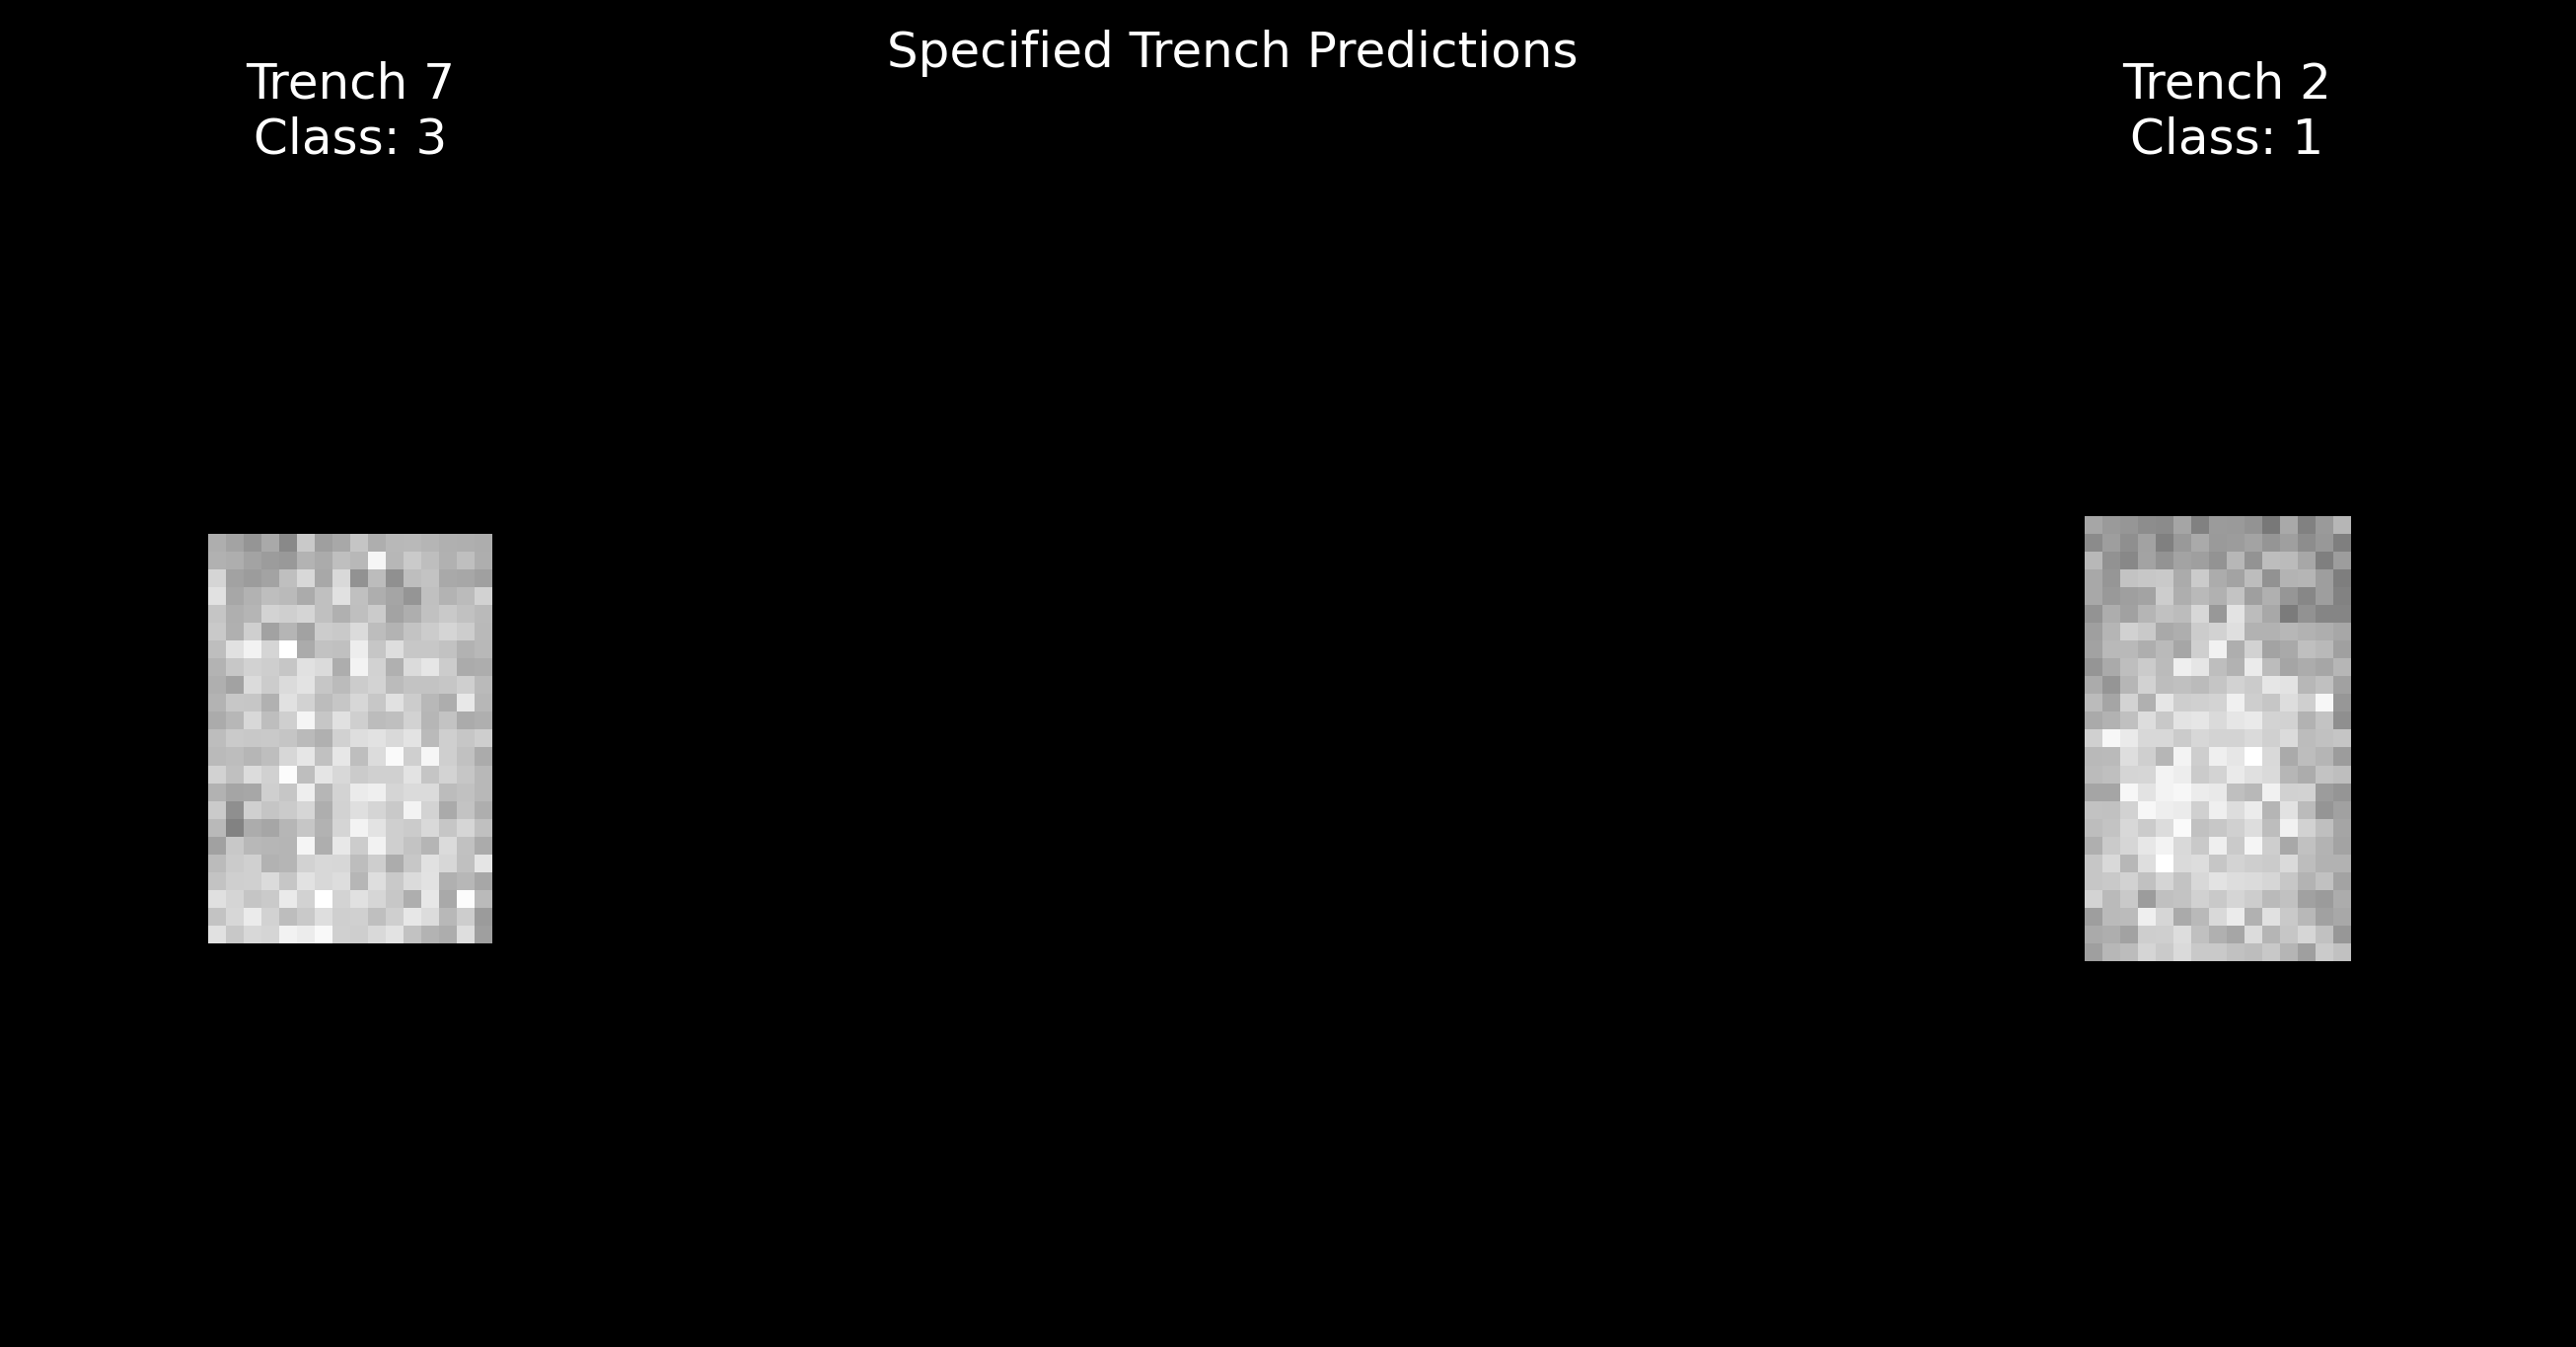

In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm  # Import tqdm for the progress bar
from collections import defaultdict

# ---------------------------
# Min-max normalization (same as your normalize_image function)
# ---------------------------
def normalize_image(image):
    normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized

# ---------------------------
# Preprocessing function (no resizing, just normalization and reshaping to 4D)
# ---------------------------
def preprocess_image(image):
    # Apply per-image min-max normalization
    image_normalized = normalize_image(image)

    # Expand dimensions to match model input shape (1, height, width, 1)
    image_expanded = np.expand_dims(image_normalized, axis=[0, -1])

    return image_expanded

# ---------------------------
# Function to classify a single mother cell image
# ---------------------------
def classify_mother_cell_image(model, image):
    # Make prediction
    prediction = model.predict(image)

    # Get predicted class index
    predicted_class = np.argmax(prediction, axis=-1)[0]

    # Print probabilities for each class
    print(f"Class probabilities: {prediction}")

    return predicted_class

# ---------------------------
# Specify the indices you want to process
# ---------------------------
# Example: Specify which trenches to predict
selected_indices = [3, 7, 2]  # <=== Modify this list to your desired indices

# Dictionaries to store counts and image IDs per predicted class
class_counts = defaultdict(int)
class_ids = defaultdict(list)

# To store images and their predicted classes for visualization
sampled_images = []
sampled_classes = []
sampled_indices = []

# ---------------------------
# Loop over only selected trenches
# ---------------------------
for i in selected_indices:
    if i >= len(processed_images_6436):
        print(f"Index {i} is out of range, skipping.")
        continue

    trench_images = processed_images_6436[i]

    if trench_images[0] is None:
        print(f"Skipping trench {i} as no mother cell mask was found.")
        continue

    # Use the channel image for classification
    image = trench_images[1]

    # Preprocess (min-max normalize & add batch/channel dimensions)
    preprocessed_image = preprocess_image(image)

    # Classify the image using the loaded model
    predicted_class = classify_mother_cell_image(model_PRISM, preprocessed_image)

    # Update counts and trench IDs
    class_counts[predicted_class] += 1
    class_ids[predicted_class].append(i)

    # Store for visualization
    sampled_images.append(image)
    sampled_classes.append(predicted_class)
    sampled_indices.append(i)

    print(f"Trench {i}: Predicted class: {predicted_class}")

# ---------------------------
# Final summary statistics
# ---------------------------
print("\nClassification Statistics:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} images")

# ---------------------------
# Visualize sampled images and their predictions
# ---------------------------
fig, axes = plt.subplots(1, len(sampled_images), figsize=(15, 5))

for idx, (img, pred_class, trench_id) in enumerate(zip(sampled_images, sampled_classes, sampled_indices)):
    ax = axes[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Trench {trench_id}\nClass: {pred_class}")
    ax.axis('off')

plt.suptitle("Specified Trench Predictions")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class probabilities: [[0.00658595 0.65539056 0.31534755 0.02267587]]
Predicted class for a real dataset image: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction probabilities for real image: [[0.00658595 0.65539056 0.31534755 0.02267587]]


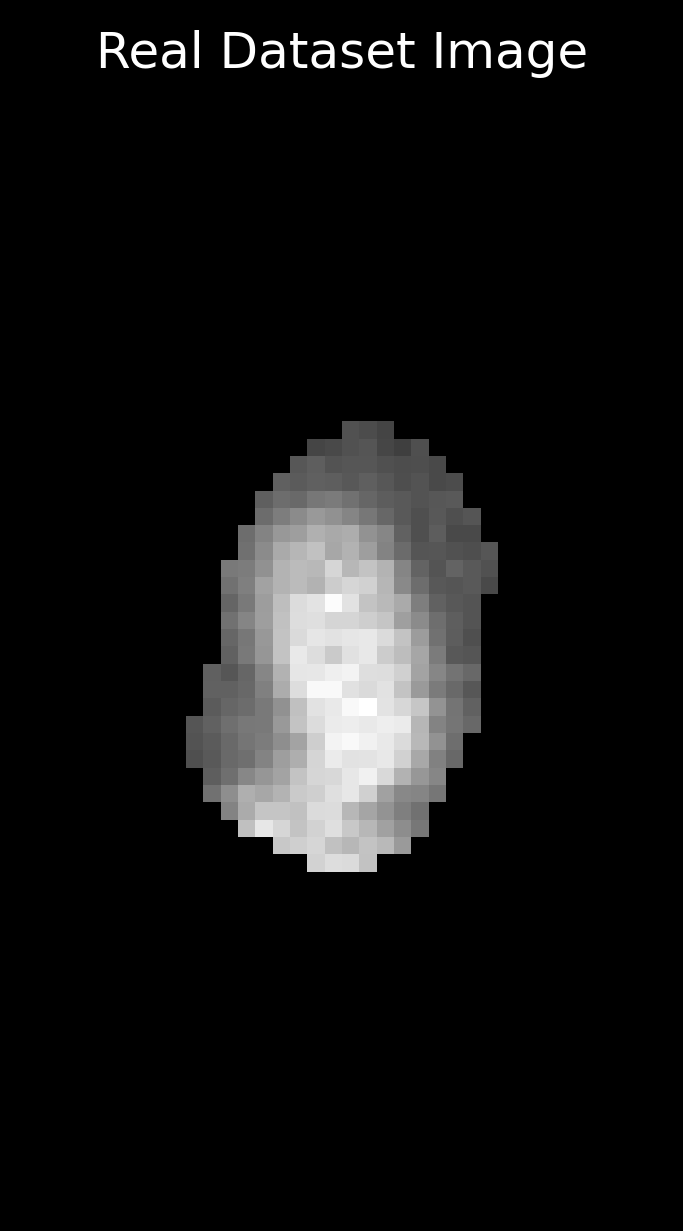

In [44]:
import numpy as np

def normalize_image(image):
    """
    Normalize a single image using the formula:
    I_normalized = (I - I_min) / (I_max - I_min)
    Ensures the image intensity values are scaled to [0, 1].
    """
    I_min = np.min(image)
    I_max = np.max(image)
    
    # Handle edge case where the intensity range is zero
    if I_max == I_min:
        print("The image has no intensity variation. Returning a zero-filled normalized image.")
        return np.zeros_like(image)
    
    normalized_image = (image - I_min) / (I_max - I_min)
    return normalized_image

# Example usage with your single preprocessed real image
normalized_real_image = normalize_image(preprocessed_real_image)

# Classify the real image
predicted_class_for_real = classify_mother_cell_image(model_PRISM, normalized_real_image)

# Print the result
print(f"Predicted class for a real dataset image: {predicted_class_for_real}")

# Print class probabilities
prediction = model_PRISM.predict(normalized_real_image)
print(f"Prediction probabilities for real image: {prediction}")

# Display the real image for visual verification
import matplotlib.pyplot as plt
plt.imshow(real_image, cmap='gray')
plt.title("Real Dataset Image")
plt.axis('off')
plt.show()
# [0.55894756 0.08837636 0.00562864 0.3470474]


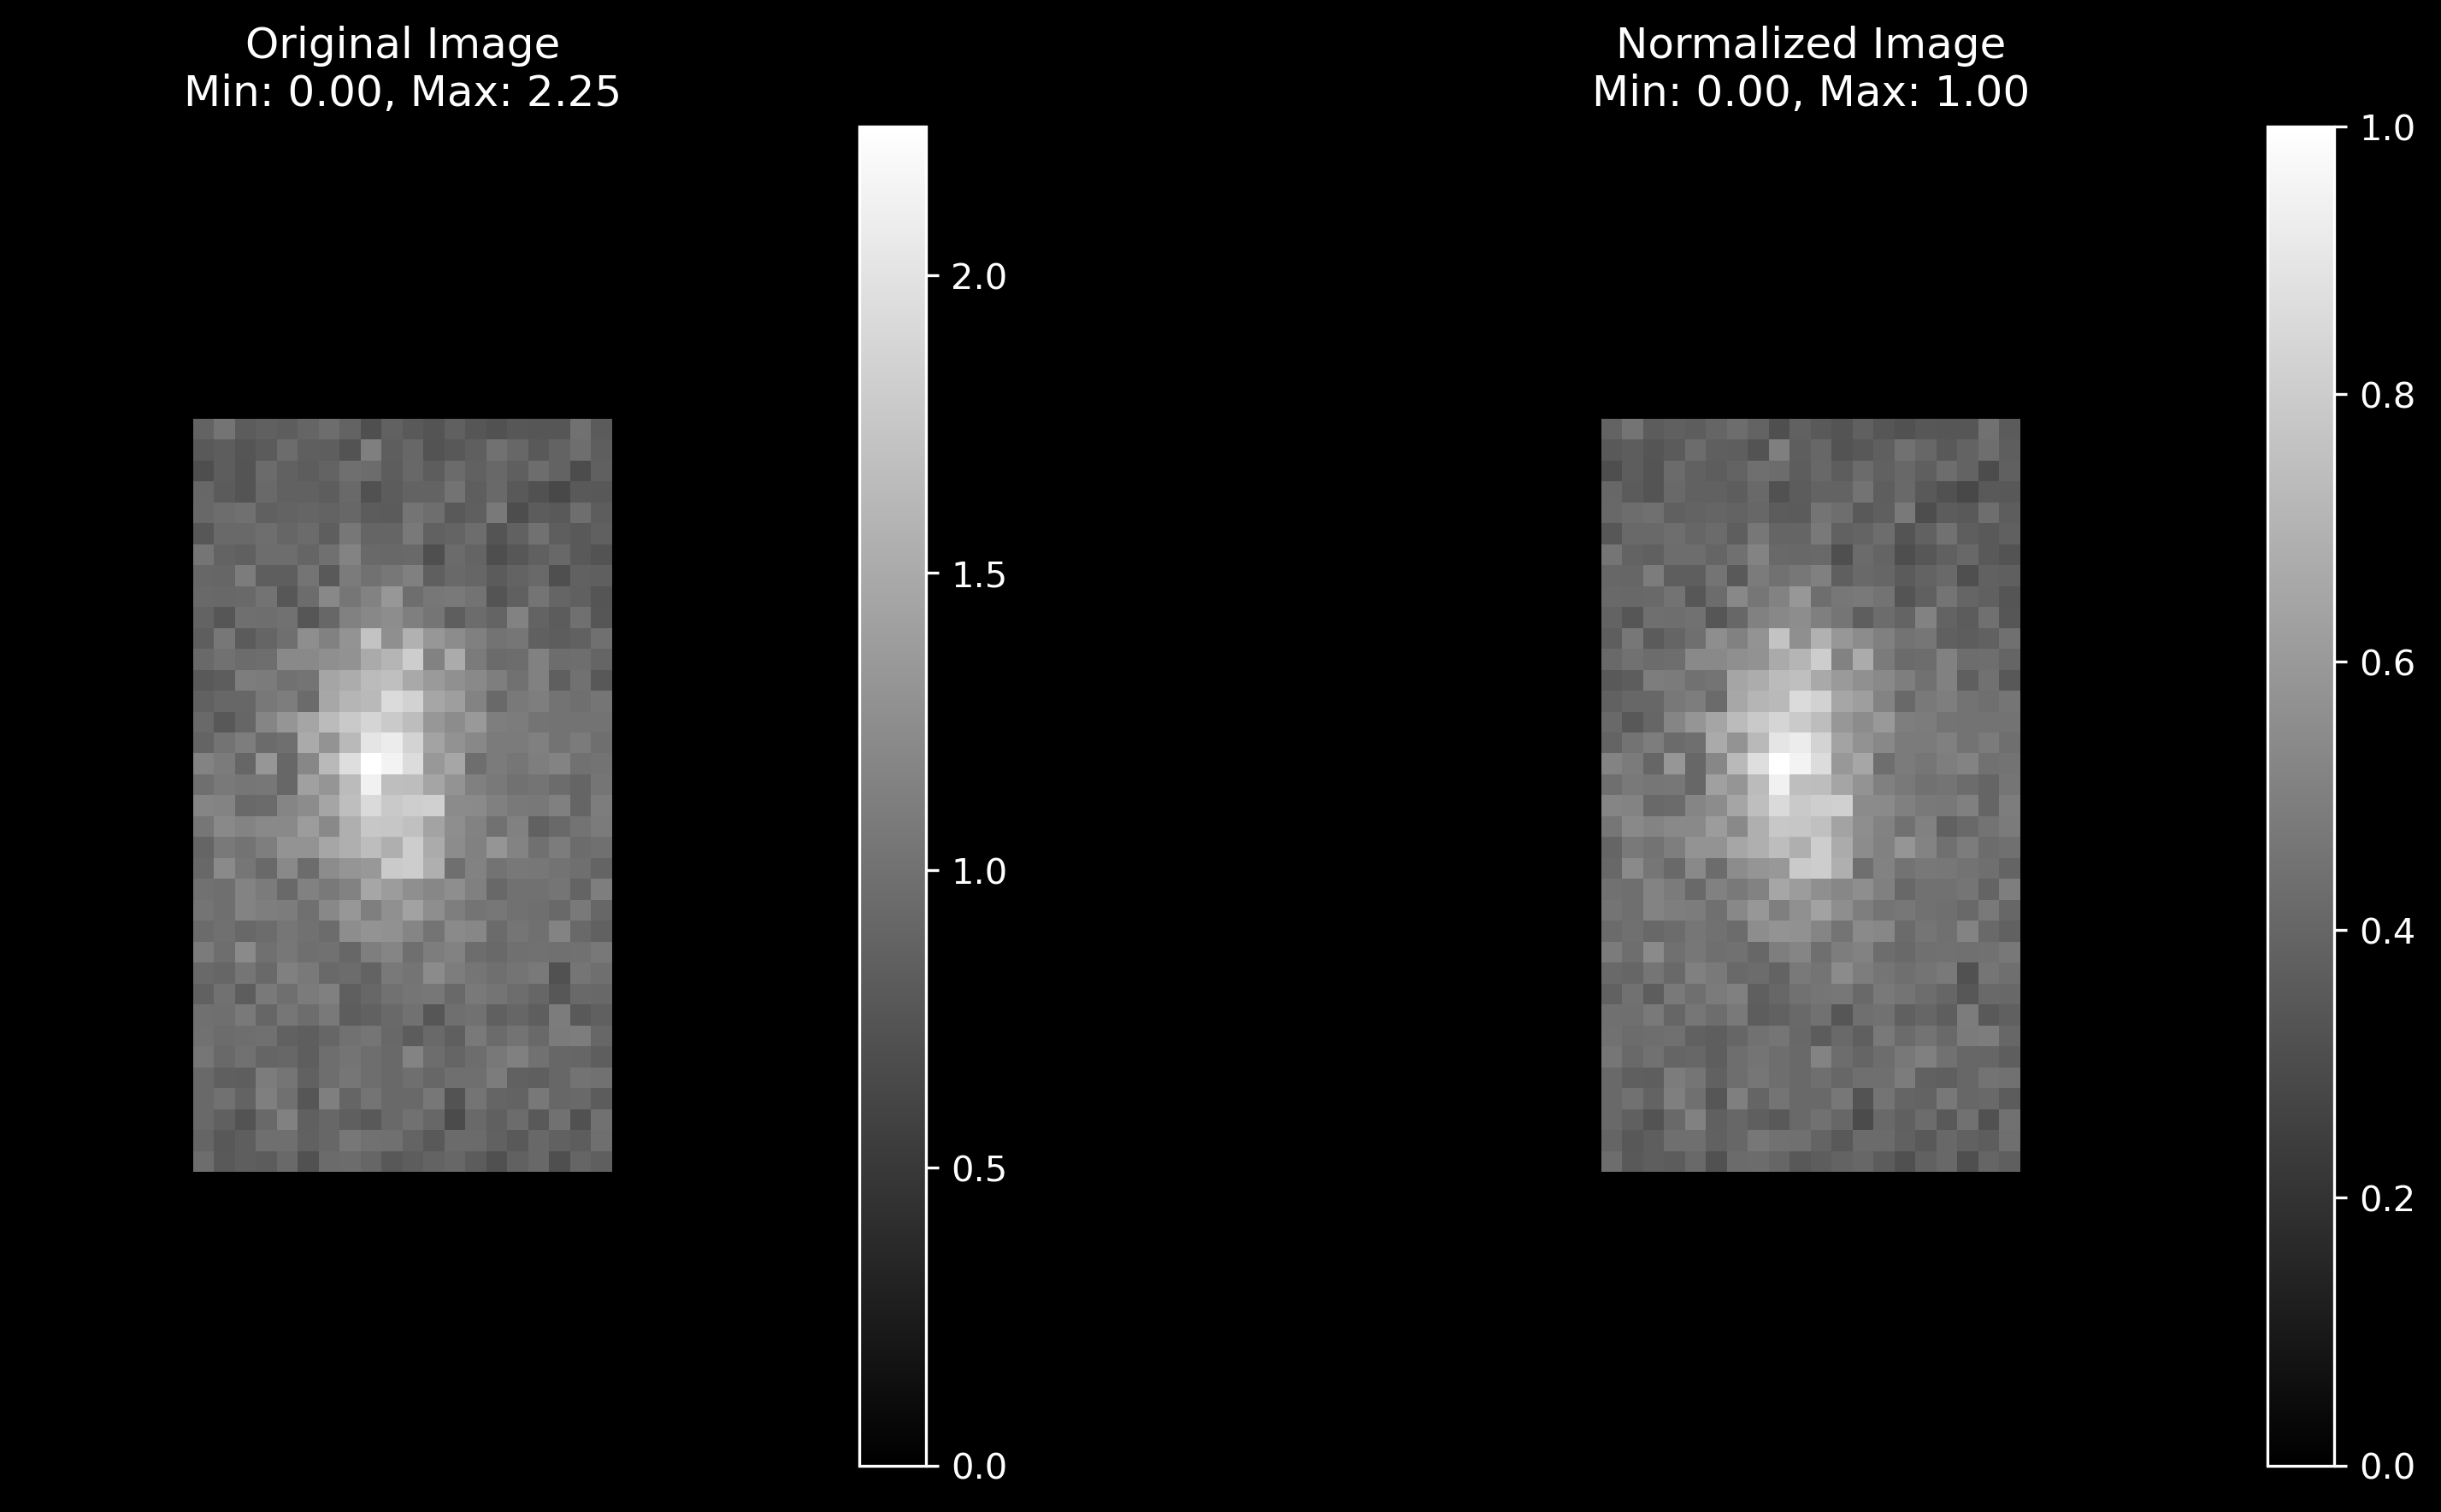

In [195]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_image(image):
    """
    Normalize a single image using the formula:
    I_normalized = (I - I_min) / (I_max - I_min)
    Ensures the image intensity values are scaled to [0, 1].
    """
    I_min = np.min(image)
    I_max = np.max(image)
    
    # Handle edge case where the intensity range is zero
    if I_max == I_min:
        print("The image has no intensity variation. Returning a zero-filled normalized image.")
        return np.zeros_like(image)
    
    normalized_image = (image - I_min) / (I_max - I_min)
    return normalized_image

# Example usage with your single preprocessed real image
# Assuming `preprocessed_real_image` has shape (1, 64, 36, 1)
normalized_real_image = normalize_image(preprocessed_real_image)

# Remove unnecessary dimensions for visualization
original_image = np.squeeze(preprocessed_real_image)  # Shape (64, 36)
normalized_image = np.squeeze(normalized_real_image)  # Shape (64, 36)

# Plot to compare before and after normalization
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title(f"Original Image\nMin: {np.min(original_image):.2f}, Max: {np.max(original_image):.2f}")
plt.colorbar()
plt.axis('off')

# Normalized Image
plt.subplot(1, 2, 2)
plt.imshow(normalized_image, cmap='gray')
plt.title(f"Normalized Image\nMin: {np.min(normalized_image):.2f}, Max: {np.max(normalized_image):.2f}")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


In [101]:
# Print the weights of the first layer to ensure they are not all the same
first_layer_weights = model_PRISM.layers[0].get_weights()
print("First layer weights:", first_layer_weights)


First layer weights: []


In [102]:
for layer in model_PRISM.layers:
    print(layer.name, layer.get_weights())


CHANNEL-INPUT []
CONV1 [array([[[[-4.94924858e-02, -1.12275286e-02,  2.52093058e-02,
           4.69638966e-04, -1.83192419e-03, -1.71209332e-02,
           2.30006557e-02,  9.03657358e-03, -8.95502139e-03,
          -1.72089096e-02, -5.09379320e-02,  2.87670013e-03,
           9.57160082e-04,  1.10923938e-01, -1.40478648e-03,
          -6.70287805e-03]],

        [[-2.02736515e-03, -2.85267066e-02, -1.46757183e-03,
          -4.29755746e-05, -3.10971256e-04, -1.85496043e-02,
           4.90187407e-02,  9.13221214e-04, -3.86399329e-02,
           2.55945586e-02, -8.65314677e-02, -8.85104574e-03,
          -2.96922587e-02,  4.08632262e-03, -1.76676884e-02,
          -2.41477545e-02]],

        [[ 6.64028749e-02, -1.03507964e-02, -1.91156939e-02,
          -3.11109878e-04,  8.95288948e-04, -2.45332103e-02,
           5.42447083e-02, -3.21923420e-02, -1.97717436e-02,
           6.27926290e-02, -5.62882572e-02, -1.24866432e-02,
          -3.88075896e-02, -1.86762176e-02, -2.69887270e-03,
 

Images shape: (3000, 64, 36, 1)
Labels shape: (3000, 1)


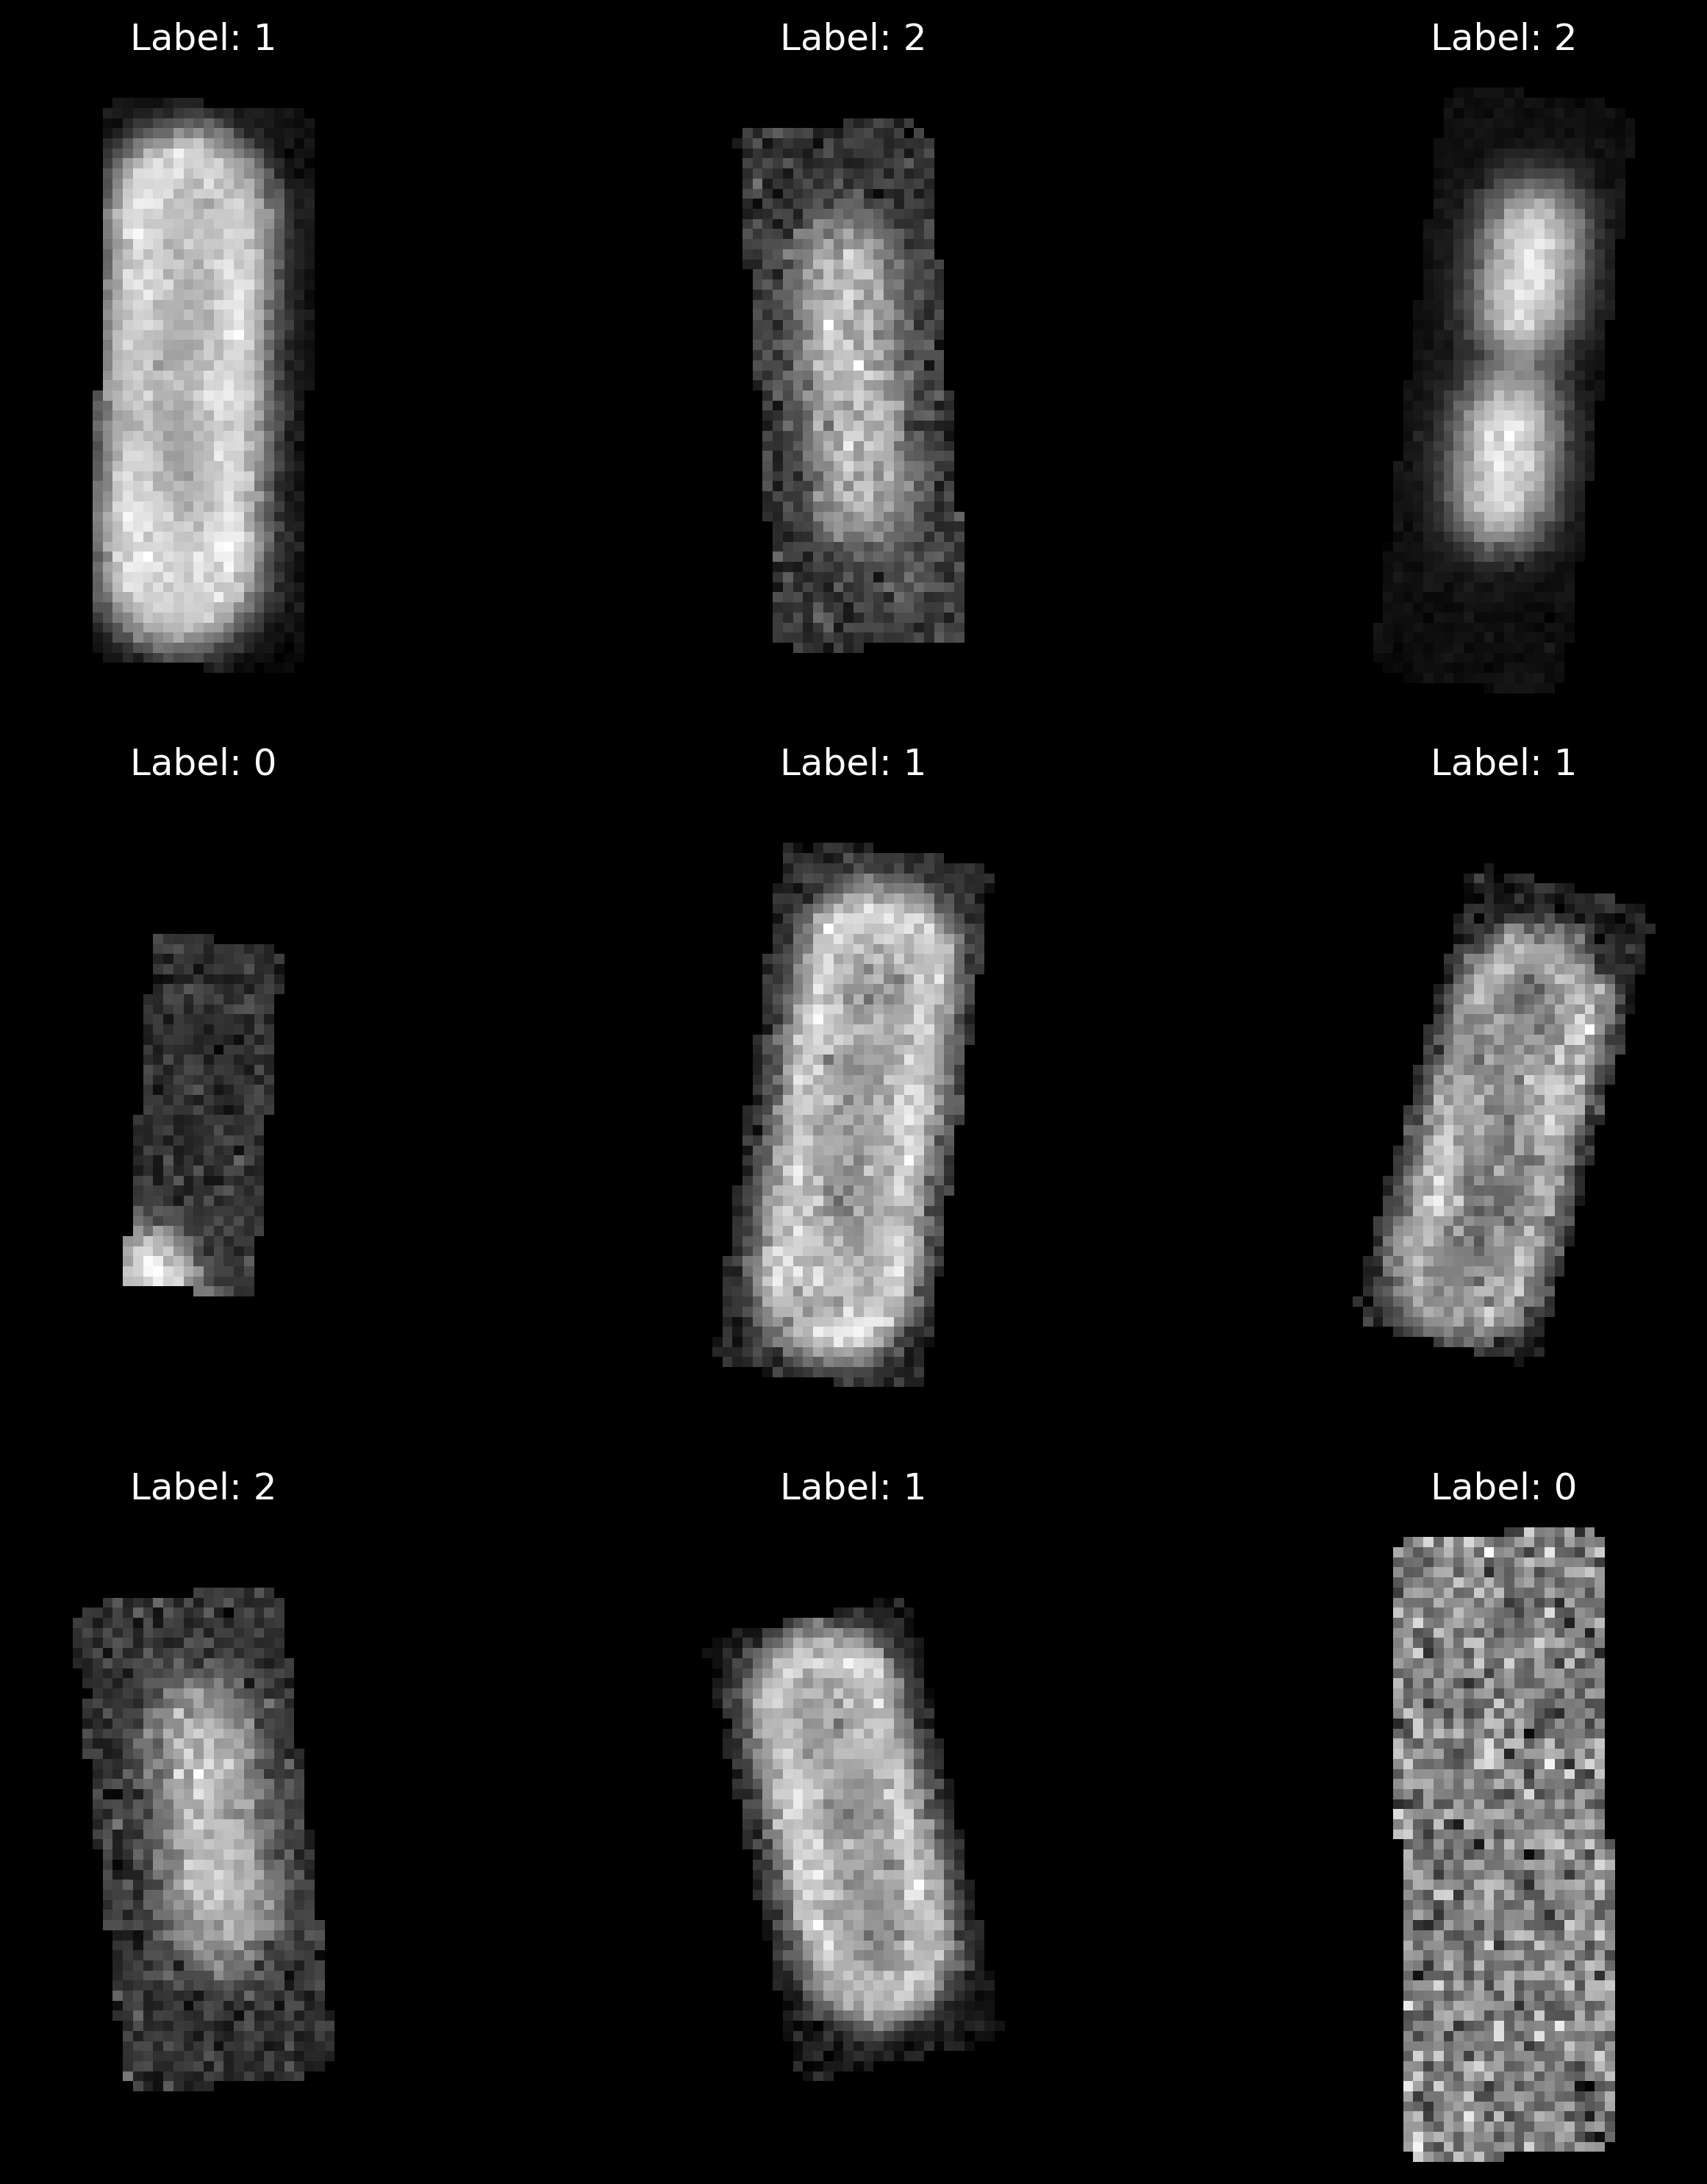

In [39]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the specified pickle file
with open(r'D:\PRISM\PRISM_model\ch_training_data\test_data_categorical.pkl', 'rb') as f:
    rui_data = pickle.load(f)

# Extract images and labels from the loaded data
images, labels = rui_data

# Check the shape of the arrays to understand the data better
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Visualize a grid of images with their labels
num_images = 9  # Number of images to display
plt.figure(figsize=(10, 10))

for i in range(num_images):
    # Select a random index
    idx = np.random.randint(0, images.shape[0])
    
    # Get the image and label
    image = images[idx, :, :, 0]  # Assuming single-channel grayscale images
    label = int(labels[idx][0])   # Assuming labels are stored as floats
    
    # Plot the image with its label
    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
